use output_scene_dataset_6, add albumentation finetuning,APPLY AUGMENTATION TO RAW DEPTH (Fixes the rotation physics) at STEP3,
rotation & flips only,
Delete BOX IOU logic at training.
Remove dr
FIX get item (if depth data=0 in training set, the GT is 0).
Solve TTA sigmoid prob giving test iou 0.01

Updated Epoch & Early Stopping 
FT Fix: Freeze BN Layers
add depth accuracy in the end


In [1]:
# ---------------------------
# 0) Install (Colab) - run once
# ---------------------------
!pip install -q torch torchvision --quiet
!pip install -q opencv-python scikit-learn matplotlib tqdm
!pip install -q albumentations
# Force reinstalling compatible versions of the entire scientific stack
!pip install --upgrade --force-reinstall numpy==1.26.4 scikit-learn pandas matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 122.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 138.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 150.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 125.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 132.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 146.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 158.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.0/35.0 MB 145.8 MB/s  0:00:00m0:00:01
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.2
    Uninstalling pytz-2025.2:
      Successfully uninstalled pytz-2025.2
  Attempting uninstall: tzdata━━━━━━━━━━━━━━━━━━  0/18 [pytz]
    Found existing installation: tzdata 2025.30m  0/18 [pytz]
    Uninstalling tzdata-2025.3:━━━━━━━━━━━━━  0/18 [pytz]
      Successfully uninstalled tzdata-2025.3  0/18 [pytz]

In [2]:
# ---------------------------
# 1) Imports & Config
# ---------------------------
import os, glob, json, math, time
from pathlib import Path
from typing import List, Tuple, Dict
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split

# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [3]:
# 📌 Step C: Find All Paired Files

import glob
import os
from sklearn.model_selection import train_test_split

data_dir = "/teamspace/studios/this_studio/output_scene_dataset_LA_0.01"

depth_files = sorted(glob.glob(os.path.join(data_dir, "*dented_depth.npy")))
mask_files = sorted(glob.glob(os.path.join(data_dir, "*dent_mask.png")))

items = list(zip(depth_files, mask_files))
print("Total paired samples:", len(items))

# ---------------------------
# 2) Paths (EDIT if needed)
# ---------------------------
DATA_DIR = data_dir  # <-- set to your folder
OUT_DIR = os.path.join(data_dir, "predictions_6d")
os.makedirs(OUT_DIR, exist_ok=True)


Total paired samples: 893


In [4]:
# ---------------------------
# 3) Dataset (UPDATED: Handles RANSAC 0s Correctly)
# ---------------------------
import albumentations as A
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
from pathlib import Path
from typing import List, Tuple

# 1. Define "Safe" Geometric Transformations
def get_train_transforms():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
    ])

class DepthDentDataset(Dataset):
    def __init__(self, samples: List[Tuple[str,str]], augment: bool=False):
        self.samples = samples
        self.augment = augment
        self.transform = get_train_transforms() if augment else None

    def __len__(self):
        return len(self.samples)

    def _load_depth(self, path):
        return np.load(path).astype(np.float32)

    def _load_mask(self, path):
        p = Path(path)
        if p.suffix.lower() == ".npy":
            m = np.load(path)
            # FORCE BINARY: Any value > 0 becomes 1
            m = (m > 0).astype(np.uint8)
        else:
            m = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if m is None: raise RuntimeError(f"Cannot read mask: {path}")
            m = (m > 127).astype(np.uint8)
        return m

    def _normalize_and_compute_gradients(self, depth):
        """
        Smart Normalization: Treats 0 as Background.
        Only normalizes and computes stats on 'Valid' (Non-Zero) pixels.
        """
        # --- 1. Identify Valid Region (Container) ---
        valid_mask = (depth > 0)
        
        # If image is empty (all background), return zeros
        if not np.any(valid_mask):
            return np.zeros_like(depth), np.zeros_like(depth), np.zeros_like(depth)

        # --- 2. Normalize Depth (Map Container to 0.1 - 1.0) ---
        d_min = np.min(depth[valid_mask])
        d_max = np.max(depth[valid_mask])
        range_val = d_max - d_min
        if range_val < 1e-6: range_val = 1.0

        depth_norm = np.zeros_like(depth)
        # Background stays 0.0. Container becomes 0.1 to 1.0
        # This keeps the "Edge" visible to the model!
        depth_norm[valid_mask] = 0.1 + 0.9 * ((depth[valid_mask] - d_min) / range_val)

        # --- 3. Compute Gradients ---
        # Note: Gradients at the edge (0 -> 0.1) will be strong. This is GOOD.
        # It tells the model "Here is the container boundary."
        gx = cv2.Sobel(depth_norm, cv2.CV_32F, 1, 0, ksize=3)
        gy = cv2.Sobel(depth_norm, cv2.CV_32F, 0, 1, ksize=3)

        # Robust normalization that IGNORES background 0s
        def robust_norm(x, mask):
            # Only look at the container pixels + edges to compute stats
            # This prevents the large background from driving the MAD to 0
            v = x[mask] 
            if v.size == 0: return np.zeros_like(x)
            
            med = np.median(v)
            mad = np.median(np.abs(v - med)) + 1e-6
            
            out = (x - med) / (3.0 * mad)
            return ((np.clip(out, -3.0, 3.0) + 3.0) / 6.0).astype(np.float32)

        return depth_norm, robust_norm(gx, valid_mask), robust_norm(gy, valid_mask)

    def __getitem__(self, idx):
        depth_path, mask_path = self.samples[idx]
        depth_raw = self._load_depth(depth_path)
        mask = self._load_mask(mask_path)

        # 1. Sanitize GT (If depth is 0/Background, Mask must be 0)
        # This fixes the "RANSAC Edge Noise" issue
        valid_region = (depth_raw > 0).astype(np.float32)
        mask = mask * valid_region

        # 2. DO NOT FILL HOLES
        # We pass the raw depth (with 0s) directly.
        depth_clean = depth_raw 

        # 3. Augment
        if self.transform:
            augmented = self.transform(image=depth_clean, mask=mask)
            depth_clean = augmented['image']
            mask = augmented['mask']

        # 4. Compute Gradients & Normalize (Smartly)
        # This happens AFTER augmentation so gradients are correct for rotation
        depth_n, gx, gy = self._normalize_and_compute_gradients(depth_clean)

        # 5. Stack (Depth, GradX, GradY)
        image = np.stack([depth_n, gx, gy], axis=-1).astype(np.float32)

        image = torch.from_numpy(image.transpose(2, 0, 1)).float()
        mask = torch.from_numpy(mask).float().unsqueeze(0)

        return image, mask

In [5]:
# ---------------------------
# 4) Model: Attention-UNet
# ---------------------------
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel=3, padding=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel, padding=padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel, padding=padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(nn.Conv2d(F_g, F_int, kernel_size=1), nn.BatchNorm2d(F_int))
        self.W_x = nn.Sequential(nn.Conv2d(F_l, F_int, kernel_size=1), nn.BatchNorm2d(F_int))
        self.psi = nn.Sequential(nn.ReLU(inplace=True),
                                 nn.Conv2d(F_int, 1, kernel_size=1),
                                 nn.Sigmoid())

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)

        # Upsample gating signal to match x1 size if needed
        if g1.shape[2:] != x1.shape[2:]:
            g1 = F.interpolate(g1, size=x1.shape[2:], mode='bilinear', align_corners=True)

        psi = self.psi(g1 + x1)
        return x * psi

class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_ch, out_ch)
    def forward(self, x, skip):
        x = self.up(x)
        if x.size() != skip.size():
            x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=False)
        return self.conv(torch.cat([x, skip], dim=1))

class AttentionUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, filters=[32,64,128,256]):
        super().__init__()
        f1, f2, f3, f4 = filters
        self.enc1 = ConvBlock(in_channels, f1)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(f1, f2)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(f2, f3)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = ConvBlock(f3, f4)
        self.pool4 = nn.MaxPool2d(2)
        self.center = ConvBlock(f4, f4*2)

        self.att4 = AttentionGate(F_g=f4*2, F_l=f4, F_int=f4)
        self.dec4 = UpBlock(f4*2, f4)
        self.att3 = AttentionGate(F_g=f4, F_l=f3, F_int=f3)
        self.dec3 = UpBlock(f4, f3)
        self.att2 = AttentionGate(F_g=f3, F_l=f2, F_int=f2)
        self.dec2 = UpBlock(f3, f2)
        self.att1 = AttentionGate(F_g=f2, F_l=f1, F_int=f1)
        self.dec1 = UpBlock(f2, f1)

        self.final = nn.Conv2d(f1, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        c = self.center(self.pool4(e4))

        g4 = c
        x4 = self.att4(g4, e4)
        d4 = self.dec4(c, x4)

        g3 = d4
        x3 = self.att3(g3, e3)
        d3 = self.dec3(d4, x3)

        g2 = d3
        x2 = self.att2(g2, e2)
        d2 = self.dec2(d3, x2)

        g1 = d2
        x1 = self.att1(g1, e1)
        d1 = self.dec1(d2, x1)

        out = self.final(d1)
        return out

In [6]:
# ---------------------------
# 5) Losses & Metrics (CHANGES: Expects Probabilities 0-1) To avoid SIGMOID ERROR
# ---------------------------
class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.3, beta=0.7, smooth=1e-6):
        super().__init__()
        self.alpha = alpha # Penalty for False Positives (Noise)
        self.beta = beta   # Penalty for False Negatives (Missing the dent)
        self.smooth = smooth

    def forward(self, pred, target):
        pred = torch.sigmoid(pred)

        # Flatten
        pred = pred.view(-1)
        target = target.view(-1)

        # True Positives, False Positives, False Negatives
        TP = (pred * target).sum()
        FP = ((1 - target) * pred).sum()
        FN = (target * (1 - pred)).sum()

        tversky = (TP + self.smooth) / (TP + self.alpha * FP + self.beta * FN + self.smooth)
        return 1 - tversky

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0):
        super().__init__()
        self.gamma = gamma
        self.bce = nn.BCEWithLogitsLoss(reduction='none')
    def forward(self, pred, target):
        # pred: logits
        bce_loss = self.bce(pred, target)
        pt = torch.exp(-bce_loss)
        loss = ((1-pt)**self.gamma * bce_loss).mean()
        return loss

# Update Combined Loss
def combined_loss(pred, target):
    # 0.5 Tversky + 0.5 Focal
    return 0.5 * TverskyLoss(alpha=0.6, beta=0.4)(pred, target) + 0.5 * FocalLoss()(pred, target)

# Metrics
def iou_score_batch(pred, target, thr=0.5, eps=1e-6):
    pred_bin = (pred > thr).float()       #<------ i removed torch.sigmoid(pred) here and all metrics
    inter = (pred_bin * target).sum(dim=(1,2,3))
    union = (pred_bin + target - pred_bin*target).sum(dim=(1,2,3))
    return ((inter + eps) / (union + eps)).mean().item()

def dice_score_batch(pred, target, thr=0.5, eps=1e-6):
    pred_bin = (pred > thr).float()
    inter = (pred_bin * target).sum(dim=(1,2,3))
    denom = (pred_bin + target).sum(dim=(1,2,3))
    return ((2*inter + eps) / (denom + eps)).mean().item()

def precision_batch(pred, target, thr=0.5, eps=1e-6):
    pred_bin = (pred > thr).float()
    tp = (pred_bin * target).sum(dim=(1,2,3))
    fp = (pred_bin * (1-target)).sum(dim=(1,2,3))
    return ((tp + eps) / (tp + fp + eps)).mean().item()

def recall_batch(pred, target, thr=0.5, eps=1e-6):
    pred_bin = (pred > thr).float()
    tp = (pred_bin * target).sum(dim=(1,2,3))
    fn = ((1-pred_bin) * target).sum(dim=(1,2,3))
    return ((tp + eps) / (tp + fn + eps)).mean().item()

In [7]:
# ---------------------------
# 6) Prepare dataset & sampler (UPDATED for NPY Priority)
# ---------------------------
# Pair depth and mask files
depth_paths = sorted(glob.glob(os.path.join(DATA_DIR, "*dented_depth.npy")))
pairs = []

print("🔍 Pairing files (Prioritizing .npy masks)...")

for dp in depth_paths:
    base = os.path.basename(dp).replace("_dented_depth.npy","")

    # 1. Look for NPY Mask FIRST (The "Master Copy")
    mp = os.path.join(DATA_DIR, base + "_dent_mask.npy")

    # 2. If NPY doesn't exist, fallback to PNG
    if not os.path.exists(mp):
        mp_alt = os.path.join(DATA_DIR, base + "_dent_mask.png")
        if os.path.exists(mp_alt):
            mp = mp_alt
        else:
            print(f"⚠️ Missing mask for: {base}")
            continue

    pairs.append((dp, mp))

print(f"✅ Total paired samples: {len(pairs)}")
print(f"   (Sample Check: {os.path.basename(pairs[0][1])})") # Verify it picked .npy

# Proper train/val/test split: 70% train, 15% val, 15% test
train_val_pairs, test_pairs = train_test_split(pairs, test_size=0.15, random_state=42)
train_pairs, val_pairs = train_test_split(train_val_pairs, test_size=0.1765, random_state=42)

print(f"Train samples: {len(train_pairs)}")
print(f"Val samples:   {len(val_pairs)}")
print(f"Test samples:  {len(test_pairs)}")

# Compute weights for sampler (Handling both NPY and PNG)
def sample_weight(pair):
    _, mask_path = pair
    # Load efficiently based on extension
    if mask_path.endswith(".npy"):
        m = np.load(mask_path)
    else:
        m = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Check if there is any dent (sum > 0)
    has_pos = (m > 0).sum() > 0
    return 1.0 if has_pos else 0.2  # give less weight to no-dent images

print("⚖️ Computing sampler weights...")
weights = [sample_weight(p) for p in tqdm(train_pairs)]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

train_ds = DepthDentDataset(train_pairs, augment=True)
val_ds = DepthDentDataset(val_pairs, augment=False)

train_loader = DataLoader(train_ds, batch_size=4, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=2)

🔍 Pairing files (Prioritizing .npy masks)...
✅ Total paired samples: 893
   (Sample Check: 20ft_0001_internal_back_wall_dent_mask.npy)
Train samples: 625
Val samples:   134
Test samples:  134
⚖️ Computing sampler weights...


100%|██████████| 625/625 [00:00<00:00, 1343.73it/s]


In [8]:
# ---------------------------
# 7) Create model / optimizer
# ---------------------------
model = AttentionUNet(in_channels=3, out_channels=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-4) #high learning rate
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=3
)

if scheduler.num_bad_epochs == 0:
    print("↘ LR reduced!")



↘ LR reduced!


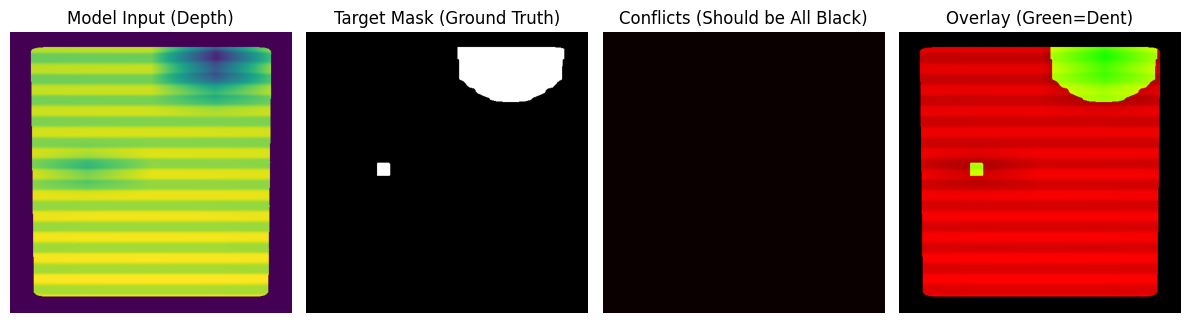

✅ PASSED: No ghost dents found in empty space!


In [9]:
# --- SANITY CHECK CELL (Run this once before training) ---
import matplotlib.pyplot as plt
import numpy as np

# 1. Grab one batch from your existing train_loader
# (This simulates exactly what the model will see during training)
data_iter = iter(train_loader)
images, masks = next(data_iter)

# 2. Extract the first image in the batch
# PyTorch tensor is (C, H, W) -> Convert to Numpy (H, W, C)
img_np = images[0].numpy().transpose(1, 2, 0)
depth_channel = img_np[:,:,0] # The first channel is Depth
mask_np = masks[0].numpy().squeeze()

# 3. Plot
plt.figure(figsize=(12, 4))

# A. The Input Depth
plt.subplot(1, 4, 1)
plt.title("Model Input (Depth)")
plt.imshow(depth_channel, cmap='viridis')
plt.axis('off')

# B. The Target Mask
plt.subplot(1, 4, 2)
plt.title("Target Mask (Ground Truth)")
plt.imshow(mask_np, cmap='gray')
plt.axis('off')

# C. The "Danger Zone" (Visualizing the Fix)
# We show pixels where Mask=1 BUT Depth=0 (The "Bad Data")
bad_pixels = (mask_np == 1) & (depth_channel == 0)
plt.subplot(1, 4, 3)
plt.title("Conflicts (Should be All Black)")
plt.imshow(bad_pixels, cmap='hot')
plt.axis('off')

# D. The Overlay
plt.subplot(1, 4, 4)
plt.title("Overlay (Green=Dent)")
combined = np.zeros((mask_np.shape[0], mask_np.shape[1], 3))
combined[:,:,0] = (depth_channel - depth_channel.min()) / (depth_channel.max() - depth_channel.min() + 1e-6) # Blueish depth
combined[:,:,1] = mask_np # Green dent
plt.imshow(combined)
plt.axis('off')

plt.tight_layout()
plt.show()

# 4. Text Confirmation
if np.sum(bad_pixels) == 0:
    print("✅ PASSED: No ghost dents found in empty space!")
else:
    print(f"❌ FAILED: Found {np.sum(bad_pixels)} bad pixels! (Mask exists where Depth is 0)")

In [10]:
### HELPER CELL ###

import numpy as np
import cv2
import torch

def mask_to_boxes(binary_mask):
    """
    Converts a binary mask (H, W) into a list of bounding boxes [x1, y1, x2, y2].
    Uses contours to handle separate dents and ignore small noise.
    """
    # Ensure mask is uint8 (0-255)
    mask = (binary_mask * 255).astype(np.uint8) if binary_mask.max() <= 1.0 else binary_mask.astype(np.uint8)

    # Find contours (External only - prevents boxes inside boxes)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    boxes = []
    for cnt in contours:
        # Filter tiny noise (e.g., single pixels)
        if cv2.contourArea(cnt) > 50:
            x, y, w, h = cv2.boundingRect(cnt)
            boxes.append([x, y, x+w, y+h]) # Format: [x1, y1, x2, y2]

    return boxes

def calculate_single_box_iou(boxA, boxB):
    """Calculates IoU between two boxes [x1, y1, x2, y2]."""
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)
    return iou

def compute_batch_box_iou(pred_probs, gt_masks, threshold=0.5):
    """
    Computes average Box IoU for a batch of predictions vs ground truth.
    Args:
        pred_probs: Tensor (B, 1, H, W) - Sigmoid output from model
        gt_masks: Tensor (B, 1, H, W) - Ground Truth
    """
    batch_ious = []

    # Move to CPU for OpenCV processing
    preds = (pred_probs > threshold).float().cpu().numpy()
    gts = gt_masks.cpu().numpy()

    for i in range(preds.shape[0]):
        p_mask = preds[i, 0]
        g_mask = gts[i, 0]

        pred_boxes = mask_to_boxes(p_mask)
        gt_boxes = mask_to_boxes(g_mask)

        # Scenario 1: Both empty (Perfect prediction of "no dent")
        if len(gt_boxes) == 0 and len(pred_boxes) == 0:
            batch_ious.append(1.0)
            continue
        # Scenario 2: One empty, one not (Complete miss)
        elif len(gt_boxes) == 0 or len(pred_boxes) == 0:
            batch_ious.append(0.0)
            continue

        # Scenario 3: Match boxes
        # Simple strategy: For every GT box, find the best matching Pred box
        image_ious = []
        for gt_box in gt_boxes:
            max_iou = 0.0
            for pred_box in pred_boxes:
                iou = calculate_single_box_iou(gt_box, pred_box)
                if iou > max_iou:
                    max_iou = iou
            image_ious.append(max_iou)

        batch_ious.append(np.mean(image_ious))

    return np.mean(batch_ious)


def filter_small_mask_regions(binary_mask_tensor, min_area=200):
    """
    Removes connected components smaller than min_area from a binary mask.
    Args:
        binary_mask_tensor: (H, W) Tensor or Numpy array (0 or 1)
        min_area: Minimum pixel area to keep
    Returns:
        Filtered numpy array (H, W)
    """
    # Ensure input is numpy uint8
    if isinstance(binary_mask_tensor, torch.Tensor):
        mask = binary_mask_tensor.cpu().numpy().astype(np.uint8)
    else:
        mask = binary_mask_tensor.astype(np.uint8)

    # Find connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)

    # Create new clean mask
    new_mask = np.zeros_like(mask)

    # Loop through components (Skip label 0 which is background)
    for label_id in range(1, num_labels):
        area = stats[label_id, cv2.CC_STAT_AREA]
        if area >= min_area:
            new_mask[labels == label_id] = 1

    return new_mask

In [11]:
# ---------------------------
# 8) Training loop with Early Stopping
# ---------------------------
NUM_EPOCHS = 100  # 100 epochs, but early stopping will prevent overfitting <---- CHANGES in 4f
best_iou = 0.0      # Track Mask IoU just for info
save_path = os.path.join(OUT_DIR, "best_attention_unet.pth")

# Early stopping parameters
patience = 20  # Increased from 10 to 15 (Give it more time to recover) <---- CHANGES in 4f
patience_counter = 0
min_delta = 0.001  # Minimum change to qualify as improvement

# Gradient Accumulation Config
accumulation_steps = 4  # <--- CHANGE 2: Virtual Batch Size = 4 * 4 = 16

# Track history for analysis
train_losses = []
val_losses = []
val_ious = []

print(f"🚀 Starting Training for {NUM_EPOCHS} epochs...")

for epoch in range(1, NUM_EPOCHS+1):
    # --- TRAIN PHASE ---
    model.train()
    running_loss = 0.0

    # Initialize zero gradients at start of epoch
    optimizer.zero_grad()

    for i, (inp, mask) in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch} [train]"):
        inp = inp.to(device)
        mask = mask.to(device)

        outputs = model(inp)    # These are LOGITS
        loss = combined_loss(outputs, mask)   # Loss expects LOGITS (Keep this)

        # Normalize loss to account for accumulation
        loss = loss / accumulation_steps
        loss.backward()

        # Step optimizer only after accumulating enough gradients
        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        # Multiply back for logging
        running_loss += float(loss.item() * accumulation_steps)

    # --- VALIDATION PHASE ---
    model.eval()
    val_loss = 0.0

    # Accumulators
    iou_acc = 0.0
    dice_acc = 0.0
    prec_acc = 0.0
    rec_acc = 0.0
    n_batches = 0

    with torch.no_grad():
        for inp, mask in tqdm(val_loader, desc=f"Epoch {epoch} [val]"):
            inp = inp.to(device)
            mask = mask.to(device)

            outputs = model(inp)  # Logits

            # 1. Loss (Uses Logits)
            loss = combined_loss(outputs, mask)
            val_loss += float(loss.item())

            # 2. Metrics (Uses Probabilities)
            # ✅ THE FIX: Apply Sigmoid here!
            probs = torch.sigmoid(outputs)

            # Now pass 'probs' (0-1) to your updated metric functions
            iou_acc += iou_score_batch(probs, mask)
            dice_acc += dice_score_batch(probs, mask)
            prec_acc += precision_batch(probs, mask)
            rec_acc += recall_batch(probs, mask)

            n_batches += 1

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / (n_batches if n_batches>0 else 1)

    avg_iou = iou_acc / (n_batches if n_batches>0 else 1) # Mask IoU
    avg_dice = dice_acc / (n_batches if n_batches>0 else 1)
    avg_prec = prec_acc / (n_batches if n_batches>0 else 1)
    avg_rec = rec_acc / (n_batches if n_batches>0 else 1)

    # Track history
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_ious.append(avg_iou)

    # Calculate gap between train and val loss (overfitting indicator)
    loss_gap = avg_train_loss - avg_val_loss

    print(f"Epoch {epoch}/{NUM_EPOCHS} | TrainLoss: {avg_train_loss:.4f} ValLoss: {avg_val_loss:.4f} | MaskIoU: {avg_iou:.4f} | Gap: {loss_gap:.4f}")

    # scheduler step on IoU
    scheduler.step(avg_iou)

    # --- SAVE LOGIC (Based on Mask IoU) ---
    if avg_iou > best_iou + min_delta:
        best_iou = avg_iou
        patience_counter = 0
        torch.save(model.state_dict(), save_path)
        print(f"✓ Saved best model (Mask IoU: {best_iou:.4f}): {save_path}")
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{patience})")

        if loss_gap < -0.05:
            print(f"  ⚠️ Warning: Possible overfitting")

    # Early stopping
    if patience_counter >= patience:
        print(f"\n⏹️  Early stopping triggered! No improvement for {patience} epochs.")
        break

print(f"\nBest IoU: {best_iou:.4f}")
print(f"Final train/val loss gap: {train_losses[-1] - val_losses[-1]:.4f}")

🚀 Starting Training for 100 epochs...


Epoch 1 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.29it/s]

Epoch 1/100 | TrainLoss: 0.4425 ValLoss: 0.4300 | MaskIoU: 0.6123 | Gap: 0.0125
✓ Saved best model (Mask IoU: 0.6123): /teamspace/studios/this_studio/output_scene_dataset_LA_0.01/predictions_6d/best_attention_unet.pth



Epoch 2 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.22it/s]

Epoch 2/100 | TrainLoss: 0.4016 ValLoss: 0.4044 | MaskIoU: 0.6700 | Gap: -0.0028
✓ Saved best model (Mask IoU: 0.6700): /teamspace/studios/this_studio/output_scene_dataset_LA_0.01/predictions_6d/best_attention_unet.pth



Epoch 3 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.19it/s]

Epoch 3/100 | TrainLoss: 0.3702 ValLoss: 0.3844 | MaskIoU: 0.6507 | Gap: -0.0142
  No improvement (1/20)



Epoch 4 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.21it/s]

Epoch 4/100 | TrainLoss: 0.3447 ValLoss: 0.3570 | MaskIoU: 0.6517 | Gap: -0.0123
  No improvement (2/20)



Epoch 5 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.04it/s]

Epoch 5/100 | TrainLoss: 0.3155 ValLoss: 0.3480 | MaskIoU: 0.6371 | Gap: -0.0325
  No improvement (3/20)



Epoch 6 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.13it/s]

Epoch 6/100 | TrainLoss: 0.2847 ValLoss: 0.3129 | MaskIoU: 0.6700 | Gap: -0.0282
  No improvement (4/20)



Epoch 7 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.07it/s]

Epoch 7/100 | TrainLoss: 0.2541 ValLoss: 0.2825 | MaskIoU: 0.7018 | Gap: -0.0284
✓ Saved best model (Mask IoU: 0.7018): /teamspace/studios/this_studio/output_scene_dataset_LA_0.01/predictions_6d/best_attention_unet.pth



Epoch 8 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.30it/s]

Epoch 8/100 | TrainLoss: 0.2560 ValLoss: 0.2722 | MaskIoU: 0.6827 | Gap: -0.0162
  No improvement (1/20)



Epoch 9 [val]: 100%|██████████| 34/34 [00:02<00:00, 11.38it/s]

Epoch 9/100 | TrainLoss: 0.2468 ValLoss: 0.2621 | MaskIoU: 0.6896 | Gap: -0.0153
  No improvement (2/20)



Epoch 10 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.24it/s]

Epoch 10/100 | TrainLoss: 0.2371 ValLoss: 0.2423 | MaskIoU: 0.7018 | Gap: -0.0052
  No improvement (3/20)



Epoch 11 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.32it/s]

Epoch 11/100 | TrainLoss: 0.2085 ValLoss: 0.2413 | MaskIoU: 0.6990 | Gap: -0.0328
  No improvement (4/20)



Epoch 12 [val]: 100%|██████████| 34/34 [00:02<00:00, 11.34it/s]

Epoch 12/100 | TrainLoss: 0.2052 ValLoss: 0.2220 | MaskIoU: 0.7069 | Gap: -0.0168
✓ Saved best model (Mask IoU: 0.7069): /teamspace/studios/this_studio/output_scene_dataset_LA_0.01/predictions_6d/best_attention_unet.pth



Epoch 13 [val]: 100%|██████████| 34/34 [00:02<00:00, 11.34it/s]

Epoch 13/100 | TrainLoss: 0.2060 ValLoss: 0.2235 | MaskIoU: 0.7100 | Gap: -0.0175
✓ Saved best model (Mask IoU: 0.7100): /teamspace/studios/this_studio/output_scene_dataset_LA_0.01/predictions_6d/best_attention_unet.pth



Epoch 14 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.32it/s]

Epoch 14/100 | TrainLoss: 0.1925 ValLoss: 0.2082 | MaskIoU: 0.7110 | Gap: -0.0157
  No improvement (1/20)



Epoch 15 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.12it/s]

Epoch 15/100 | TrainLoss: 0.1907 ValLoss: 0.2061 | MaskIoU: 0.7115 | Gap: -0.0154
✓ Saved best model (Mask IoU: 0.7115): /teamspace/studios/this_studio/output_scene_dataset_LA_0.01/predictions_6d/best_attention_unet.pth



Epoch 16 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.19it/s]

Epoch 16/100 | TrainLoss: 0.1876 ValLoss: 0.2119 | MaskIoU: 0.7095 | Gap: -0.0244
  No improvement (1/20)



Epoch 17 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.10it/s]

Epoch 17/100 | TrainLoss: 0.1838 ValLoss: 0.2070 | MaskIoU: 0.7264 | Gap: -0.0232
✓ Saved best model (Mask IoU: 0.7264): /teamspace/studios/this_studio/output_scene_dataset_LA_0.01/predictions_6d/best_attention_unet.pth



Epoch 18 [val]: 100%|██████████| 34/34 [00:02<00:00, 11.42it/s]

Epoch 18/100 | TrainLoss: 0.1776 ValLoss: 0.1967 | MaskIoU: 0.7149 | Gap: -0.0190
  No improvement (1/20)



Epoch 19 [val]: 100%|██████████| 34/34 [00:02<00:00, 11.38it/s]

Epoch 19/100 | TrainLoss: 0.1863 ValLoss: 0.1935 | MaskIoU: 0.7224 | Gap: -0.0072
  No improvement (2/20)



Epoch 20 [val]: 100%|██████████| 34/34 [00:02<00:00, 11.41it/s]

Epoch 20/100 | TrainLoss: 0.1657 ValLoss: 0.1904 | MaskIoU: 0.7222 | Gap: -0.0247
  No improvement (3/20)



Epoch 21 [val]: 100%|██████████| 34/34 [00:02<00:00, 11.48it/s]

Epoch 21/100 | TrainLoss: 0.1702 ValLoss: 0.1858 | MaskIoU: 0.7324 | Gap: -0.0156
✓ Saved best model (Mask IoU: 0.7324): /teamspace/studios/this_studio/output_scene_dataset_LA_0.01/predictions_6d/best_attention_unet.pth



Epoch 22 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.05it/s]

Epoch 22/100 | TrainLoss: 0.1625 ValLoss: 0.1827 | MaskIoU: 0.7263 | Gap: -0.0202
  No improvement (1/20)



Epoch 23 [val]: 100%|██████████| 34/34 [00:02<00:00, 11.34it/s]

Epoch 23/100 | TrainLoss: 0.1668 ValLoss: 0.1853 | MaskIoU: 0.7273 | Gap: -0.0185
  No improvement (2/20)



Epoch 24 [val]: 100%|██████████| 34/34 [00:02<00:00, 11.41it/s]

Epoch 24/100 | TrainLoss: 0.1549 ValLoss: 0.1790 | MaskIoU: 0.7373 | Gap: -0.0240
✓ Saved best model (Mask IoU: 0.7373): /teamspace/studios/this_studio/output_scene_dataset_LA_0.01/predictions_6d/best_attention_unet.pth



Epoch 25 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.29it/s]

Epoch 25/100 | TrainLoss: 0.1598 ValLoss: 0.1801 | MaskIoU: 0.7358 | Gap: -0.0203
  No improvement (1/20)



Epoch 26 [val]: 100%|██████████| 34/34 [00:02<00:00, 11.37it/s]

Epoch 26/100 | TrainLoss: 0.1517 ValLoss: 0.1678 | MaskIoU: 0.7478 | Gap: -0.0162
✓ Saved best model (Mask IoU: 0.7478): /teamspace/studios/this_studio/output_scene_dataset_LA_0.01/predictions_6d/best_attention_unet.pth



Epoch 27 [val]: 100%|██████████| 34/34 [00:02<00:00, 11.34it/s]

Epoch 27/100 | TrainLoss: 0.1591 ValLoss: 0.1672 | MaskIoU: 0.7564 | Gap: -0.0081
✓ Saved best model (Mask IoU: 0.7564): /teamspace/studios/this_studio/output_scene_dataset_LA_0.01/predictions_6d/best_attention_unet.pth



Epoch 28 [val]: 100%|██████████| 34/34 [00:02<00:00, 11.34it/s]

Epoch 28/100 | TrainLoss: 0.1440 ValLoss: 0.1657 | MaskIoU: 0.7542 | Gap: -0.0217
  No improvement (1/20)



Epoch 29 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.26it/s]

Epoch 29/100 | TrainLoss: 0.1475 ValLoss: 0.1705 | MaskIoU: 0.7368 | Gap: -0.0230
  No improvement (2/20)



Epoch 30 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.13it/s]

Epoch 30/100 | TrainLoss: 0.1413 ValLoss: 0.1560 | MaskIoU: 0.7360 | Gap: -0.0147
  No improvement (3/20)



Epoch 31 [val]: 100%|██████████| 34/34 [00:02<00:00, 11.34it/s]


Epoch 31/100 | TrainLoss: 0.1448 ValLoss: 0.1539 | MaskIoU: 0.7582 | Gap: -0.0091
✓ Saved best model (Mask IoU: 0.7582): /teamspace/studios/this_studio/output_scene_dataset_LA_0.01/predictions_6d/best_attention_unet.pth


Epoch 32 [val]: 100%|██████████| 34/34 [00:02<00:00, 11.34it/s]

Epoch 32/100 | TrainLoss: 0.1377 ValLoss: 0.1576 | MaskIoU: 0.7448 | Gap: -0.0199
  No improvement (1/20)



Epoch 33 [val]: 100%|██████████| 34/34 [00:02<00:00, 11.39it/s]

Epoch 33/100 | TrainLoss: 0.1543 ValLoss: 0.1559 | MaskIoU: 0.7541 | Gap: -0.0016
  No improvement (2/20)



Epoch 34 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.25it/s]

Epoch 34/100 | TrainLoss: 0.1423 ValLoss: 0.1517 | MaskIoU: 0.7535 | Gap: -0.0093
  No improvement (3/20)



Epoch 35 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.11it/s]

Epoch 35/100 | TrainLoss: 0.1457 ValLoss: 0.1559 | MaskIoU: 0.7440 | Gap: -0.0102
  No improvement (4/20)



Epoch 36 [val]: 100%|██████████| 34/34 [00:03<00:00, 10.93it/s]

Epoch 36/100 | TrainLoss: 0.1363 ValLoss: 0.1506 | MaskIoU: 0.7374 | Gap: -0.0143
  No improvement (5/20)



Epoch 37 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.30it/s]

Epoch 37/100 | TrainLoss: 0.1237 ValLoss: 0.1440 | MaskIoU: 0.7557 | Gap: -0.0203
  No improvement (6/20)



Epoch 38 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.30it/s]

Epoch 38/100 | TrainLoss: 0.1264 ValLoss: 0.1430 | MaskIoU: 0.7459 | Gap: -0.0165
  No improvement (7/20)



Epoch 39 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.26it/s]

Epoch 39/100 | TrainLoss: 0.1330 ValLoss: 0.1424 | MaskIoU: 0.7584 | Gap: -0.0095
  No improvement (8/20)



Epoch 40 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.12it/s]


Epoch 40/100 | TrainLoss: 0.1224 ValLoss: 0.1422 | MaskIoU: 0.7752 | Gap: -0.0198
✓ Saved best model (Mask IoU: 0.7752): /teamspace/studios/this_studio/output_scene_dataset_LA_0.01/predictions_6d/best_attention_unet.pth


Epoch 41 [val]: 100%|██████████| 34/34 [00:03<00:00, 10.94it/s]

Epoch 41/100 | TrainLoss: 0.1168 ValLoss: 0.1481 | MaskIoU: 0.7427 | Gap: -0.0313
  No improvement (1/20)



Epoch 42 [val]: 100%|██████████| 34/34 [00:02<00:00, 11.41it/s]

Epoch 42/100 | TrainLoss: 0.1176 ValLoss: 0.1360 | MaskIoU: 0.7726 | Gap: -0.0184
  No improvement (2/20)



Epoch 43 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.26it/s]

Epoch 43/100 | TrainLoss: 0.1205 ValLoss: 0.1387 | MaskIoU: 0.7451 | Gap: -0.0183
  No improvement (3/20)



Epoch 44 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.04it/s]

Epoch 44/100 | TrainLoss: 0.1196 ValLoss: 0.1265 | MaskIoU: 0.7759 | Gap: -0.0069
  No improvement (4/20)



Epoch 45 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.23it/s]

Epoch 45/100 | TrainLoss: 0.1185 ValLoss: 0.1376 | MaskIoU: 0.7511 | Gap: -0.0191
  No improvement (5/20)



Epoch 46 [val]: 100%|██████████| 34/34 [00:02<00:00, 11.47it/s]

Epoch 46/100 | TrainLoss: 0.1174 ValLoss: 0.1360 | MaskIoU: 0.7753 | Gap: -0.0186
  No improvement (6/20)



Epoch 47 [val]: 100%|██████████| 34/34 [00:02<00:00, 11.43it/s]

Epoch 47/100 | TrainLoss: 0.1076 ValLoss: 0.1297 | MaskIoU: 0.7802 | Gap: -0.0221
✓ Saved best model (Mask IoU: 0.7802): /teamspace/studios/this_studio/output_scene_dataset_LA_0.01/predictions_6d/best_attention_unet.pth



Epoch 48 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.24it/s]

Epoch 48/100 | TrainLoss: 0.1167 ValLoss: 0.1401 | MaskIoU: 0.7606 | Gap: -0.0234
  No improvement (1/20)



Epoch 49 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.33it/s]

Epoch 49/100 | TrainLoss: 0.1161 ValLoss: 0.1397 | MaskIoU: 0.7594 | Gap: -0.0236
  No improvement (2/20)



Epoch 50 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.31it/s]

Epoch 50/100 | TrainLoss: 0.1225 ValLoss: 0.1260 | MaskIoU: 0.7560 | Gap: -0.0035
  No improvement (3/20)



Epoch 51 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.15it/s]

Epoch 51/100 | TrainLoss: 0.1233 ValLoss: 0.1316 | MaskIoU: 0.7615 | Gap: -0.0083
  No improvement (4/20)



Epoch 52 [val]: 100%|██████████| 34/34 [00:03<00:00, 10.99it/s]

Epoch 52/100 | TrainLoss: 0.1123 ValLoss: 0.1314 | MaskIoU: 0.7676 | Gap: -0.0190
  No improvement (5/20)



Epoch 53 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.23it/s]

Epoch 53/100 | TrainLoss: 0.1113 ValLoss: 0.1188 | MaskIoU: 0.7777 | Gap: -0.0075
  No improvement (6/20)



Epoch 54 [val]: 100%|██████████| 34/34 [00:02<00:00, 11.38it/s]

Epoch 54/100 | TrainLoss: 0.1137 ValLoss: 0.1182 | MaskIoU: 0.7735 | Gap: -0.0045
  No improvement (7/20)



Epoch 55 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.24it/s]


Epoch 55/100 | TrainLoss: 0.1015 ValLoss: 0.1218 | MaskIoU: 0.7952 | Gap: -0.0202
✓ Saved best model (Mask IoU: 0.7952): /teamspace/studios/this_studio/output_scene_dataset_LA_0.01/predictions_6d/best_attention_unet.pth


Epoch 56 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.10it/s]

Epoch 56/100 | TrainLoss: 0.1123 ValLoss: 0.1234 | MaskIoU: 0.7849 | Gap: -0.0111
  No improvement (1/20)



Epoch 57 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.24it/s]

Epoch 57/100 | TrainLoss: 0.1173 ValLoss: 0.1227 | MaskIoU: 0.7879 | Gap: -0.0054
  No improvement (2/20)



Epoch 58 [val]: 100%|██████████| 34/34 [00:02<00:00, 11.36it/s]

Epoch 58/100 | TrainLoss: 0.1065 ValLoss: 0.1156 | MaskIoU: 0.7936 | Gap: -0.0091
  No improvement (3/20)



Epoch 59 [val]: 100%|██████████| 34/34 [00:02<00:00, 11.39it/s]

Epoch 59/100 | TrainLoss: 0.1034 ValLoss: 0.1291 | MaskIoU: 0.7496 | Gap: -0.0257
  No improvement (4/20)



Epoch 60 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.32it/s]

Epoch 60/100 | TrainLoss: 0.1078 ValLoss: 0.1135 | MaskIoU: 0.7813 | Gap: -0.0057
  No improvement (5/20)



Epoch 61 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.18it/s]

Epoch 61/100 | TrainLoss: 0.1067 ValLoss: 0.1148 | MaskIoU: 0.7700 | Gap: -0.0081
  No improvement (6/20)



Epoch 62 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.16it/s]

Epoch 62/100 | TrainLoss: 0.1074 ValLoss: 0.1165 | MaskIoU: 0.7743 | Gap: -0.0091
  No improvement (7/20)



Epoch 63 [val]: 100%|██████████| 34/34 [00:02<00:00, 11.37it/s]

Epoch 63/100 | TrainLoss: 0.1079 ValLoss: 0.1169 | MaskIoU: 0.7831 | Gap: -0.0089
  No improvement (8/20)



Epoch 64 [val]: 100%|██████████| 34/34 [00:02<00:00, 11.39it/s]

Epoch 64/100 | TrainLoss: 0.1025 ValLoss: 0.1158 | MaskIoU: 0.7899 | Gap: -0.0133
  No improvement (9/20)



Epoch 65 [val]: 100%|██████████| 34/34 [00:02<00:00, 11.34it/s]

Epoch 65/100 | TrainLoss: 0.0988 ValLoss: 0.1123 | MaskIoU: 0.7961 | Gap: -0.0135
  No improvement (10/20)



Epoch 66 [val]: 100%|██████████| 34/34 [00:02<00:00, 11.41it/s]

Epoch 66/100 | TrainLoss: 0.1080 ValLoss: 0.1171 | MaskIoU: 0.7814 | Gap: -0.0092
  No improvement (11/20)



Epoch 67 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.07it/s]

Epoch 67/100 | TrainLoss: 0.0970 ValLoss: 0.1130 | MaskIoU: 0.7985 | Gap: -0.0161
✓ Saved best model (Mask IoU: 0.7985): /teamspace/studios/this_studio/output_scene_dataset_LA_0.01/predictions_6d/best_attention_unet.pth



Epoch 68 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.30it/s]

Epoch 68/100 | TrainLoss: 0.1027 ValLoss: 0.1126 | MaskIoU: 0.7927 | Gap: -0.0100
  No improvement (1/20)



Epoch 69 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.30it/s]

Epoch 69/100 | TrainLoss: 0.0978 ValLoss: 0.1145 | MaskIoU: 0.7945 | Gap: -0.0167
  No improvement (2/20)



Epoch 70 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.33it/s]

Epoch 70/100 | TrainLoss: 0.1012 ValLoss: 0.1121 | MaskIoU: 0.8046 | Gap: -0.0109
✓ Saved best model (Mask IoU: 0.8046): /teamspace/studios/this_studio/output_scene_dataset_LA_0.01/predictions_6d/best_attention_unet.pth



Epoch 71 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.30it/s]

Epoch 71/100 | TrainLoss: 0.1001 ValLoss: 0.1089 | MaskIoU: 0.8003 | Gap: -0.0088
  No improvement (1/20)



Epoch 72 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.05it/s]

Epoch 72/100 | TrainLoss: 0.1047 ValLoss: 0.1113 | MaskIoU: 0.7876 | Gap: -0.0067
  No improvement (2/20)



Epoch 73 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.20it/s]

Epoch 73/100 | TrainLoss: 0.0945 ValLoss: 0.1119 | MaskIoU: 0.7882 | Gap: -0.0174
  No improvement (3/20)



Epoch 74 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.33it/s]

Epoch 74/100 | TrainLoss: 0.1004 ValLoss: 0.1156 | MaskIoU: 0.7931 | Gap: -0.0152
  No improvement (4/20)



Epoch 75 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.33it/s]

Epoch 75/100 | TrainLoss: 0.0993 ValLoss: 0.1093 | MaskIoU: 0.8003 | Gap: -0.0099
  No improvement (5/20)



Epoch 76 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.33it/s]

Epoch 76/100 | TrainLoss: 0.0952 ValLoss: 0.1138 | MaskIoU: 0.7847 | Gap: -0.0187
  No improvement (6/20)



Epoch 77 [val]: 100%|██████████| 34/34 [00:02<00:00, 11.39it/s]

Epoch 77/100 | TrainLoss: 0.1004 ValLoss: 0.1132 | MaskIoU: 0.7843 | Gap: -0.0128
  No improvement (7/20)



Epoch 78 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.12it/s]

Epoch 78/100 | TrainLoss: 0.1034 ValLoss: 0.1097 | MaskIoU: 0.7995 | Gap: -0.0062
  No improvement (8/20)



Epoch 79 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.14it/s]

Epoch 79/100 | TrainLoss: 0.0990 ValLoss: 0.1101 | MaskIoU: 0.7927 | Gap: -0.0111
  No improvement (9/20)



Epoch 80 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.24it/s]

Epoch 80/100 | TrainLoss: 0.0991 ValLoss: 0.1125 | MaskIoU: 0.7953 | Gap: -0.0134
  No improvement (10/20)



Epoch 81 [val]: 100%|██████████| 34/34 [00:02<00:00, 11.50it/s]

Epoch 81/100 | TrainLoss: 0.0989 ValLoss: 0.1094 | MaskIoU: 0.8037 | Gap: -0.0105
  No improvement (11/20)



Epoch 82 [val]: 100%|██████████| 34/34 [00:02<00:00, 11.54it/s]

Epoch 82/100 | TrainLoss: 0.0998 ValLoss: 0.1100 | MaskIoU: 0.8036 | Gap: -0.0102
  No improvement (12/20)



Epoch 83 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.10it/s]

Epoch 83/100 | TrainLoss: 0.0987 ValLoss: 0.1107 | MaskIoU: 0.8001 | Gap: -0.0120
  No improvement (13/20)



Epoch 84 [val]: 100%|██████████| 34/34 [00:02<00:00, 11.41it/s]

Epoch 84/100 | TrainLoss: 0.1059 ValLoss: 0.1115 | MaskIoU: 0.7974 | Gap: -0.0056
  No improvement (14/20)



Epoch 85 [val]: 100%|██████████| 34/34 [00:02<00:00, 11.39it/s]

Epoch 85/100 | TrainLoss: 0.0944 ValLoss: 0.1131 | MaskIoU: 0.7931 | Gap: -0.0187
  No improvement (15/20)



Epoch 86 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.24it/s]

Epoch 86/100 | TrainLoss: 0.0938 ValLoss: 0.1089 | MaskIoU: 0.8045 | Gap: -0.0151
  No improvement (16/20)



Epoch 87 [val]: 100%|██████████| 34/34 [00:02<00:00, 11.35it/s]

Epoch 87/100 | TrainLoss: 0.0962 ValLoss: 0.1125 | MaskIoU: 0.7957 | Gap: -0.0163
  No improvement (17/20)



Epoch 88 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.16it/s]

Epoch 88/100 | TrainLoss: 0.0951 ValLoss: 0.1103 | MaskIoU: 0.8004 | Gap: -0.0152
  No improvement (18/20)



Epoch 89 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.25it/s]

Epoch 89/100 | TrainLoss: 0.0931 ValLoss: 0.1074 | MaskIoU: 0.8086 | Gap: -0.0143
✓ Saved best model (Mask IoU: 0.8086): /teamspace/studios/this_studio/output_scene_dataset_LA_0.01/predictions_6d/best_attention_unet.pth



Epoch 90 [val]: 100%|██████████| 34/34 [00:02<00:00, 11.34it/s]

Epoch 90/100 | TrainLoss: 0.0938 ValLoss: 0.1092 | MaskIoU: 0.8052 | Gap: -0.0154
  No improvement (1/20)



Epoch 91 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.20it/s]

Epoch 91/100 | TrainLoss: 0.0970 ValLoss: 0.1100 | MaskIoU: 0.8037 | Gap: -0.0130
  No improvement (2/20)



Epoch 92 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.10it/s]

Epoch 92/100 | TrainLoss: 0.1002 ValLoss: 0.1110 | MaskIoU: 0.8025 | Gap: -0.0108
  No improvement (3/20)



Epoch 93 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.32it/s]

Epoch 93/100 | TrainLoss: 0.0936 ValLoss: 0.1103 | MaskIoU: 0.7944 | Gap: -0.0167
  No improvement (4/20)



Epoch 94 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.33it/s]

Epoch 94/100 | TrainLoss: 0.0942 ValLoss: 0.1082 | MaskIoU: 0.8018 | Gap: -0.0140
  No improvement (5/20)



Epoch 95 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.29it/s]

Epoch 95/100 | TrainLoss: 0.0972 ValLoss: 0.1122 | MaskIoU: 0.8050 | Gap: -0.0150
  No improvement (6/20)



Epoch 96 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.33it/s]

Epoch 96/100 | TrainLoss: 0.0995 ValLoss: 0.1125 | MaskIoU: 0.8001 | Gap: -0.0130
  No improvement (7/20)



Epoch 97 [val]: 100%|██████████| 34/34 [00:03<00:00, 11.13it/s]

Epoch 97/100 | TrainLoss: 0.0992 ValLoss: 0.1123 | MaskIoU: 0.7964 | Gap: -0.0131
  No improvement (8/20)



Epoch 98 [val]: 100%|██████████| 34/34 [00:03<00:00, 10.92it/s]

Epoch 98/100 | TrainLoss: 0.1000 ValLoss: 0.1076 | MaskIoU: 0.7987 | Gap: -0.0077
  No improvement (9/20)



Epoch 99 [val]: 100%|██████████| 34/34 [00:02<00:00, 11.43it/s]

Epoch 99/100 | TrainLoss: 0.1034 ValLoss: 0.1095 | MaskIoU: 0.7945 | Gap: -0.0061
  No improvement (10/20)



Epoch 100 [val]: 100%|██████████| 34/34 [00:02<00:00, 11.41it/s]

Epoch 100/100 | TrainLoss: 0.1024 ValLoss: 0.1093 | MaskIoU: 0.7960 | Gap: -0.0069
  No improvement (11/20)

Best IoU: 0.8086
Final train/val loss gap: -0.0069


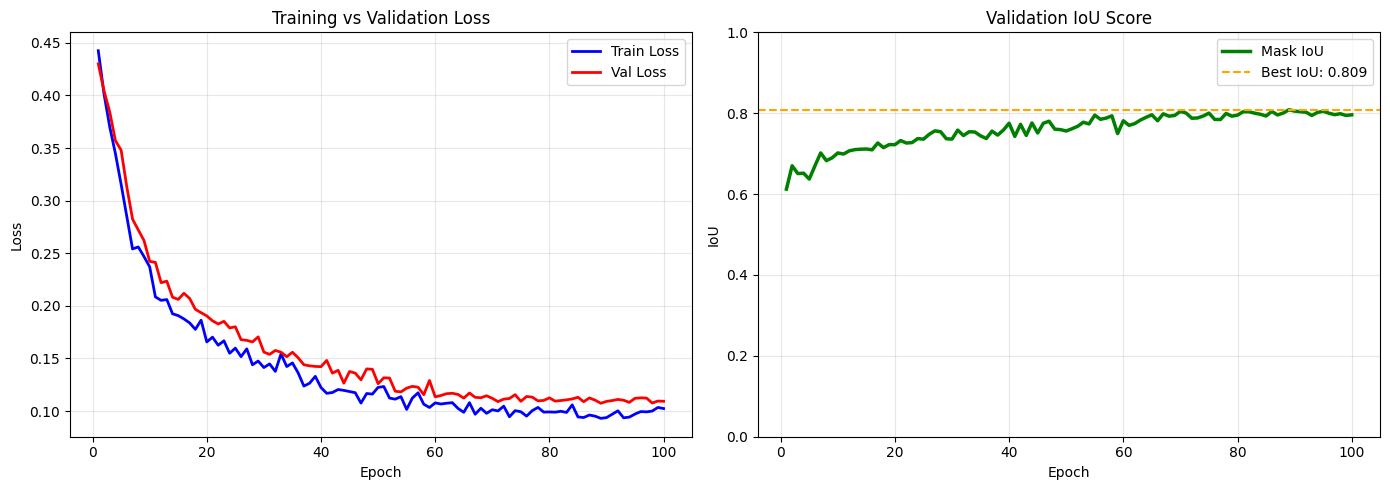

Final Mask IoU: 0.7960


In [12]:
# ---------------------------
# 9) Visualize Training Curves
# ---------------------------
try:
    if 'train_losses' in globals() and len(train_losses) > 0:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        epochs = range(1, len(train_losses) + 1)

        # Plot 1: Loss
        axes[0].plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2)
        axes[0].plot(epochs, val_losses, 'r-', label='Val Loss', linewidth=2)
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Training vs Validation Loss')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Plot 2: IoU (Mask Only)
        axes[1].plot(epochs, val_ious, 'g-', label='Mask IoU', linewidth=2.5)

        axes[1].axhline(y=best_iou, color='orange', linestyle='--', label=f'Best IoU: {best_iou:.3f}')
        axes[1].set_title('Validation IoU Score')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('IoU')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        axes[1].set_ylim([0, 1])

        plt.tight_layout()
        plt.show()

        print(f"Final Mask IoU: {val_ious[-1]:.4f}")
    else:
        print("⚠️ Training history is empty.")
except NameError:
    print("⚠️ Training history not available.")

In [13]:
# ---------------------------
# 10) Fine-Tuning (The "Cool Down" Phase)
# ---------------------------
print("\n🥶 Starting Fine-Tuning (Low LR, No Augmentation)...")

# 1. Load the BEST weights from the main training
# (Critical: Start from the best point, not the last point)
if os.path.exists(save_path):
    model.load_state_dict(torch.load(save_path))
    print("Loaded best weights from main training.")
else:
    print("⚠️ Warning: No saved weights found. Fine-tuning from current state.")

# 2. Use a smaller Learning Rate (10x - 50x smaller)
ft_optimizer = optim.Adam(model.parameters(), lr=1e-5)

# 3. Create a non-augmented train loader (The "Real" Distribution)
ft_dataset = DepthDentDataset(train_pairs, augment=True) # <--- need to have AUGMENTATION, model dont memorize dent location
ft_loader = DataLoader(ft_dataset, batch_size=4, shuffle=True, num_workers=2)

# Initialize tracking
best_ft_iou = best_iou  # Start with the best IoU from main training
ft_save_path = save_path.replace(".pth", "_finetuned.pth")

# 4. Train for just 10 epochs
FT_EPOCHS = 10

for epoch in range(1, FT_EPOCHS+1):
    model.train()
    
    # --- 🩹 THE FIX: FREEZE BATCH NORM STATISTICS ---
    # This prevents the tiny batch size (4) from ruining the learned stats
    for module in model.modules():
        if isinstance(module, torch.nn.BatchNorm2d):
            module.eval()
    
    running_loss = 0.0

    for inp, mask in tqdm(ft_loader, desc=f"Fine-Tune {epoch}"):
        inp = inp.to(device)
        mask = mask.to(device)

        ft_optimizer.zero_grad()
        outputs = model(inp)
        loss = combined_loss(outputs, mask) # Uses same loss function
        loss.backward()
        ft_optimizer.step()

        running_loss += loss.item()

    # Check Validation (Standard IoU)
    model.eval()
    val_iou = 0.0
    n_batches = 0

    with torch.no_grad():
        for inp, mask in val_loader:
            inp = inp.to(device)
            mask = mask.to(device)
            outputs = model(inp)
            val_iou += iou_score_batch(outputs, mask)
            n_batches += 1

    val_iou /= n_batches
    avg_loss = running_loss / len(ft_loader)

    print(f"FT Epoch {epoch} -> Loss: {avg_loss:.4f} | Val IoU: {val_iou:.4f}")

    # Save ONLY if it beats the previous best record
    if val_iou > best_ft_iou:
        diff = val_iou - best_ft_iou
        best_ft_iou = val_iou
        torch.save(model.state_dict(), ft_save_path)
        print(f"✓ Upgrade! Model improved by +{diff:.4f}. Saved to {ft_save_path}")

print(f"Fine-Tuning Complete. Best Final IoU: {best_ft_iou:.4f}")


🥶 Starting Fine-Tuning (Low LR, No Augmentation)...
Loaded best weights from main training.


Fine-Tune 1: 100%|██████████| 157/157 [00:36<00:00,  4.27it/s]


FT Epoch 1 -> Loss: 0.0980 | Val IoU: 0.8016


Fine-Tune 2: 100%|██████████| 157/157 [00:36<00:00,  4.27it/s]


FT Epoch 2 -> Loss: 0.1011 | Val IoU: 0.7988


Fine-Tune 3: 100%|██████████| 157/157 [00:36<00:00,  4.28it/s]


FT Epoch 3 -> Loss: 0.0959 | Val IoU: 0.8156
✓ Upgrade! Model improved by +0.0070. Saved to /teamspace/studios/this_studio/output_scene_dataset_LA_0.01/predictions_6d/best_attention_unet_finetuned.pth


Fine-Tune 4: 100%|██████████| 157/157 [00:36<00:00,  4.26it/s]


FT Epoch 4 -> Loss: 0.0902 | Val IoU: 0.8098


Fine-Tune 5: 100%|██████████| 157/157 [00:36<00:00,  4.27it/s]


FT Epoch 5 -> Loss: 0.1023 | Val IoU: 0.8141


Fine-Tune 6: 100%|██████████| 157/157 [00:36<00:00,  4.27it/s]


FT Epoch 6 -> Loss: 0.1036 | Val IoU: 0.8064


Fine-Tune 7: 100%|██████████| 157/157 [00:36<00:00,  4.27it/s]


FT Epoch 7 -> Loss: 0.0879 | Val IoU: 0.7689


Fine-Tune 8: 100%|██████████| 157/157 [00:36<00:00,  4.27it/s]


FT Epoch 8 -> Loss: 0.0936 | Val IoU: 0.8023


Fine-Tune 9: 100%|██████████| 157/157 [00:36<00:00,  4.27it/s]


FT Epoch 9 -> Loss: 0.0953 | Val IoU: 0.8098


Fine-Tune 10: 100%|██████████| 157/157 [00:36<00:00,  4.27it/s]


FT Epoch 10 -> Loss: 0.0978 | Val IoU: 0.7846
Fine-Tuning Complete. Best Final IoU: 0.8156


In [14]:
# ---------------------------
# 11) Optimize Threshold
# ---------------------------
#### model.load_state_dict(torch.load(save_path)) # Load your best model


# LOGIC: Check if fine-tuned model exists, otherwise use base model
ft_save_path = save_path.replace(".pth", "_finetuned.pth")

if os.path.exists(ft_save_path):
    print(f"Loading Fine-Tuned Model: {os.path.basename(ft_save_path)}")
    model.load_state_dict(torch.load(ft_save_path))
else:
    print(f"Loading Base Model: {os.path.basename(save_path)}")
    model.load_state_dict(torch.load(save_path))

model.eval()


thresholds = np.arange(0.3, 0.8, 0.05)
best_thr = 0.5
best_val_iou = 0.0

print("Optimizing threshold on Validation Set...")
for thr in thresholds:
    iou_acc = 0.0
    n_batches = 0
    with torch.no_grad():
        for inp, mask in val_loader:
            inp = inp.to(device)
            mask = mask.to(device)
            outputs = model(inp)
            # Use the custom threshold here
            iou_acc += iou_score_batch(outputs, mask, thr=thr)
            n_batches += 1

    avg_iou = iou_acc / n_batches
    print(f"Thr: {thr:.2f} -> IoU: {avg_iou:.4f}")

    if avg_iou > best_val_iou:
        best_val_iou = avg_iou
        best_thr = thr

print(f"\n🏆 Best Threshold found: {best_thr:.2f} with IoU: {best_val_iou:.4f}")
print("Use this threshold for your final testing!")

Loading Fine-Tuned Model: best_attention_unet_finetuned.pth
Optimizing threshold on Validation Set...
Thr: 0.30 -> IoU: 0.8163
Thr: 0.35 -> IoU: 0.8162
Thr: 0.40 -> IoU: 0.8160
Thr: 0.45 -> IoU: 0.8158
Thr: 0.50 -> IoU: 0.8156
Thr: 0.55 -> IoU: 0.8154
Thr: 0.60 -> IoU: 0.8151
Thr: 0.65 -> IoU: 0.8149
Thr: 0.70 -> IoU: 0.8146
Thr: 0.75 -> IoU: 0.8144

🏆 Best Threshold found: 0.30 with IoU: 0.8163
Use this threshold for your final testing!


In [15]:
#HELPER CELL TO DO FILTER 35mm dent"
import numpy as np
import cv2

def filter_shallow_dents(pred_mask, depth_map_mm, threshold_mm=10.0):
    """
    Removes predicted dents that are shallower than threshold_mm.

    Args:
        pred_mask (np.array): Binary mask (0 or 1) from your model.
        depth_map_mm (np.array): The ORIGINAL depth map in millimeters.
        threshold_mm (float): The cutoff (e.g., 35mm).

    Returns:
        filtered_mask (np.array): The cleaned mask with shallow dents removed.
    """
    # 1. Identify separate dent "blobs" (connected components)
    # This separates Dent A from Dent B so we can measure them one by one.
    num_labels, labels_im = cv2.connectedComponents(pred_mask.astype(np.uint8))

    # 2. Calculate the Reference Level (Median of the Panel)
    # We take all pixels where the model did NOT predict a dent.
    background_mask = (pred_mask == 0)

    if np.sum(background_mask) == 0:
        # Edge case: If model predicts the WHOLE image is a dent, return original
        return pred_mask

    reference_median = np.median(depth_map_mm[background_mask])

    # Create an empty mask for the final result
    filtered_mask = np.zeros_like(pred_mask)

    # 3. Check each dent candidate
    # Label 0 is the background, so we start loop at 1
    for label_id in range(1, num_labels):
        # Create a mask for JUST this current dent
        current_dent_mask = (labels_im == label_id)

        # Get the depth values for pixels inside this dent
        dent_pixel_values = depth_map_mm[current_dent_mask]

        # 4. Find the "Deepest Point" relative to the median
        # We look for the maximum absolute difference
        deviations = np.abs(dent_pixel_values - reference_median)
        max_dent_depth = np.max(deviations)

        # 5. The Decision: Keep or Discard?
        if max_dent_depth >= threshold_mm:
            # It's a real dent (>35mm), copy it to the final mask
            filtered_mask[current_dent_mask] = 1
        # else:
            # It's too shallow (<35mm), do nothing (remains 0)

    return filtered_mask

In [16]:
# ---------------------------
# 12) Final Test: TTA, Metrics & Saving (UPDATED)
# ---------------------------
import os
import cv2
import numpy as np
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader

print("\n================ TEST EVALUATION (W/ TTA) & SAVING ================\n")

# 1. Setup Output Directory
pred_out_dir = os.path.join(OUT_DIR, "batch_preds")
os.makedirs(pred_out_dir, exist_ok=True)
print(f"Saving outputs to: {pred_out_dir}")

# 2. Load Data & Model
save_path = os.path.join(OUT_DIR, "best_attention_unet.pth")

print(f"Testing with Base Model: {os.path.basename(save_path)}")
model.load_state_dict(torch.load(save_path, map_location=device))

model.eval()

test_ds = DepthDentDataset(test_pairs, augment=False)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, num_workers=2)

# 3. Metrics Trackers
test_iou = 0.0
test_dice = 0.0
test_prec = 0.0
test_rec = 0.0
n_batches = 0
total_file_idx = 0

# 4. Post-processing Kernel
kernel = np.ones((3,3), np.uint8)

with torch.no_grad():
    for inp, mask in tqdm(test_loader, desc="Testing & Saving"):
        inp = inp.to(device)
        mask = mask.to(device)

        # --- A. Test-Time Augmentation (TTA) ---
        pred_standard = torch.sigmoid(model(inp))

        inp_h = torch.flip(inp, [3])      # Flip Horizontally
        out_h = torch.sigmoid(model(inp_h))
        pred_h = torch.flip(out_h, [3])   # Flip Back

        inp_v = torch.flip(inp, [2])      # Flip Vertically
        out_v = torch.sigmoid(model(inp_v))
        pred_v = torch.flip(out_v, [2])   # Flip Back

        # Average them
        outputs = (pred_standard + pred_h + pred_v) / 3.0

        # --- B. Calculate Metrics ---
        test_iou  += iou_score_batch(outputs, mask, thr=best_thr)
        test_dice += dice_score_batch(outputs, mask, thr=best_thr)
        test_prec += precision_batch(outputs, mask, thr=best_thr)
        test_rec  += recall_batch(outputs, mask, thr=best_thr)
        n_batches += 1

        # --- C. Save Outputs (NPY + PNG) ---
        preds_prob = outputs.cpu().numpy() # (B, 1, H, W)
        inputs_np = inp.cpu().numpy()      # (B, 3, H, W)
        masks_np = mask.cpu().numpy()      # (B, 1, H, W)

        batch_size = inputs_np.shape[0]

        for i in range(batch_size):
            if total_file_idx >= len(test_pairs): break
            original_path = test_pairs[total_file_idx][0]
            base = os.path.basename(original_path).replace("_dented_depth.npy", "")

            # 1. Prepare Data
            depth_img = (inputs_np[i, 0] * 255).astype(np.uint8)
            gt_img = (masks_np[i, 0] * 255).astype(np.uint8)

            # Raw Thresholding
            pred_raw = (preds_prob[i, 0] > best_thr).astype(np.uint8)

            # Morphology Cleaning
            pred_clean = cv2.morphologyEx(pred_raw, cv2.MORPH_OPEN, kernel, iterations=1)
            pred_clean = cv2.morphologyEx(pred_clean, cv2.MORPH_CLOSE, kernel, iterations=1)

            # --- SAVE NPY (CRITICAL STEP FOR DEPTH MEASUREMENT) ---
            # Save the clean binary mask (0s and 1s)
            np.save(os.path.join(pred_out_dir, base + "_pred.npy"), pred_clean)

            # --- SAVE PNG (FOR VISUALIZATION) ---
            pred_img = pred_clean * 255 # Scale to 255 for eyes

            cv2.imwrite(os.path.join(pred_out_dir, base + "_pred.png"), pred_img)
            cv2.imwrite(os.path.join(pred_out_dir, base + "_gt_depth.png"), depth_img)
            cv2.imwrite(os.path.join(pred_out_dir, base + "_gt_mask.png"), gt_img)

            # Side-by-Side
            if gt_img.shape != depth_img.shape:
                gt_img = cv2.resize(gt_img, (depth_img.shape[1], depth_img.shape[0]), interpolation=cv2.INTER_NEAREST)

            side_by_side = np.hstack([depth_img, gt_img, pred_img])
            cv2.imwrite(os.path.join(pred_out_dir, base + "_compare.png"), side_by_side)

            total_file_idx += 1

# 5. Print Final Averaged Metrics
avg_test_iou  = test_iou / n_batches
avg_test_dice = test_dice / n_batches
avg_test_prec = test_prec / n_batches
avg_test_rec  = test_rec / n_batches

print("\n========== MODEL TEST RESULTS (With TTA) ==========")
print(f"Threshold used: {best_thr:.2f}")
print(f"Test IoU      : {avg_test_iou:.4f}")
print(f"Test Dice     : {avg_test_dice:.4f}")
print(f"Test Precision: {avg_test_prec:.4f}")
print(f"Test Recall   : {avg_test_rec:.4f}")
print(f"✅ Images and NPY files saved to: {pred_out_dir}")
print("===================================================\n")


================ TEST EVALUATION (W/ TTA) & SAVING ================

Saving outputs to: /teamspace/studios/this_studio/output_scene_dataset_LA_0.01/predictions_6d/batch_preds
Testing with Base Model: best_attention_unet.pth


Testing & Saving: 100%|██████████| 34/34 [00:09<00:00,  3.45it/s]


========== MODEL TEST RESULTS (With TTA) ==========
Threshold used: 0.30
Test IoU      : 0.7287
Test Dice     : 0.7990
Test Precision: 0.8173
Test Recall   : 0.8867
✅ Images and NPY files saved to: /teamspace/studios/this_studio/output_scene_dataset_LA_0.01/predictions_6d/batch_preds



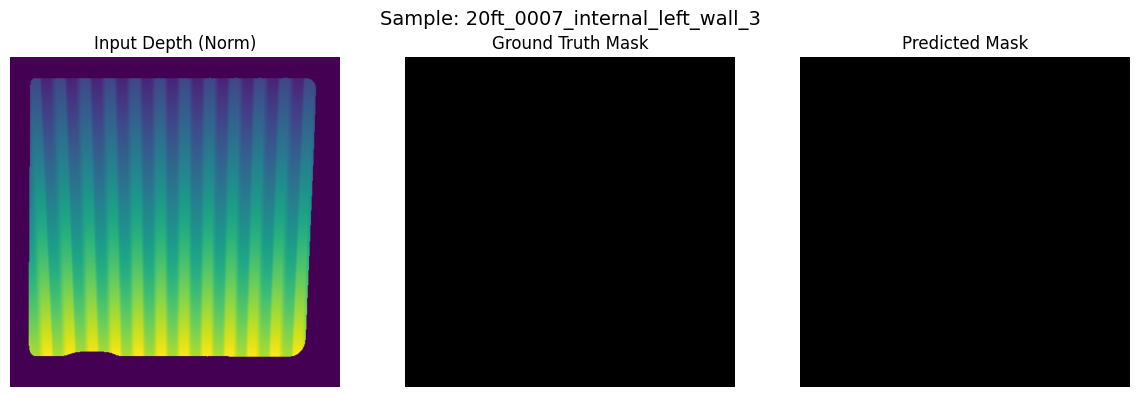

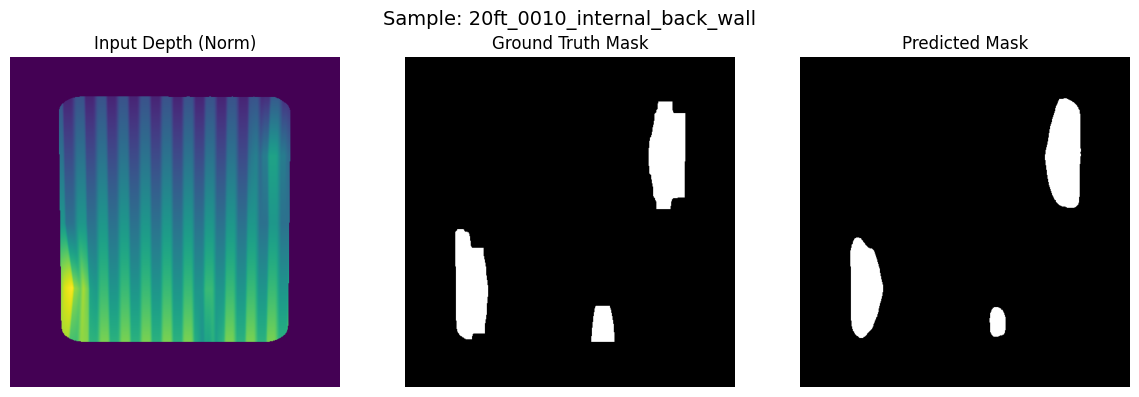

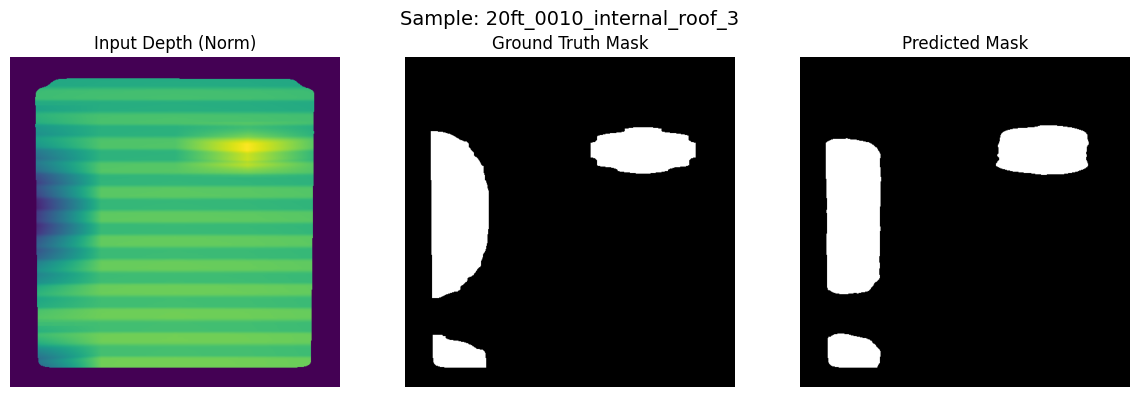

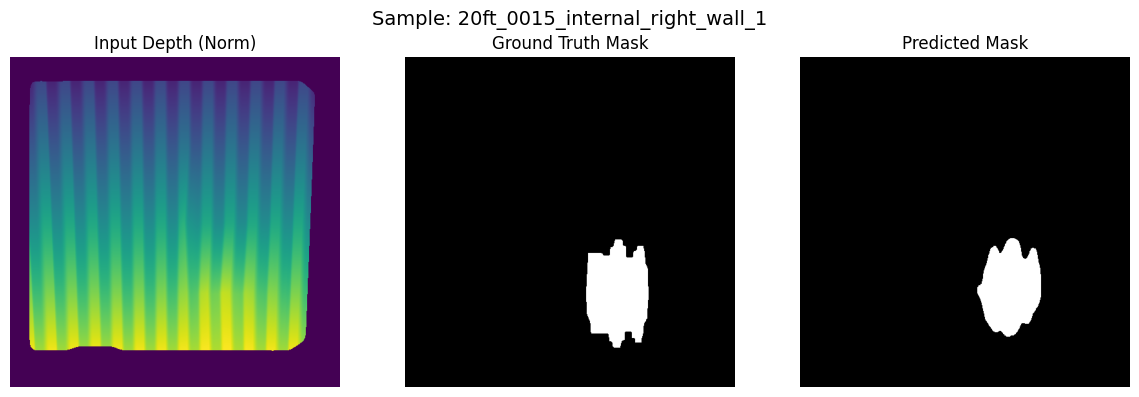

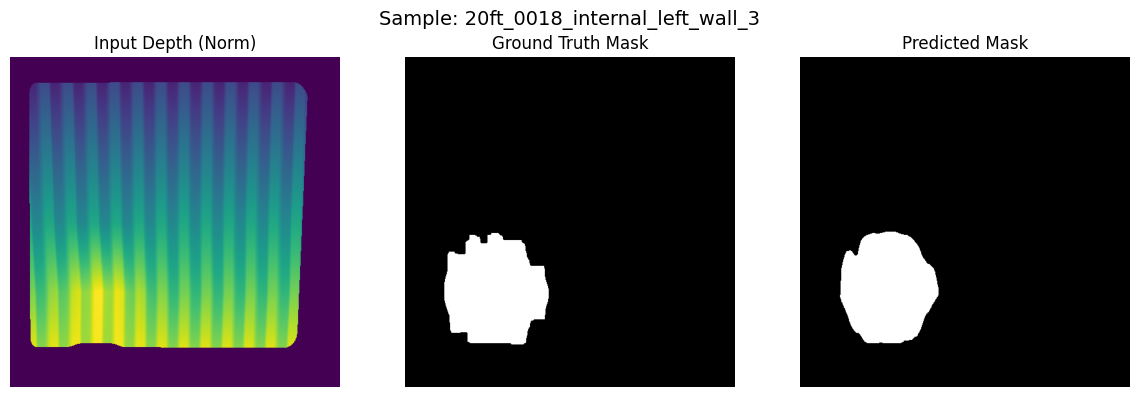

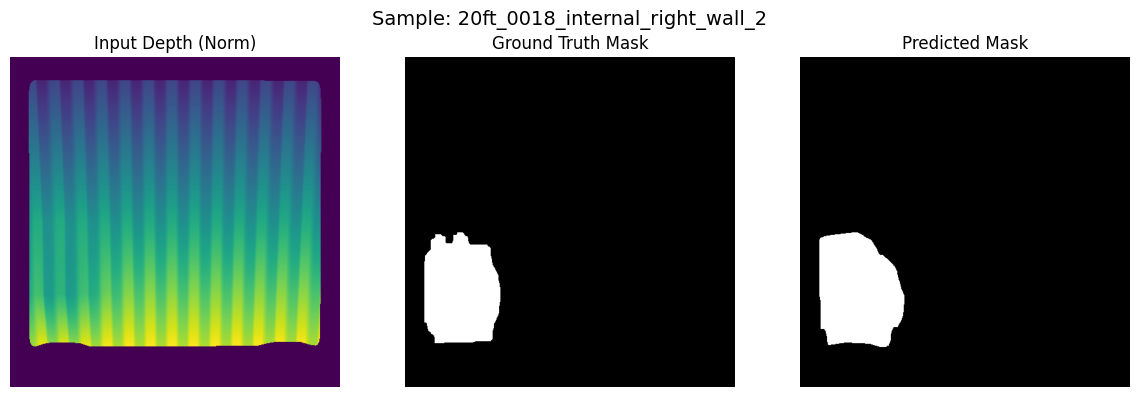

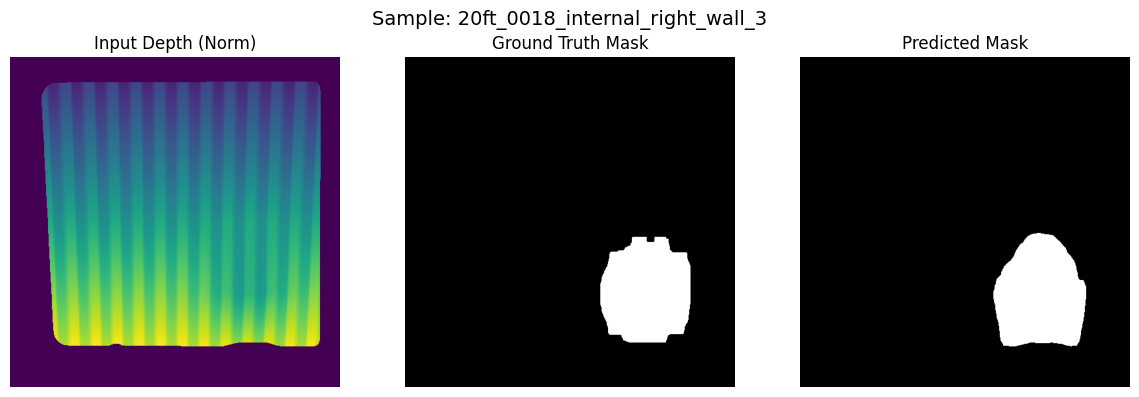

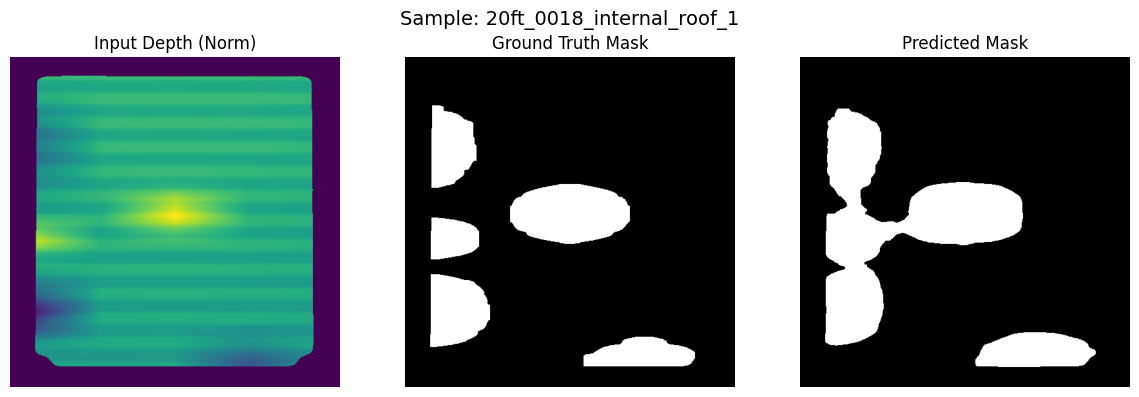

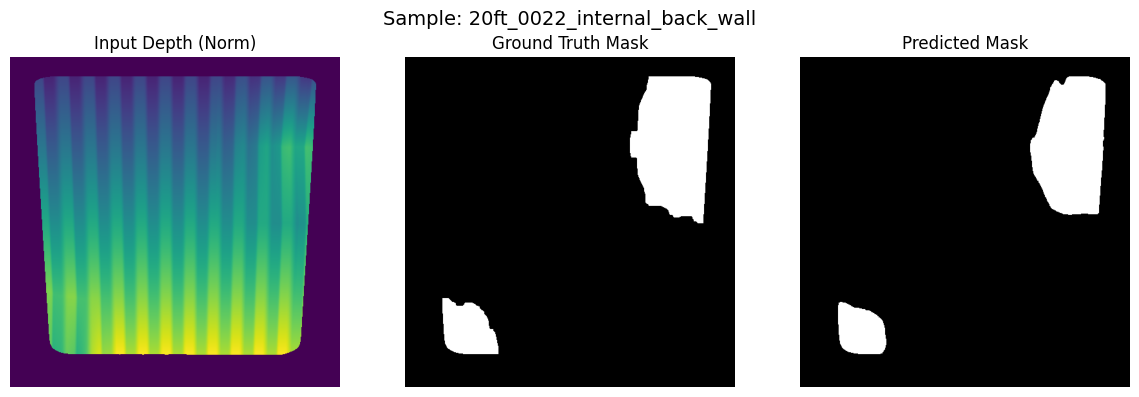

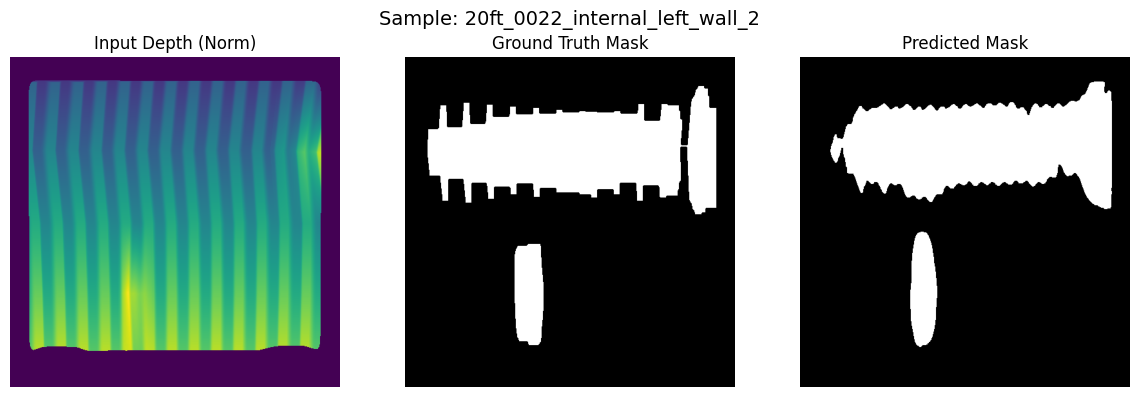

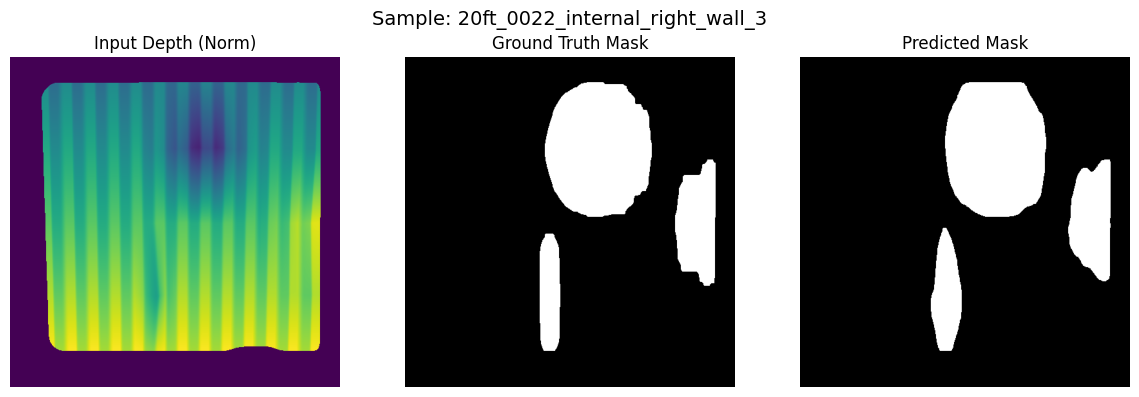

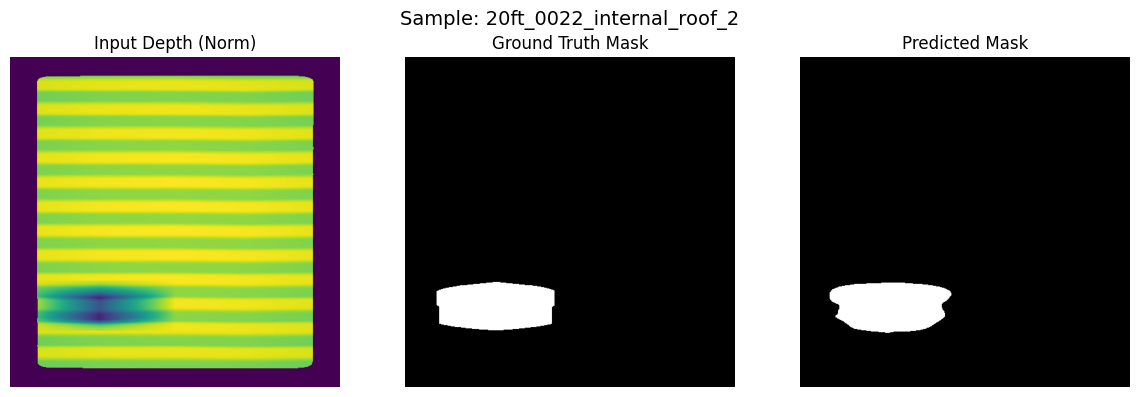

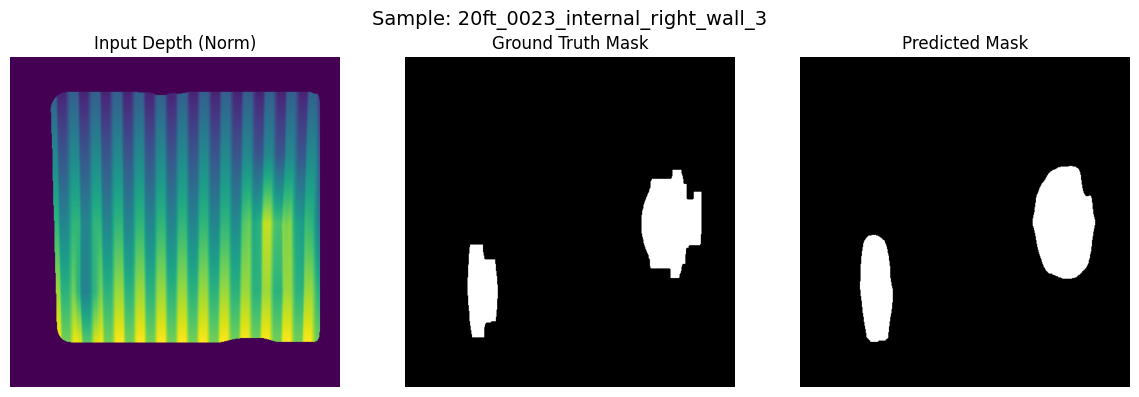

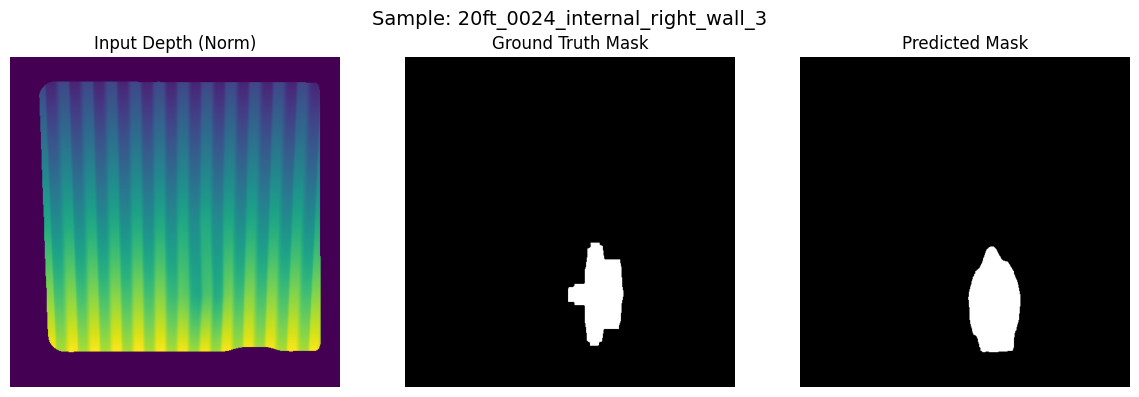

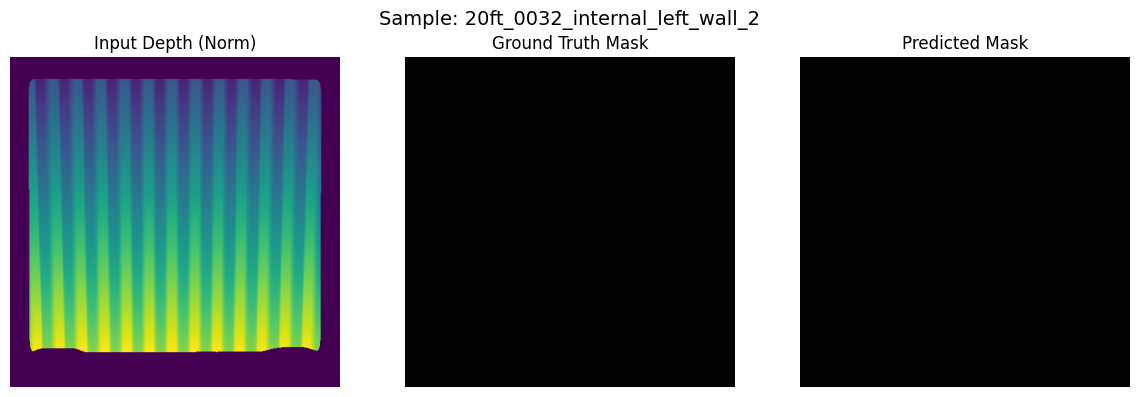

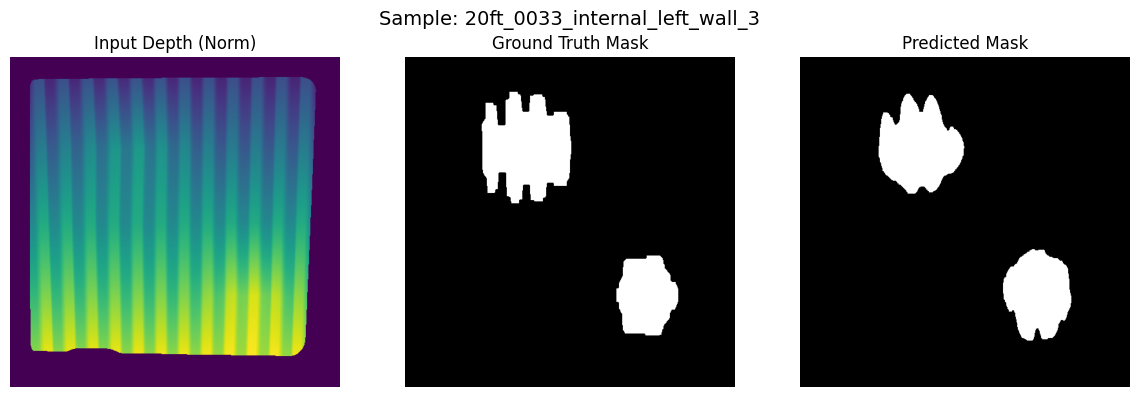

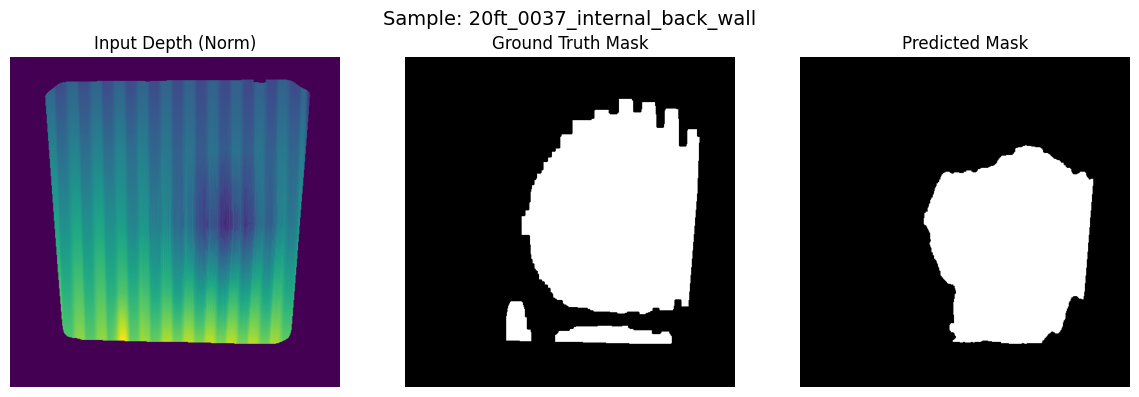

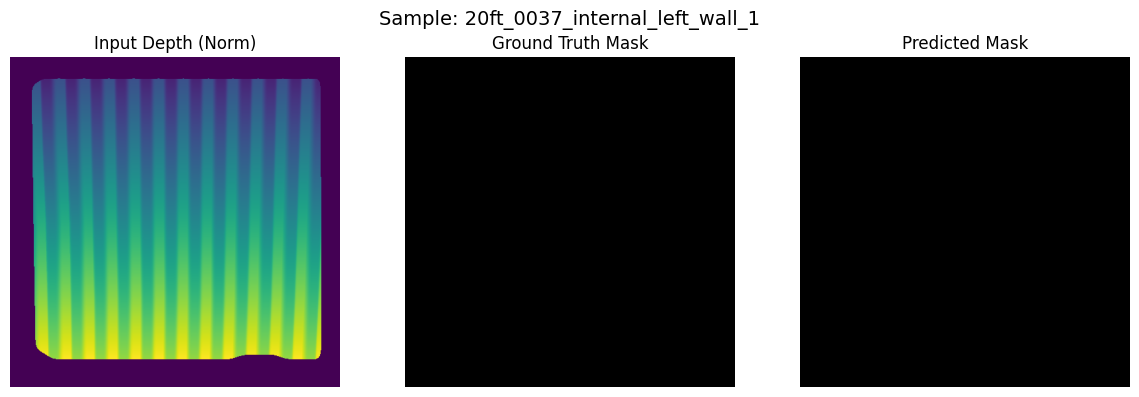

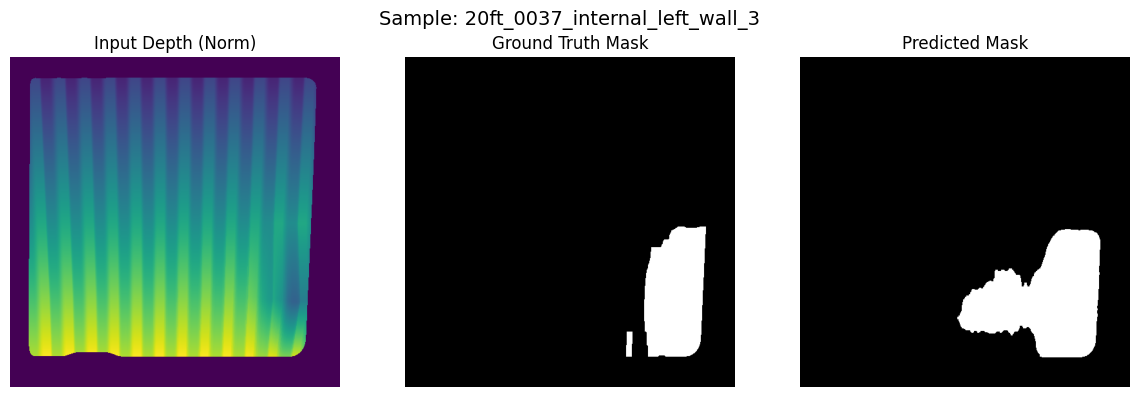

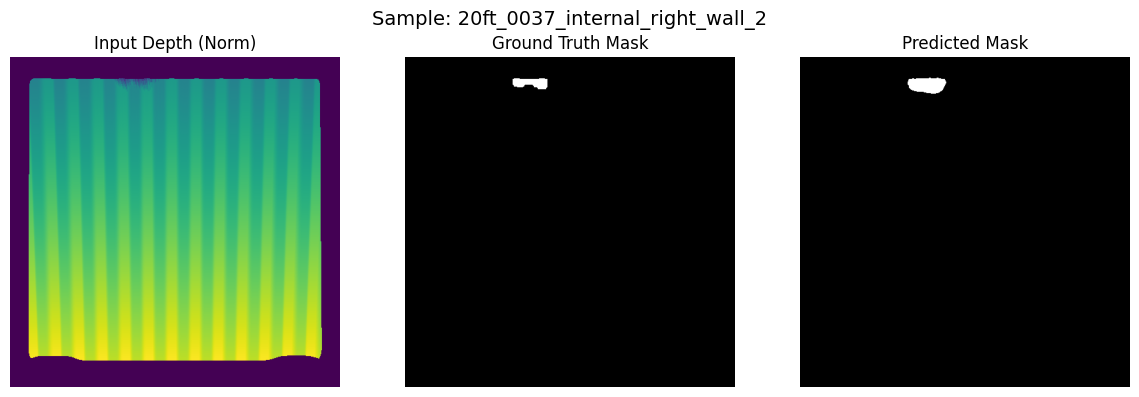

In [17]:
# ---------------------------
# 13) Visualization of Results
# ---------------------------
import matplotlib.pyplot as plt

# Get the list of prediction images we just saved
pred_files = sorted(glob.glob(os.path.join(pred_out_dir, "*_pred.png")))

# Pick random 3 or take first 3
num_to_show = min(20, len(pred_files))
vis_samples = pred_files[:num_to_show]

if len(vis_samples) == 0:
    print("No predictions found to visualize.")
else:
    for i, pred_path in enumerate(vis_samples):
        # Derive paths based on naming convention in Step 9
        base = os.path.basename(pred_path).replace("_pred.png", "")

        # Load Depth (Visual)
        depth_vis_path = os.path.join(pred_out_dir, base + "_gt_depth.png")
        if os.path.exists(depth_vis_path):
            depth_img = cv2.imread(depth_vis_path, cv2.IMREAD_GRAYSCALE)
        else:
            depth_img = np.zeros((256,256), dtype=np.uint8) # Fallback

        # Load GT Mask
        gt_mask_path = os.path.join(pred_out_dir, base + "_gt_mask.png")
        if os.path.exists(gt_mask_path):
            gt_mask_img = cv2.imread(gt_mask_path, cv2.IMREAD_GRAYSCALE)
        else:
            gt_mask_img = np.zeros_like(depth_img)

        # Load Prediction
        pred_img = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)

        # Plot
        plt.figure(figsize=(12, 4))
        plt.suptitle(f"Sample: {base}", fontsize=14)

        plt.subplot(1, 3, 1)
        plt.title("Input Depth (Norm)")
        plt.imshow(depth_img, cmap="viridis")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("Ground Truth Mask")
        plt.imshow(gt_mask_img, cmap="gray")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(pred_img, cmap="gray")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

🔍 Scanning test set for worst performers...

📉 Displaying the Bottom 20 Predictions (Lowest IoU):


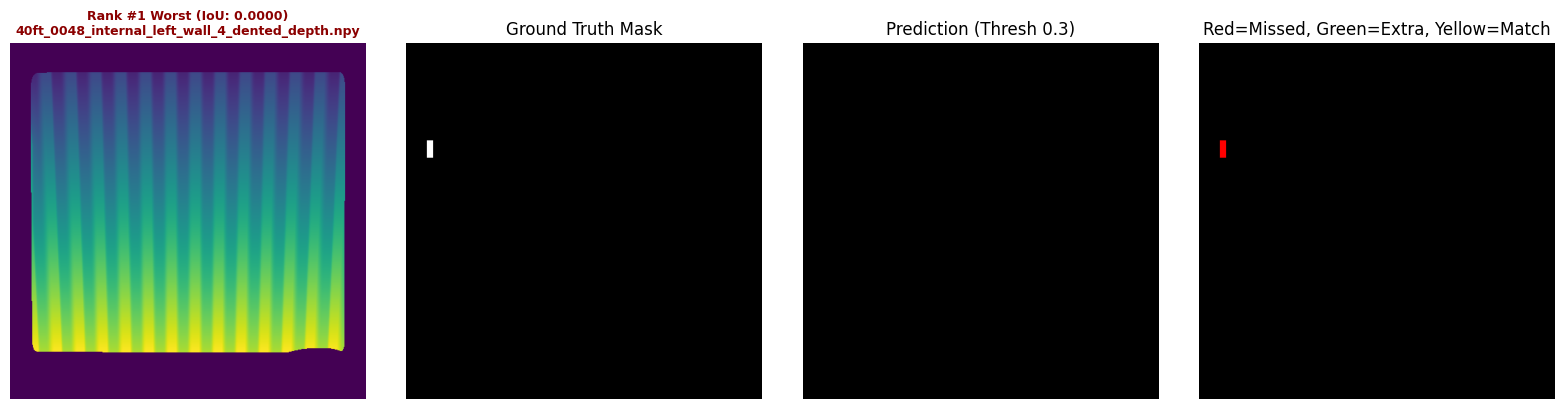

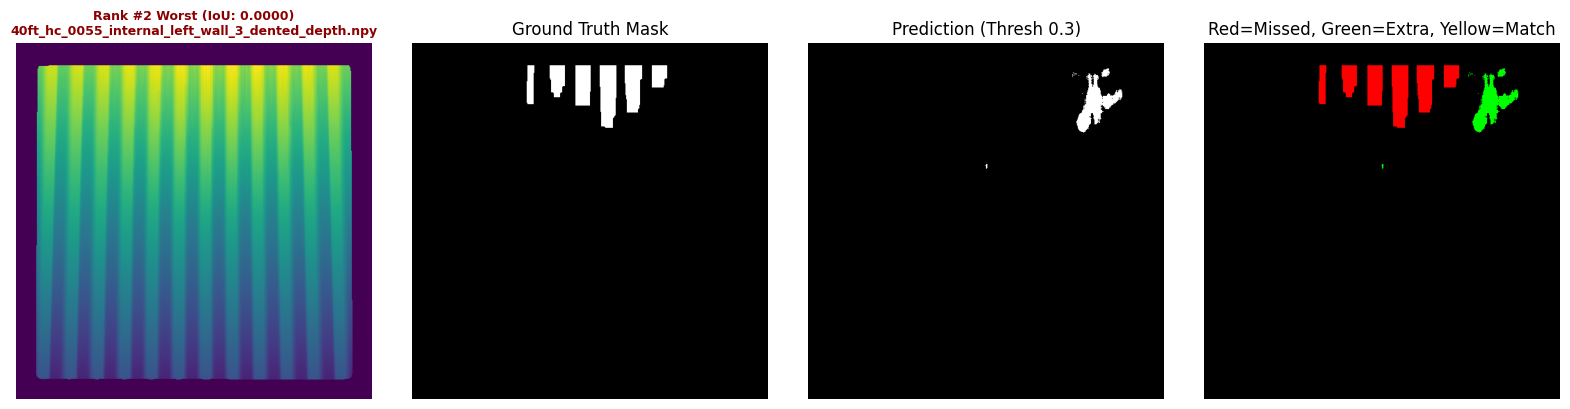

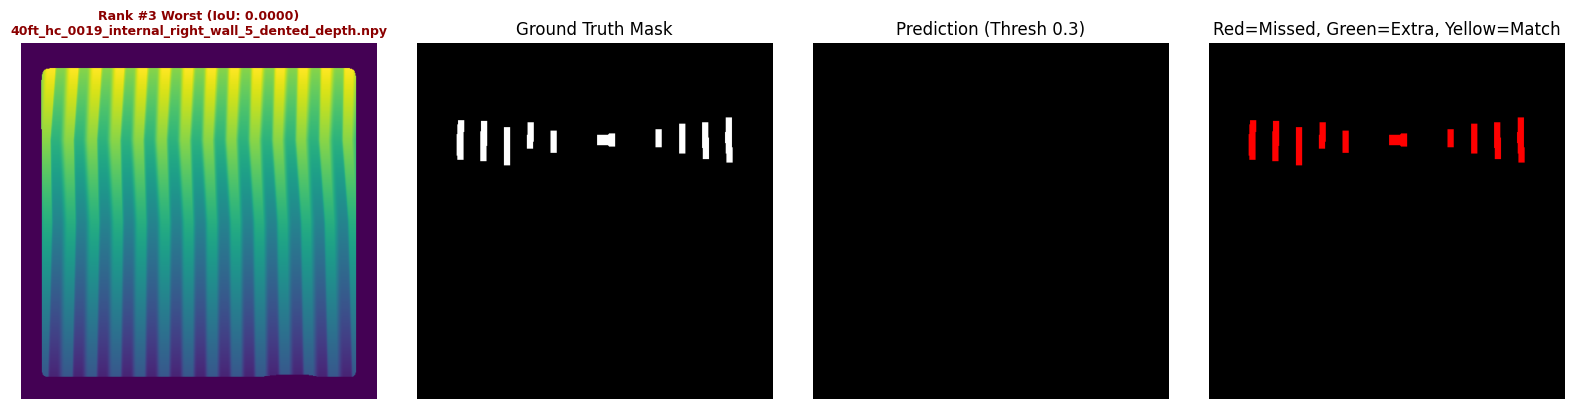

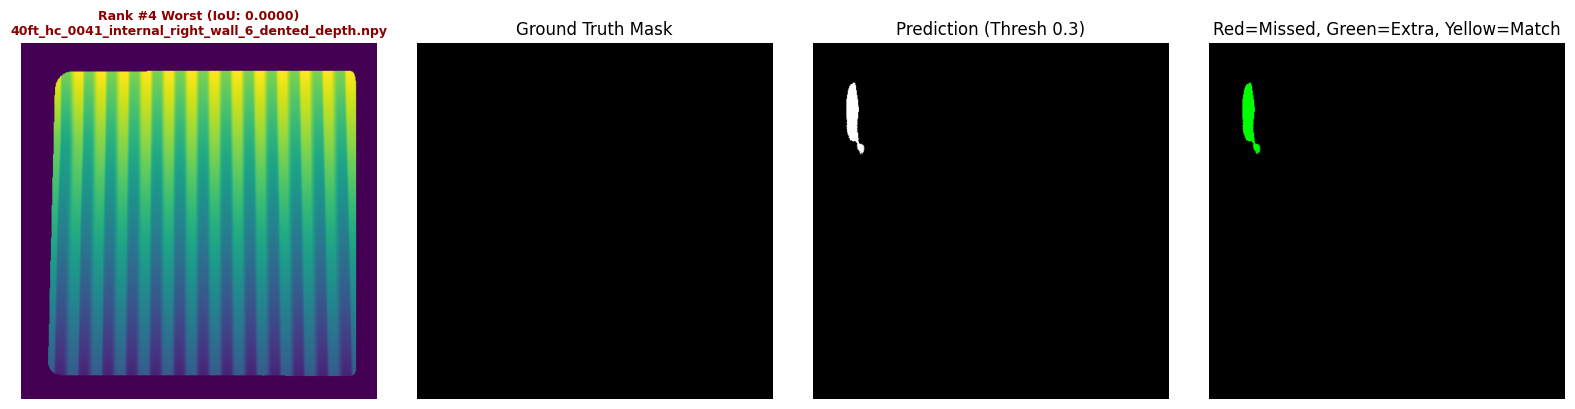

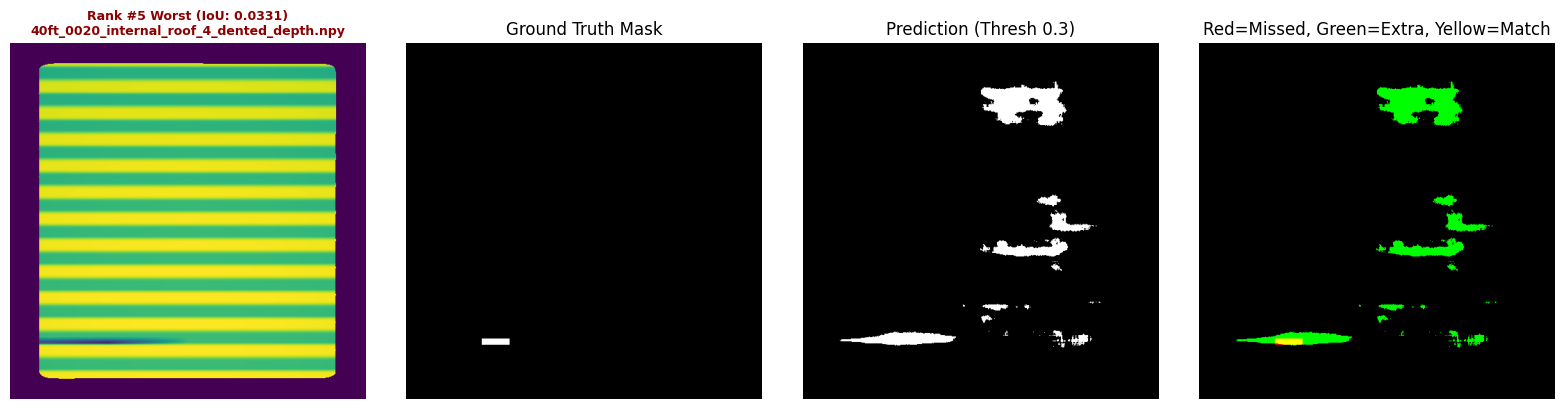

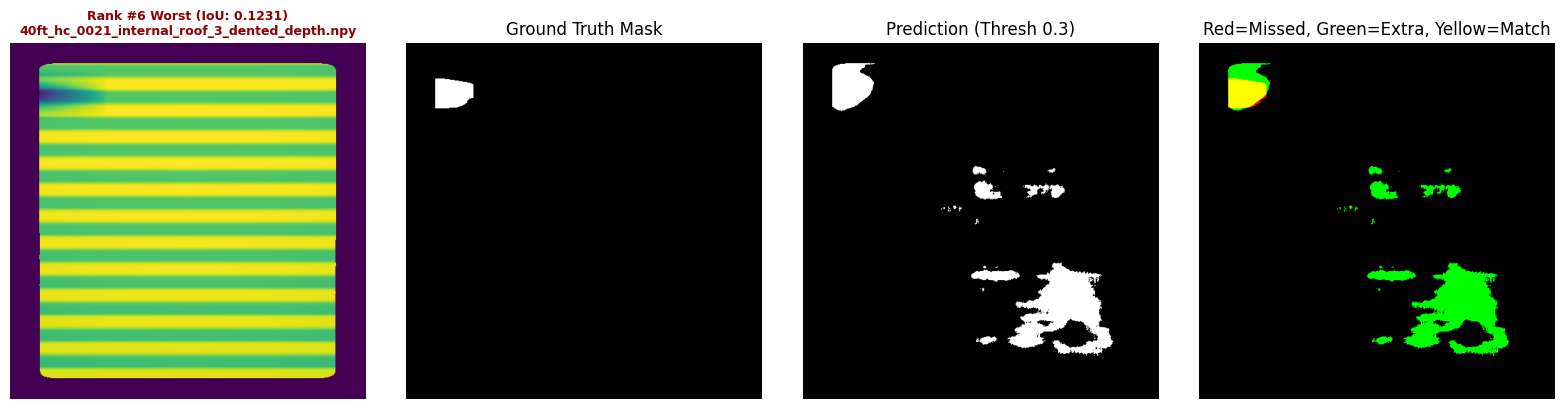

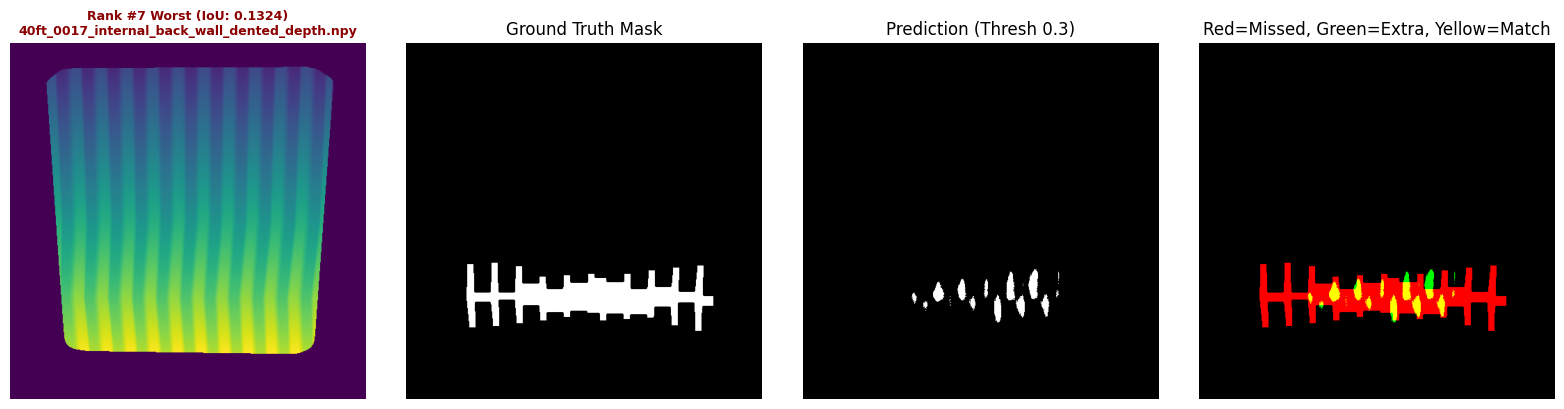

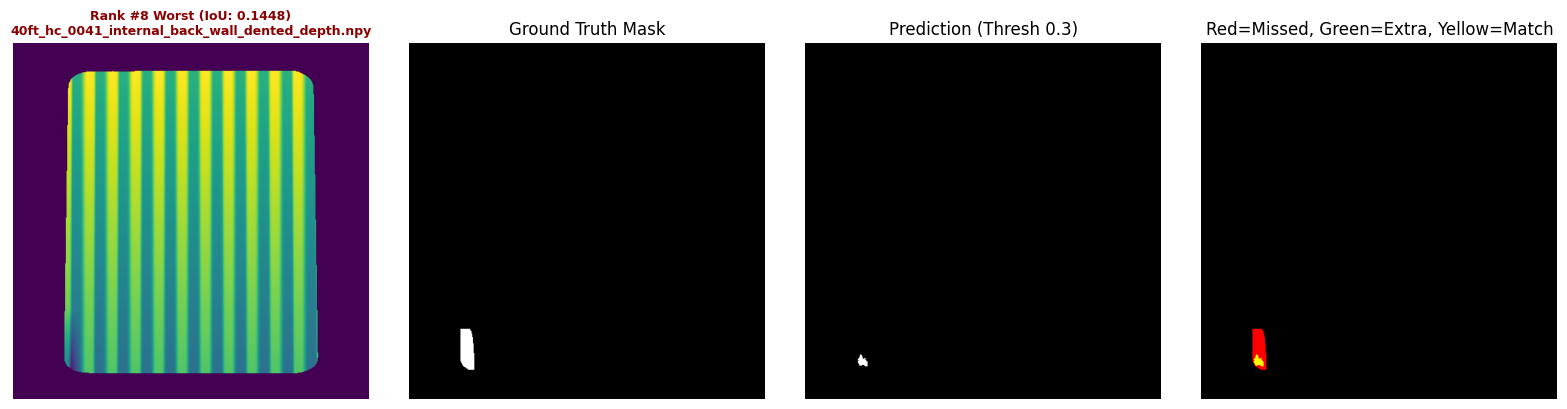

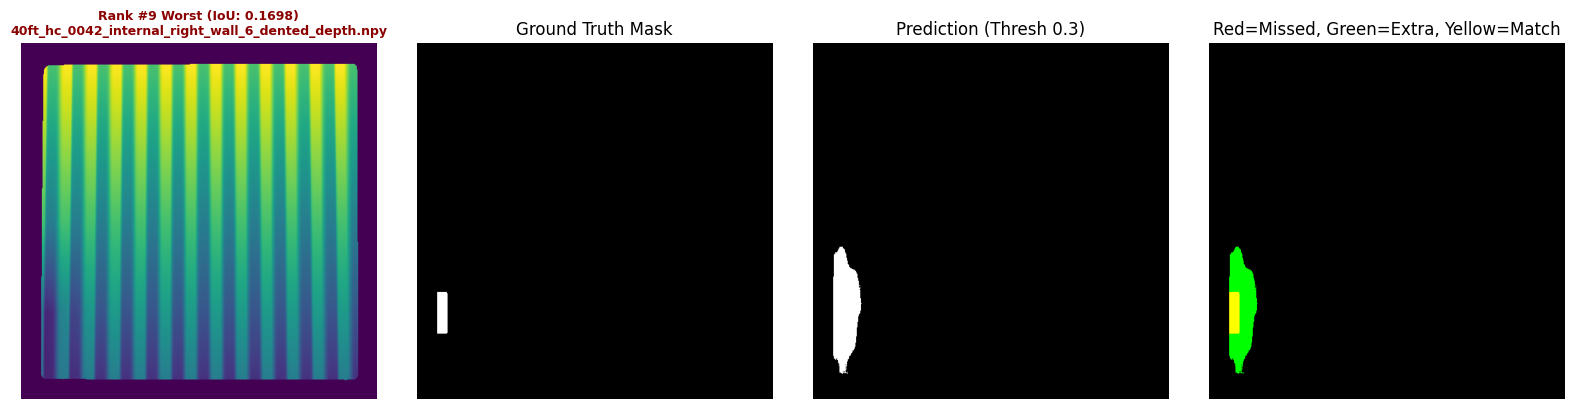

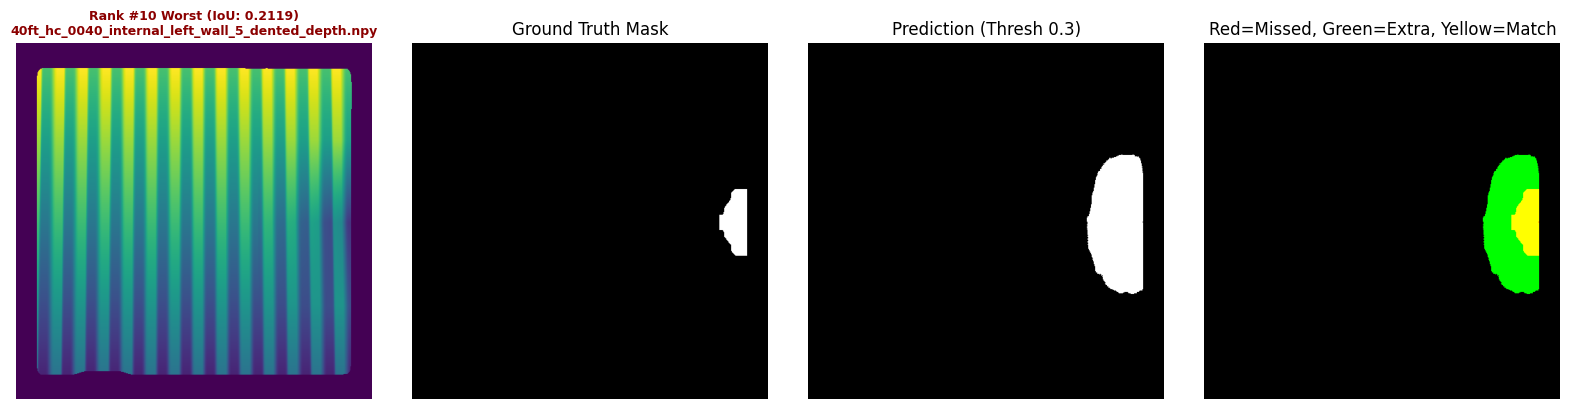

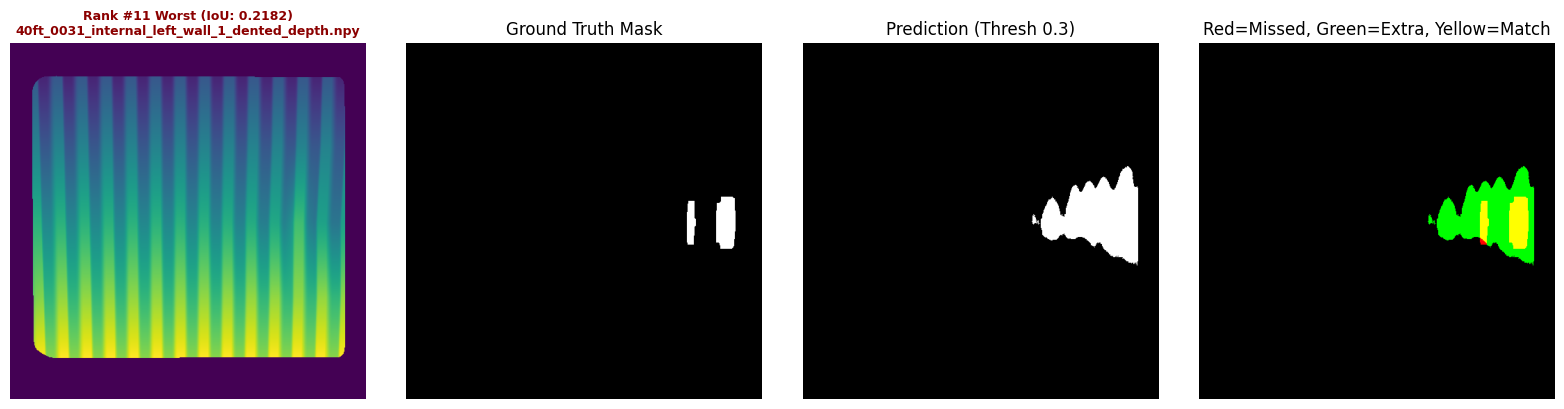

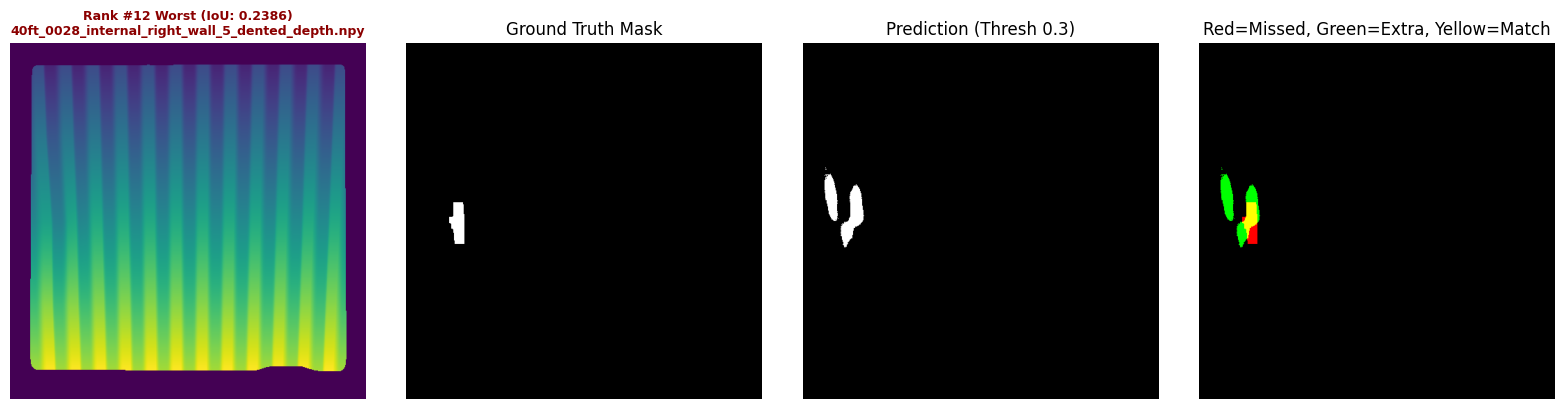

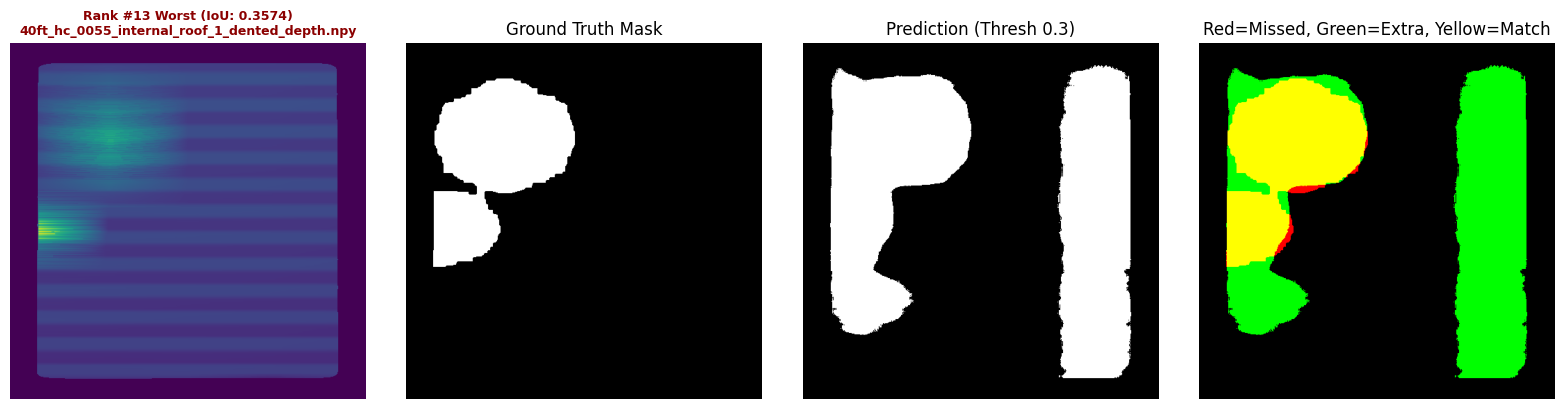

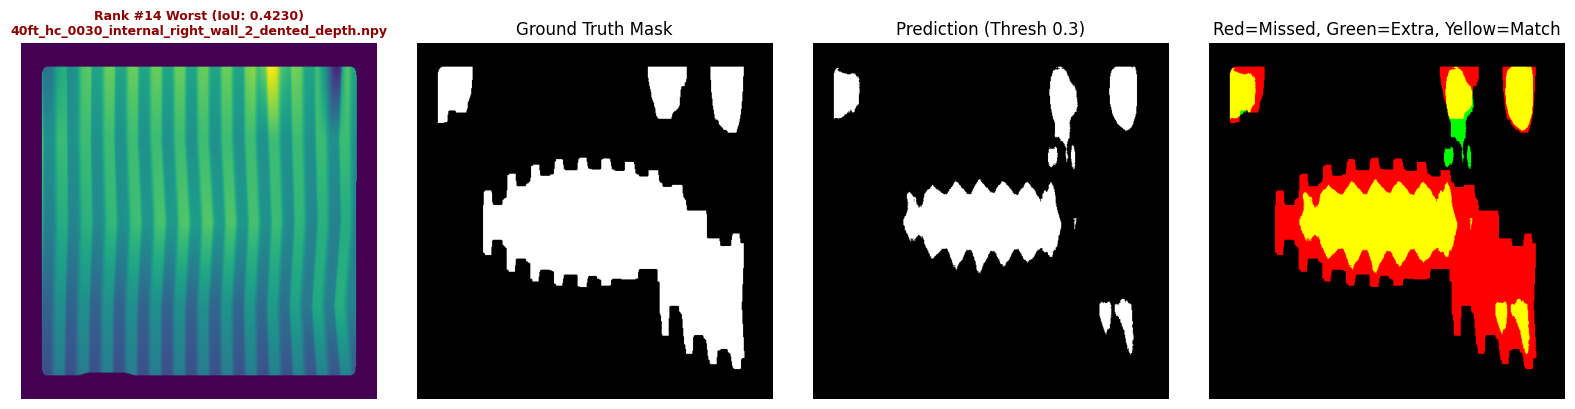

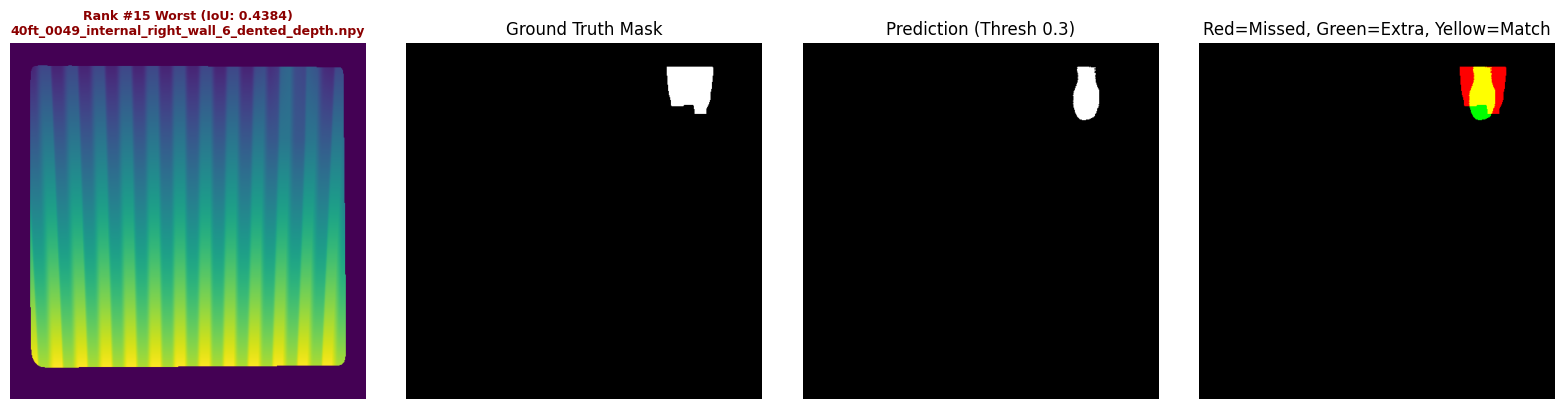

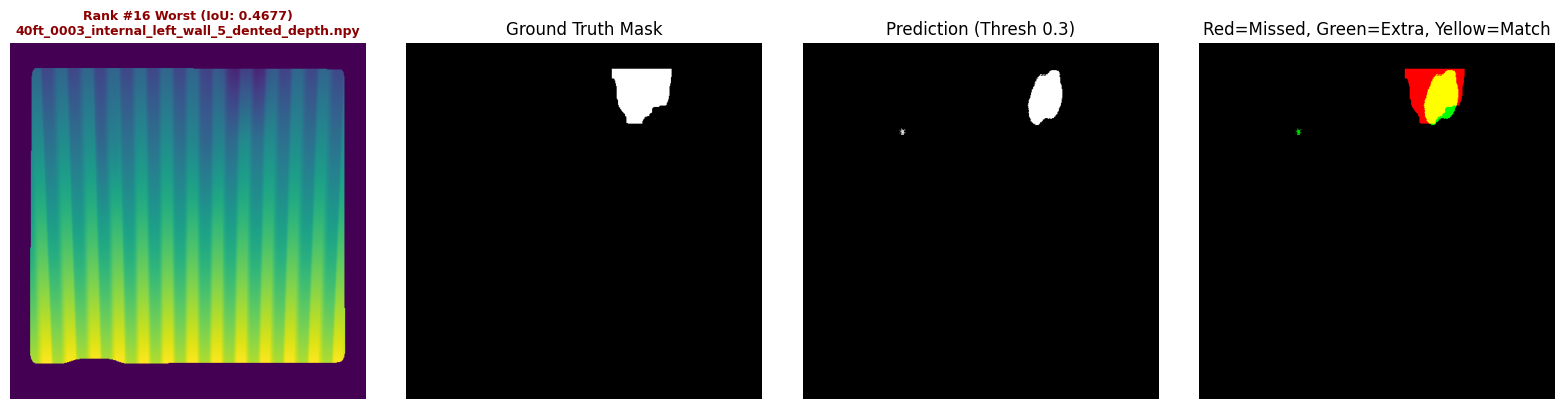

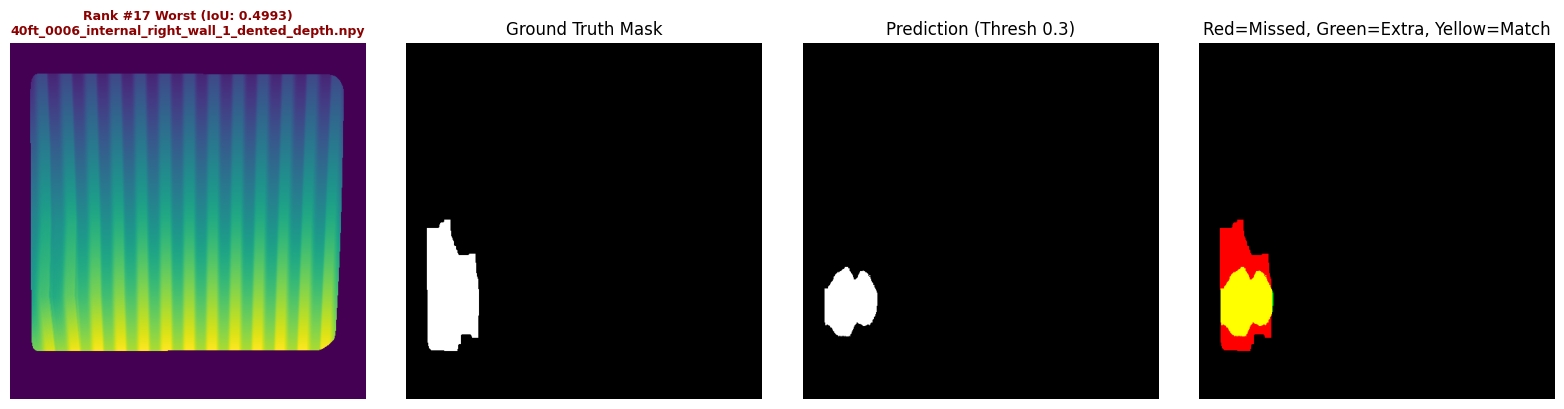

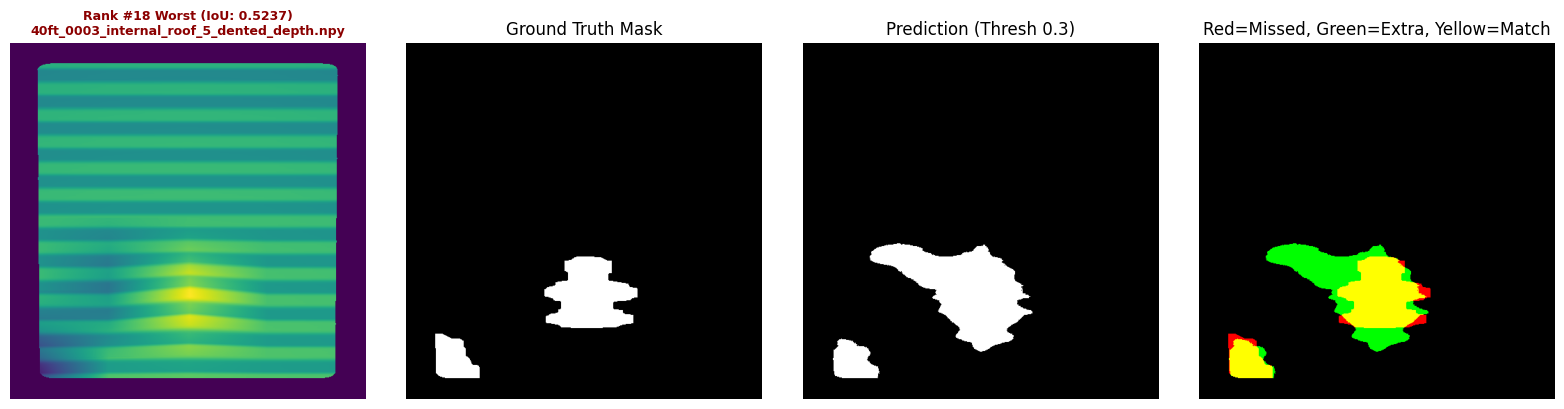

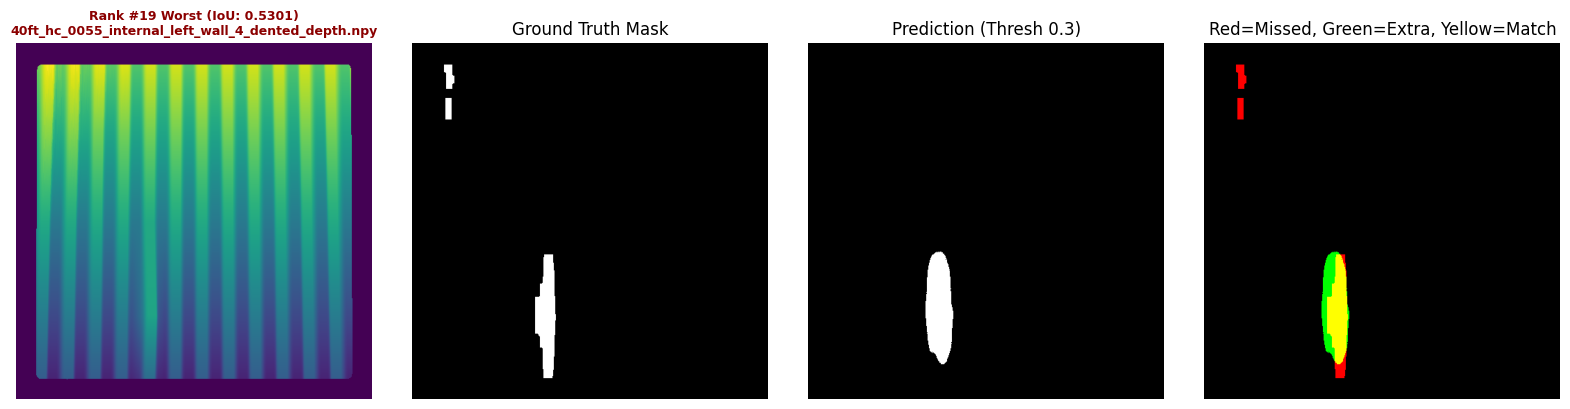

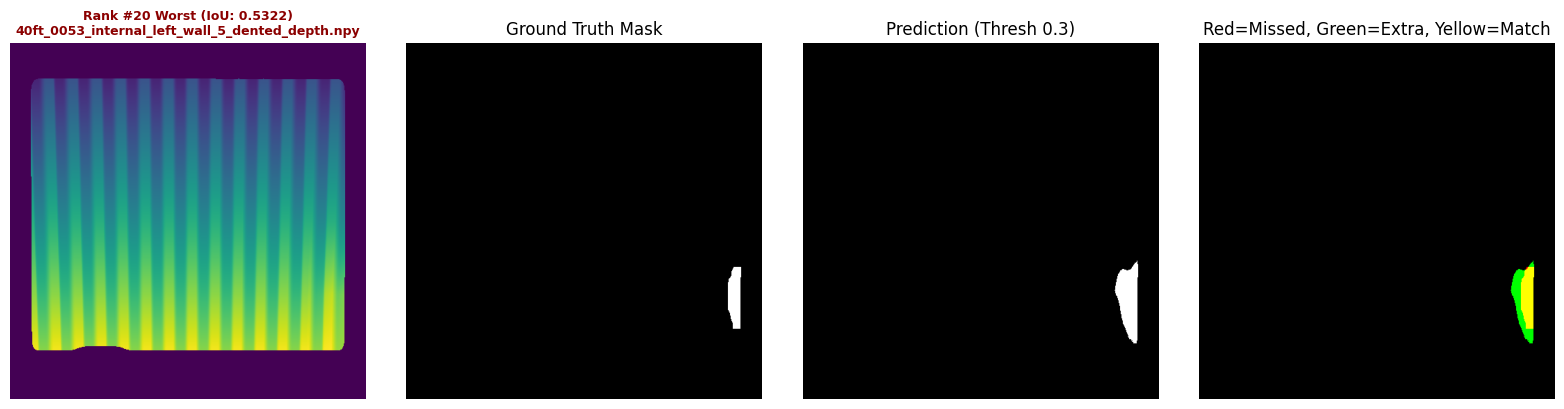

In [18]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import os

# --- CONFIGURATION ---
MODEL_TO_USE = model  # Ensure this is your loaded 'best_attention_unet_finetuned'
DATALOADER = test_loader
THRESHOLD = 0.30  # The threshold we decided on
NUM_WORST_TO_SHOW = 20 # Reduced slightly to make plots larger

def calculate_iou_single(pred_mask, true_mask):
    """Calculates IoU for a single image pair."""
    intersection = np.logical_and(pred_mask, true_mask).sum()
    union = np.logical_or(pred_mask, true_mask).sum()
    if union == 0:
        return 1.0 if intersection == 0 else 0.0 # Handle empty masks
    return intersection / union

# 1. Collect Results
results = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_TO_USE.eval()

# Get batch size to calculate indices
batch_size = DATALOADER.batch_size

print("🔍 Scanning test set for worst performers...")

with torch.no_grad():
    for batch_idx, (images, masks) in enumerate(DATALOADER):
        images = images.to(device)

        # Standard Inference
        outputs = MODEL_TO_USE(images)
        probs = torch.sigmoid(outputs)

        # Convert to Numpy
        images_np = images.cpu().numpy()
        masks_np = masks.cpu().numpy()
        probs_np = probs.cpu().numpy()

        for i in range(images.shape[0]):
            # --- NEW: Get Filename ---
            # We calculate the global index in the dataset list
            # Note: This assumes test_loader has shuffle=False
            global_idx = batch_idx * batch_size + i
            
            try:
                # Access the original path from the dataset sample list
                # [0] is the depth path, [1] is the mask path
                full_path = DATALOADER.dataset.samples[global_idx][0]
                filename = os.path.basename(full_path)
            except:
                filename = f"Index_{global_idx}"
            # -------------------------

            # Get individual sample data
            img = images_np[i, 0, :, :]
            true_mask = masks_np[i, 0, :, :]
            pred_prob = probs_np[i, 0, :, :]

            # Apply Threshold
            pred_mask = (pred_prob > THRESHOLD).astype(np.uint8)

            # Calculate Score
            iou = calculate_iou_single(pred_mask, true_mask)

            # Store everything
            results.append({
                "iou": iou,
                "image": img,
                "true_mask": true_mask,
                "pred_mask": pred_mask,
                "filename": filename # <--- Store filename
            })

# 2. Sort by IoU (Ascending: Worst first)
results.sort(key=lambda x: x["iou"])

# 3. Visualize
print(f"\n📉 Displaying the Bottom {NUM_WORST_TO_SHOW} Predictions (Lowest IoU):")

for i in range(NUM_WORST_TO_SHOW):
    res = results[i]

    plt.figure(figsize=(16, 4))

    # Input Depth
    plt.subplot(1, 4, 1)
    # --- UPDATED TITLE ---
    plt.title(f"Rank #{i+1} Worst (IoU: {res['iou']:.4f})\n{res['filename']}", 
              fontsize=9, color='darkred', fontweight='bold')
    plt.imshow(res['image'], cmap='viridis')
    plt.axis('off')

    # Ground Truth
    plt.subplot(1, 4, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(res['true_mask'], cmap='gray')
    plt.axis('off')

    # Prediction
    plt.subplot(1, 4, 3)
    plt.title(f"Prediction (Thresh {THRESHOLD})")
    plt.imshow(res['pred_mask'], cmap='gray')
    plt.axis('off')

    # Overlay Comparison
    plt.subplot(1, 4, 4)
    plt.title("Red=Missed, Green=Extra, Yellow=Match")

    # Create RGB overlay
    overlay = np.zeros((res['image'].shape[0], res['image'].shape[1], 3))
    overlay[:,:,0] = res['true_mask'] # Red Channel
    overlay[:,:,1] = res['pred_mask'] # Green Channel
    
    # Yellow creation: Where both are 1, R+G = Yellow
    
    plt.imshow(overlay)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

#After FineTune Result

In [19]:
# ---------------------------
# 12) Final Test: TTA, Metrics & Saving (UPDATED) AFTER FINETUNING
# ---------------------------
import os
import cv2
import numpy as np
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader

print("\n================ TEST EVALUATION (W/ TTA) & SAVING ================\n")

# 1. Setup Output Directory
pred_out_dir = os.path.join(OUT_DIR, "batch_preds_after_ft")
os.makedirs(pred_out_dir, exist_ok=True)
print(f"Saving outputs to: {pred_out_dir}")

# 2. Load Data & Model
save_path = os.path.join(OUT_DIR, "best_attention_unet.pth")
ft_save_path = save_path.replace(".pth", "_finetuned.pth")

if os.path.exists(ft_save_path):
    print(f"Testing with Fine-Tuned Model: {os.path.basename(ft_save_path)}")
    model.load_state_dict(torch.load(ft_save_path, map_location=device))
else:
    print(f"Testing with Base Model: {os.path.basename(save_path)}")
    model.load_state_dict(torch.load(save_path, map_location=device))

model.eval()

test_ds = DepthDentDataset(test_pairs, augment=False)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, num_workers=2)

# 3. Metrics Trackers
test_iou = 0.0
test_dice = 0.0
test_prec = 0.0
test_rec = 0.0
n_batches = 0
total_file_idx = 0

# 4. Post-processing Kernel
kernel = np.ones((3,3), np.uint8)

with torch.no_grad():
    for inp, mask in tqdm(test_loader, desc="Testing & Saving"):
        inp = inp.to(device)
        mask = mask.to(device)

        # --- A. Test-Time Augmentation (TTA) ---
        pred_standard = torch.sigmoid(model(inp))

        inp_h = torch.flip(inp, [3])      # Flip Horizontally
        out_h = torch.sigmoid(model(inp_h))
        pred_h = torch.flip(out_h, [3])   # Flip Back

        inp_v = torch.flip(inp, [2])      # Flip Vertically
        out_v = torch.sigmoid(model(inp_v))
        pred_v = torch.flip(out_v, [2])   # Flip Back

        # Average them
        outputs = (pred_standard + pred_h + pred_v) / 3.0

        # --- B. Calculate Metrics ---
        test_iou  += iou_score_batch(outputs, mask, thr=best_thr)
        test_dice += dice_score_batch(outputs, mask, thr=best_thr)
        test_prec += precision_batch(outputs, mask, thr=best_thr)
        test_rec  += recall_batch(outputs, mask, thr=best_thr)
        n_batches += 1

        # --- C. Save Outputs (NPY + PNG) ---
        preds_prob = outputs.cpu().numpy() # (B, 1, H, W)
        inputs_np = inp.cpu().numpy()      # (B, 3, H, W)
        masks_np = mask.cpu().numpy()      # (B, 1, H, W)

        batch_size = inputs_np.shape[0]

        for i in range(batch_size):
            if total_file_idx >= len(test_pairs): break
            original_path = test_pairs[total_file_idx][0]
            base = os.path.basename(original_path).replace("_dented_depth.npy", "")

            # 1. Prepare Data
            depth_img = (inputs_np[i, 0] * 255).astype(np.uint8)
            gt_img = (masks_np[i, 0] * 255).astype(np.uint8)

            # Raw Thresholding
            pred_raw = (preds_prob[i, 0] > best_thr).astype(np.uint8)

            # Morphology Cleaning
            pred_clean = cv2.morphologyEx(pred_raw, cv2.MORPH_OPEN, kernel, iterations=1)
            pred_clean = cv2.morphologyEx(pred_clean, cv2.MORPH_CLOSE, kernel, iterations=1)

            # --- SAVE NPY (CRITICAL STEP FOR DEPTH MEASUREMENT) ---
            # Save the clean binary mask (0s and 1s)
            np.save(os.path.join(pred_out_dir, base + "_pred.npy"), pred_clean)

            # --- SAVE PNG (FOR VISUALIZATION) ---
            pred_img = pred_clean * 255 # Scale to 255 for eyes

            cv2.imwrite(os.path.join(pred_out_dir, base + "_pred.png"), pred_img)
            cv2.imwrite(os.path.join(pred_out_dir, base + "_gt_depth.png"), depth_img)
            cv2.imwrite(os.path.join(pred_out_dir, base + "_gt_mask.png"), gt_img)

            # Side-by-Side
            if gt_img.shape != depth_img.shape:
                gt_img = cv2.resize(gt_img, (depth_img.shape[1], depth_img.shape[0]), interpolation=cv2.INTER_NEAREST)

            side_by_side = np.hstack([depth_img, gt_img, pred_img])
            cv2.imwrite(os.path.join(pred_out_dir, base + "_compare.png"), side_by_side)

            total_file_idx += 1

# 5. Print Final Averaged Metrics
avg_test_iou  = test_iou / n_batches
avg_test_dice = test_dice / n_batches
avg_test_prec = test_prec / n_batches
avg_test_rec  = test_rec / n_batches

print("\n========== FINAL TEST RESULTS (With TTA) ==========")
print(f"Threshold used: {best_thr:.2f}")
print(f"Test IoU      : {avg_test_iou:.4f}")
print(f"Test Dice     : {avg_test_dice:.4f}")
print(f"Test Precision: {avg_test_prec:.4f}")
print(f"Test Recall   : {avg_test_rec:.4f}")
print(f"✅ Images and NPY files saved to: {pred_out_dir}")
print("===================================================\n")


================ TEST EVALUATION (W/ TTA) & SAVING ================

Saving outputs to: /teamspace/studios/this_studio/output_scene_dataset_LA_0.01/predictions_6d/batch_preds_after_ft
Testing with Fine-Tuned Model: best_attention_unet_finetuned.pth


Testing & Saving: 100%|██████████| 34/34 [00:09<00:00,  3.45it/s]


========== FINAL TEST RESULTS (With TTA) ==========
Threshold used: 0.30
Test IoU      : 0.7448
Test Dice     : 0.8149
Test Precision: 0.8355
Test Recall   : 0.8880
✅ Images and NPY files saved to: /teamspace/studios/this_studio/output_scene_dataset_LA_0.01/predictions_6d/batch_preds_after_ft



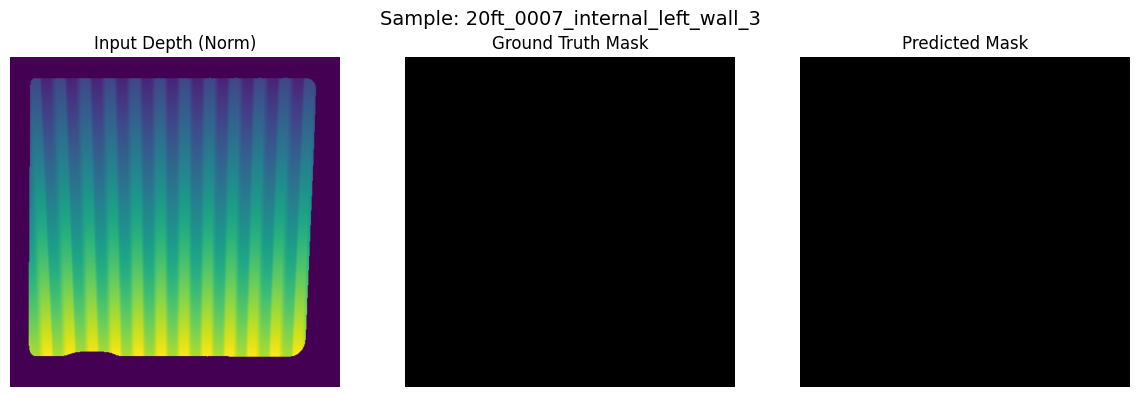

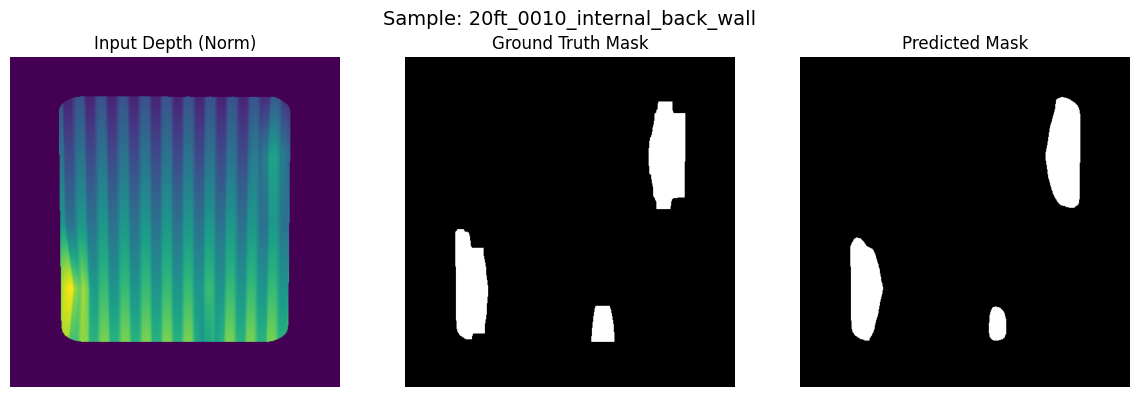

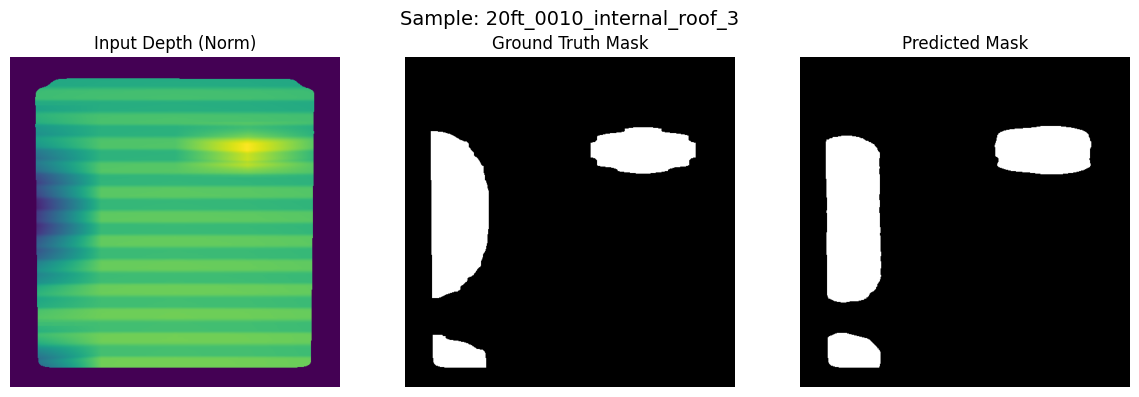

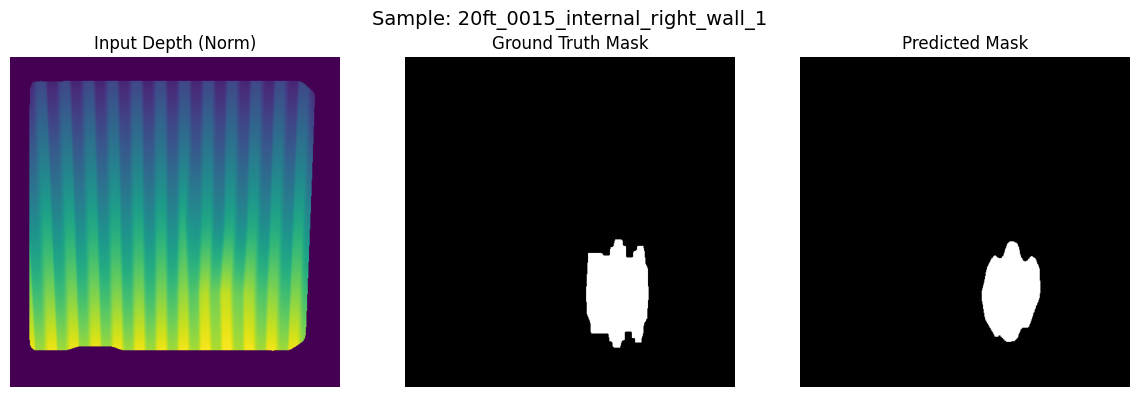

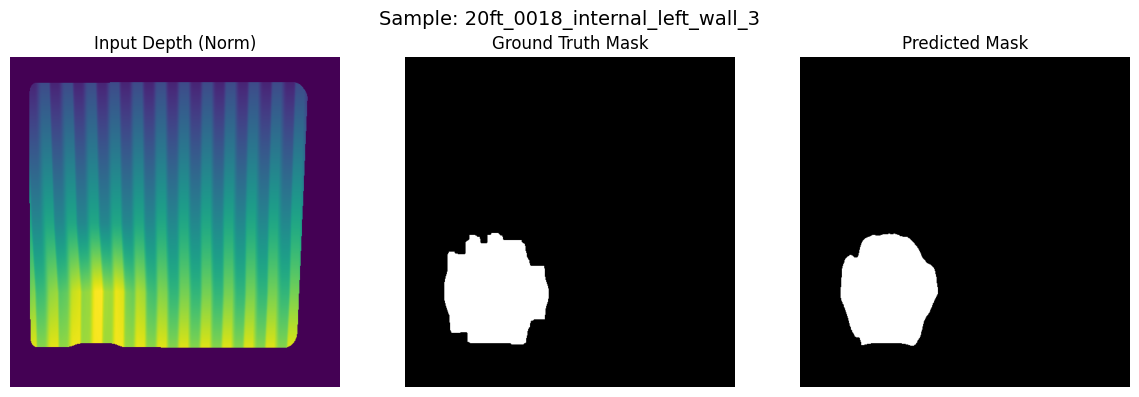

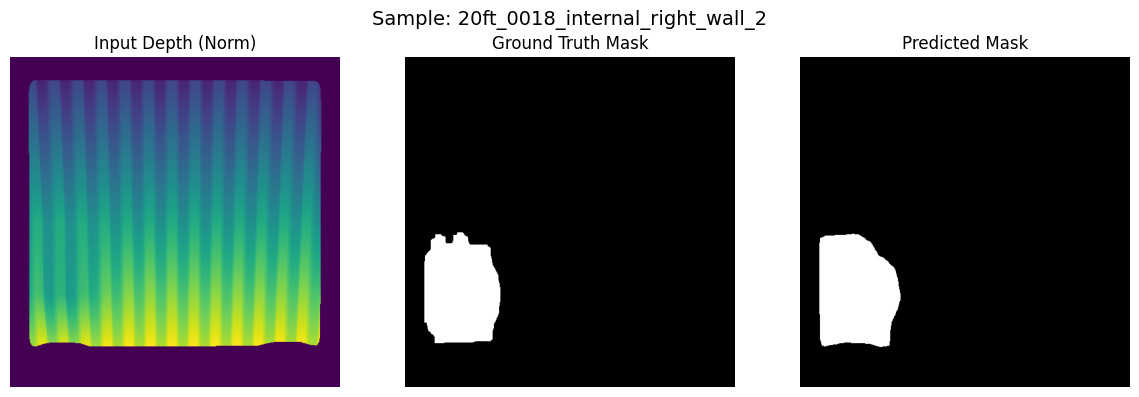

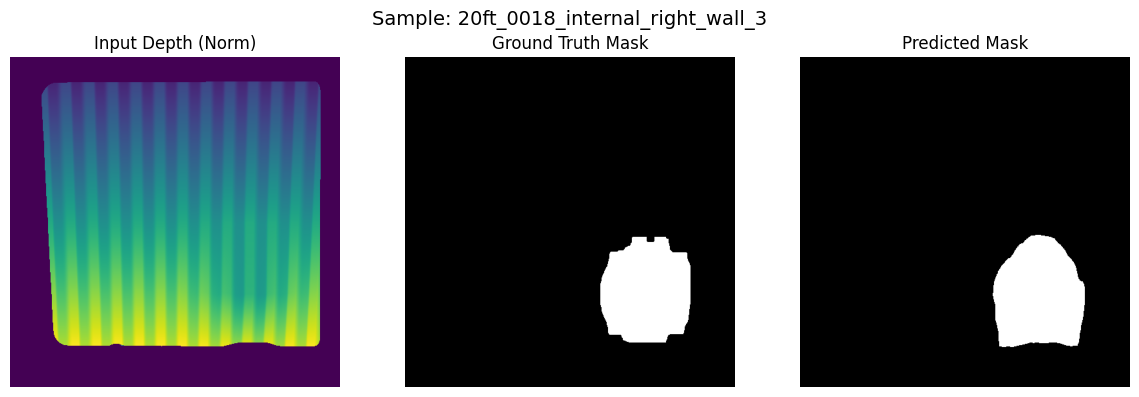

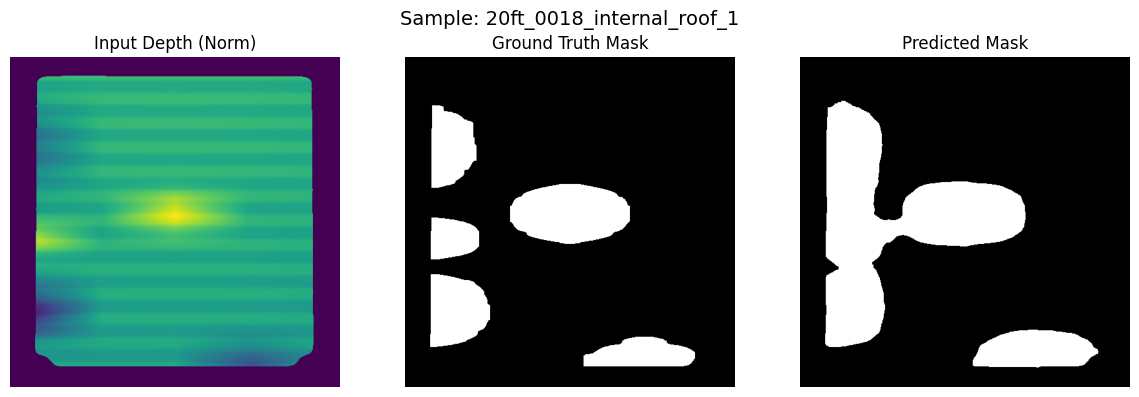

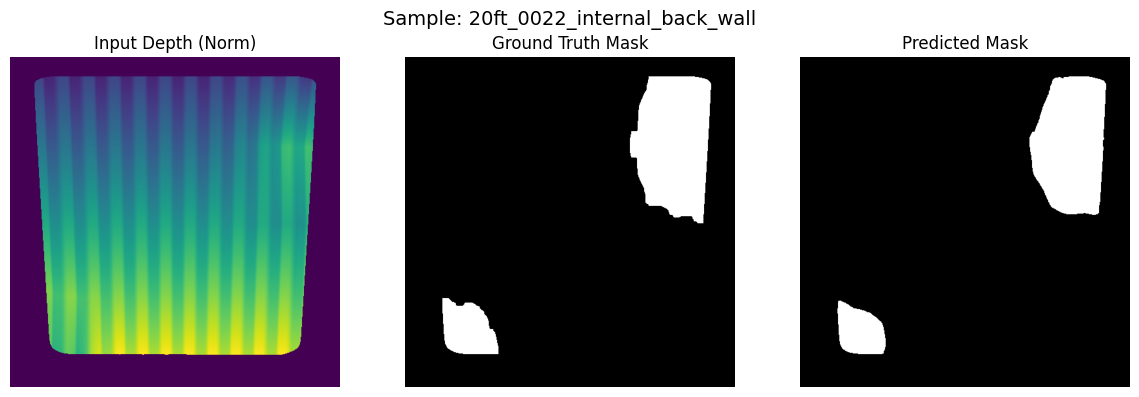

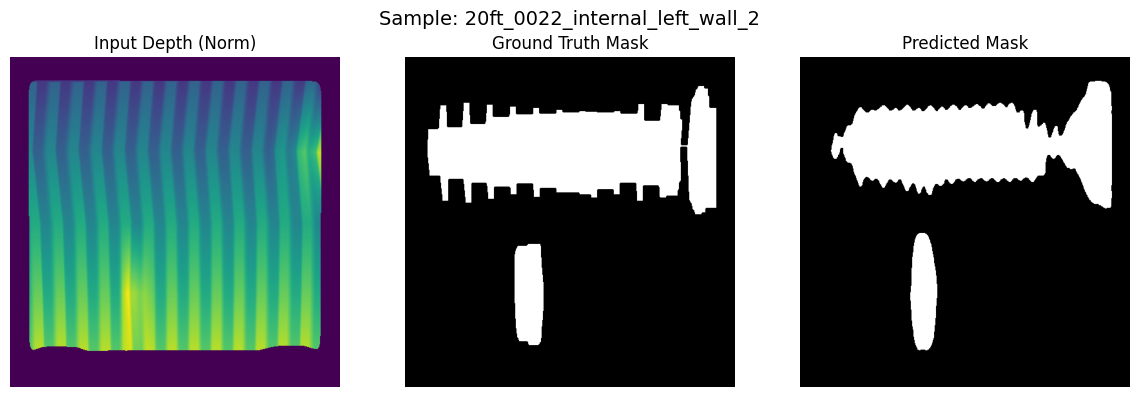

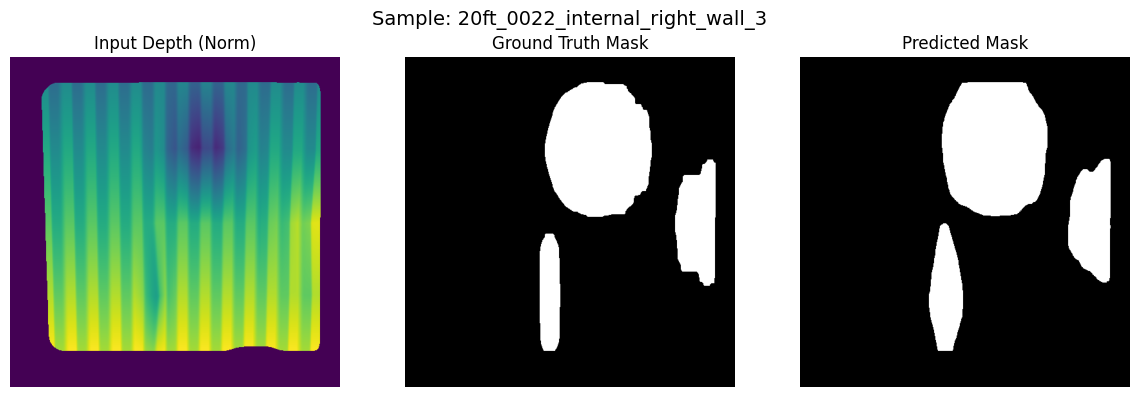

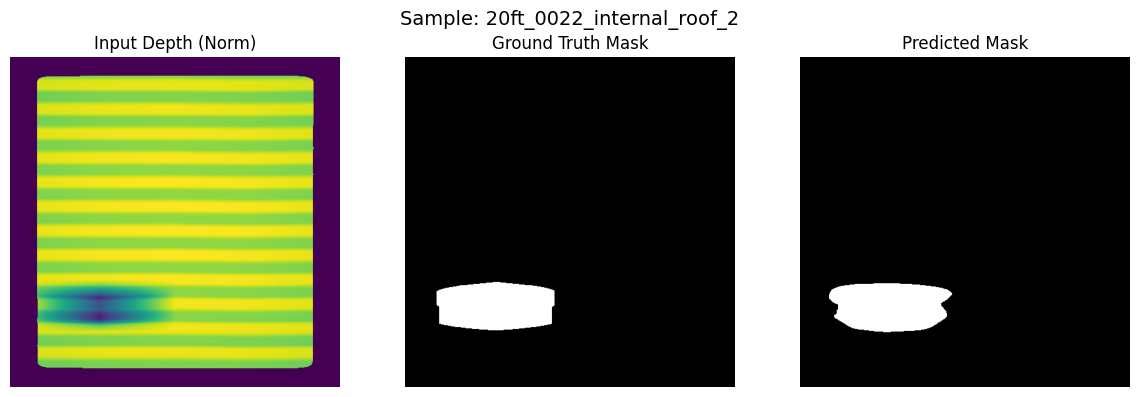

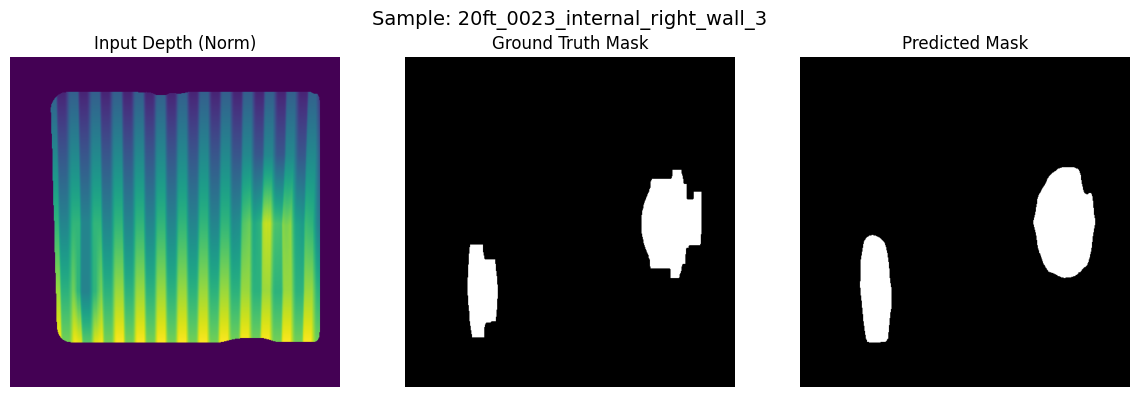

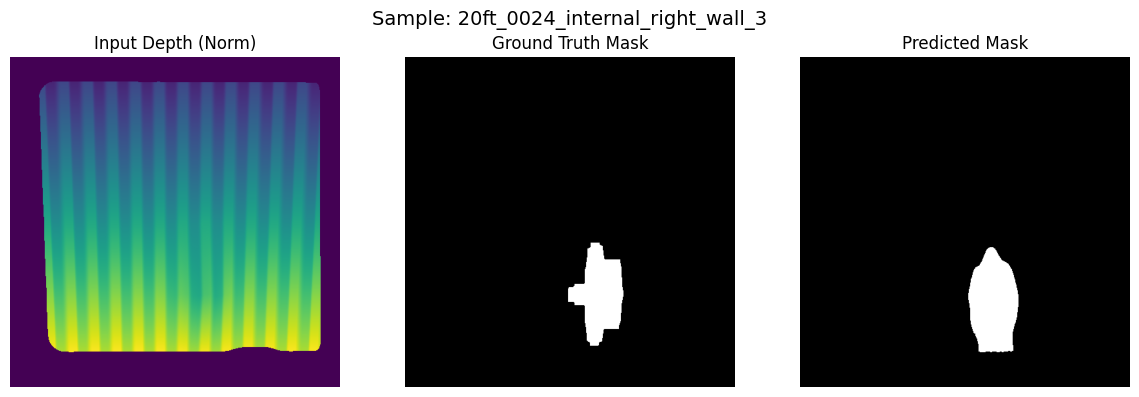

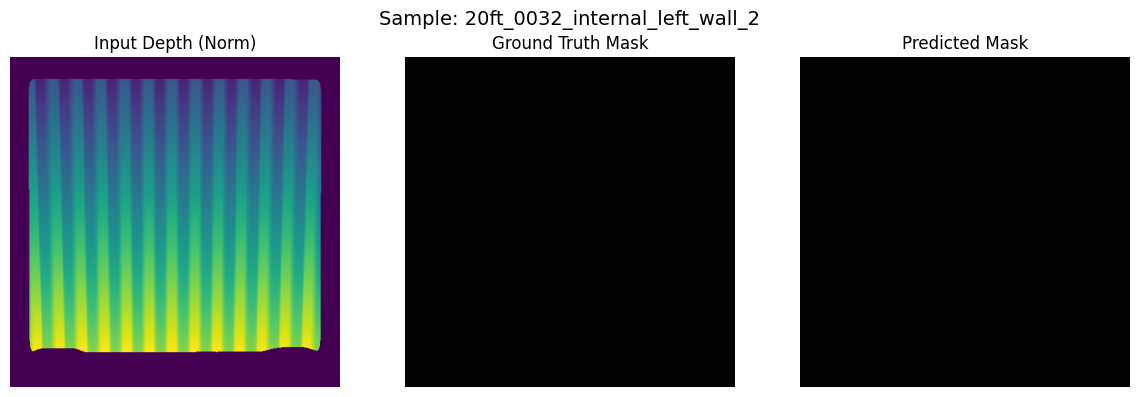

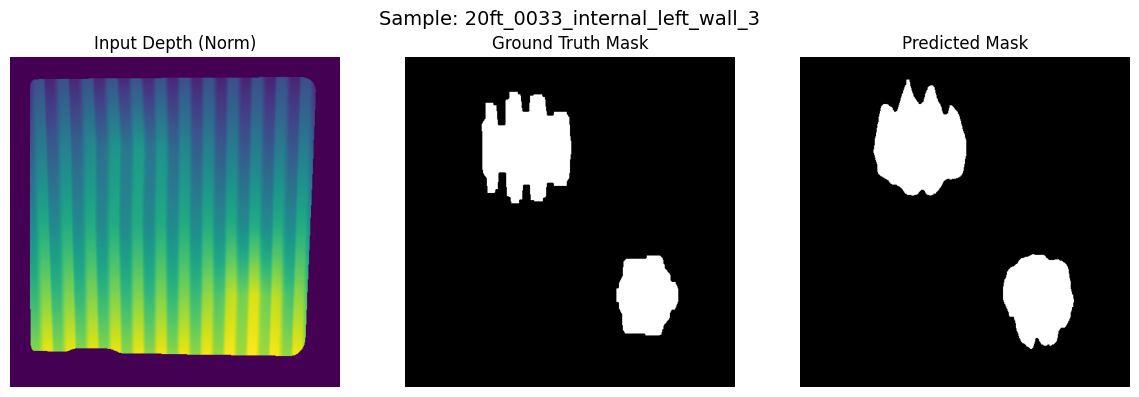

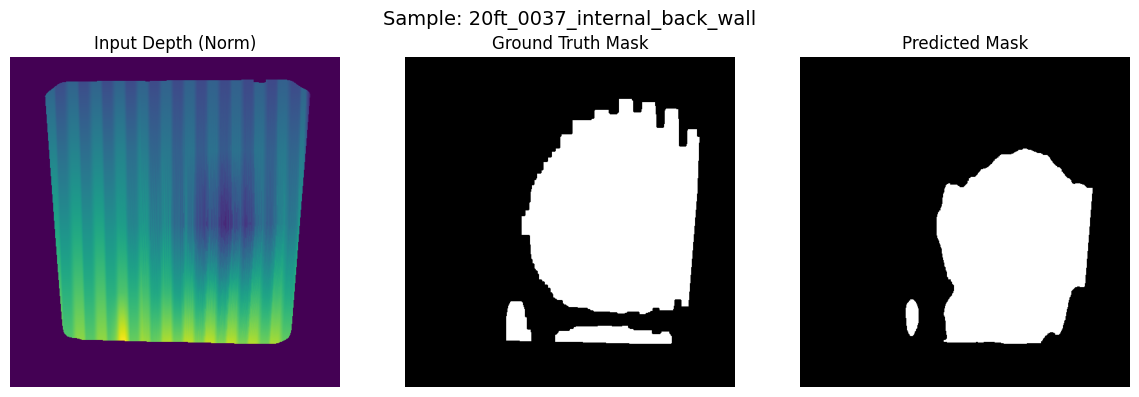

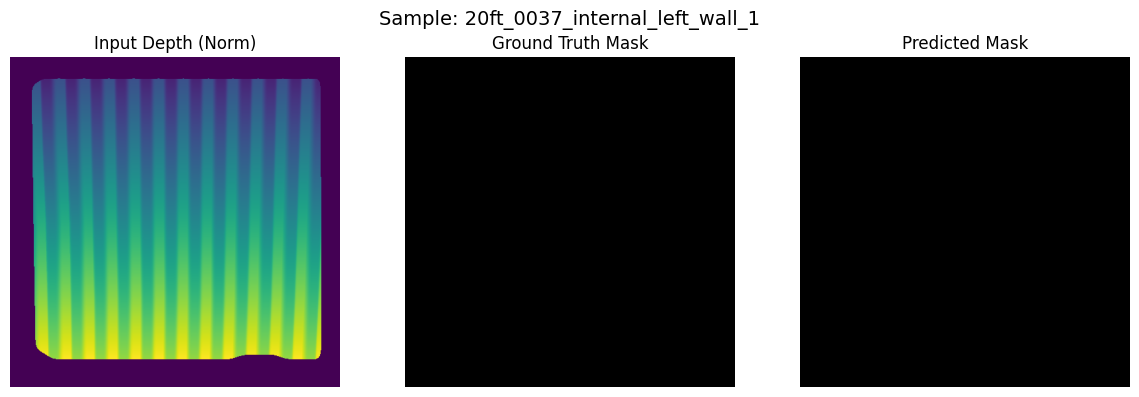

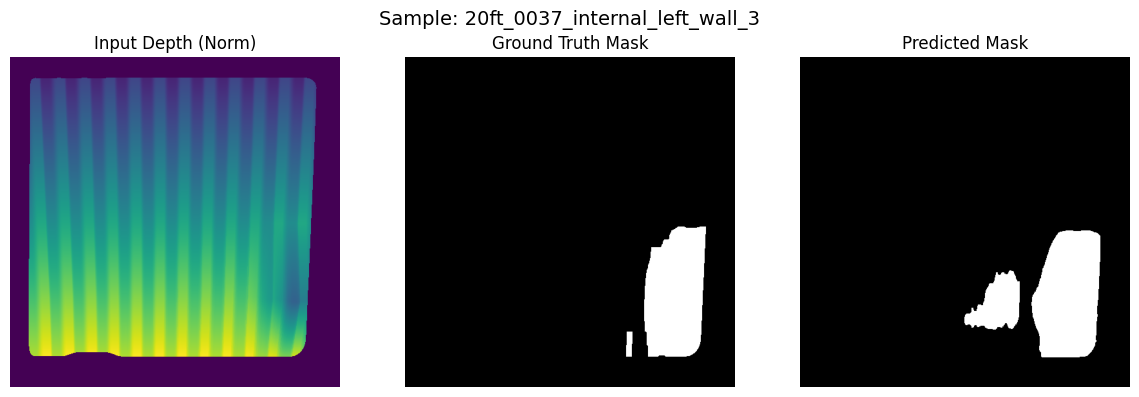

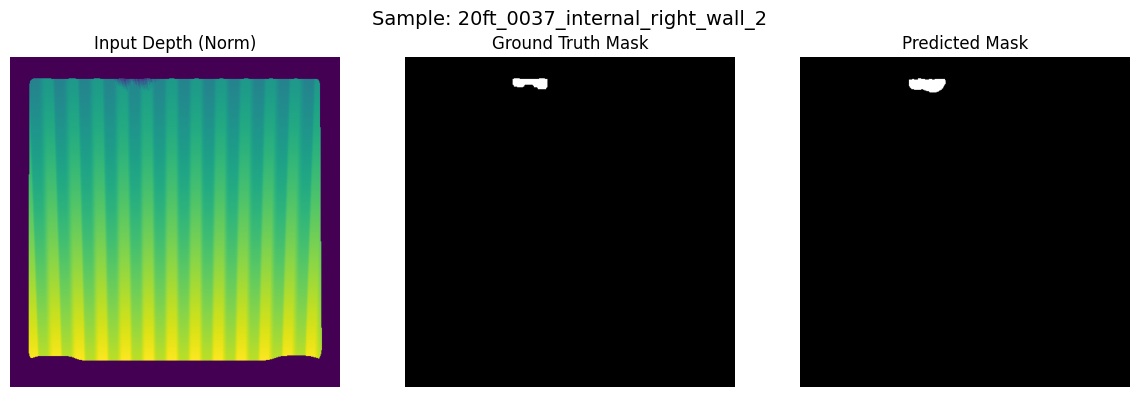

In [20]:
# ---------------------------
# 13) Visualization of Results
# ---------------------------
import matplotlib.pyplot as plt

# Get the list of prediction images we just saved
pred_files = sorted(glob.glob(os.path.join(pred_out_dir, "*_pred.png")))

# Pick random 3 or take first 3
num_to_show = min(20, len(pred_files))
vis_samples = pred_files[:num_to_show]

if len(vis_samples) == 0:
    print("No predictions found to visualize.")
else:
    for i, pred_path in enumerate(vis_samples):
        # Derive paths based on naming convention in Step 9
        base = os.path.basename(pred_path).replace("_pred.png", "")

        # Load Depth (Visual)
        depth_vis_path = os.path.join(pred_out_dir, base + "_gt_depth.png")
        if os.path.exists(depth_vis_path):
            depth_img = cv2.imread(depth_vis_path, cv2.IMREAD_GRAYSCALE)
        else:
            depth_img = np.zeros((256,256), dtype=np.uint8) # Fallback

        # Load GT Mask
        gt_mask_path = os.path.join(pred_out_dir, base + "_gt_mask.png")
        if os.path.exists(gt_mask_path):
            gt_mask_img = cv2.imread(gt_mask_path, cv2.IMREAD_GRAYSCALE)
        else:
            gt_mask_img = np.zeros_like(depth_img)

        # Load Prediction
        pred_img = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)

        # Plot
        plt.figure(figsize=(12, 4))
        plt.suptitle(f"Sample: {base}", fontsize=14)

        plt.subplot(1, 3, 1)
        plt.title("Input Depth (Norm)")
        plt.imshow(depth_img, cmap="viridis")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("Ground Truth Mask")
        plt.imshow(gt_mask_img, cmap="gray")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(pred_img, cmap="gray")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

🔍 Scanning test set for worst performers...

📉 Displaying the Bottom 25 Predictions (Lowest IoU):


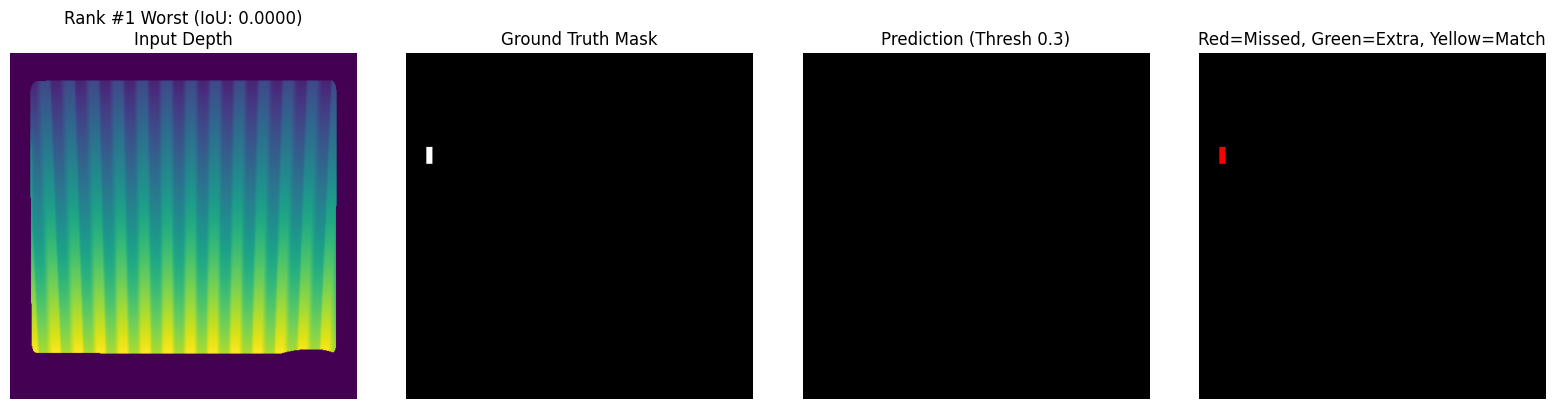

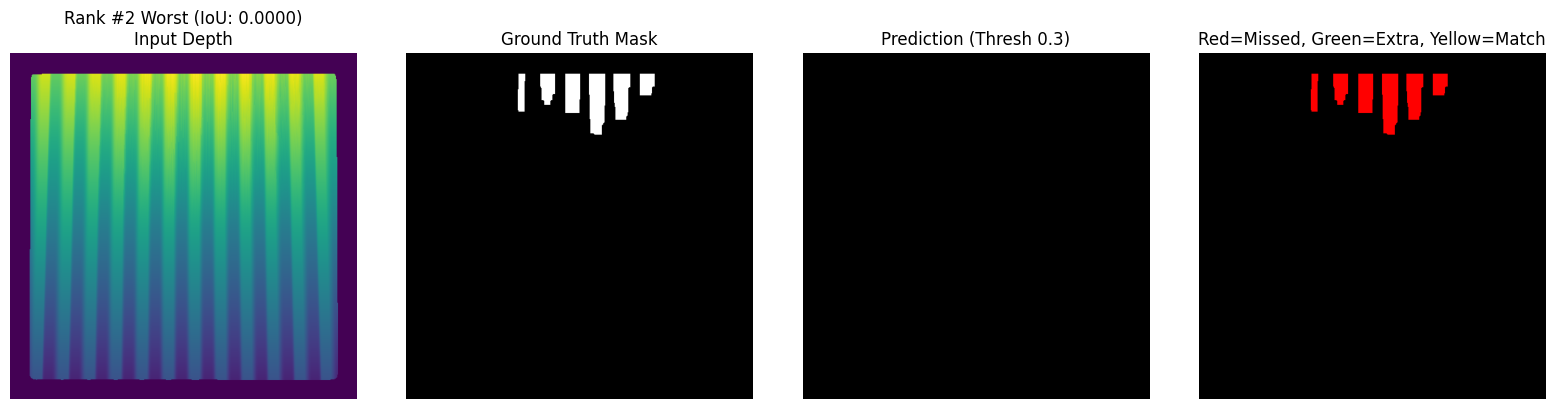

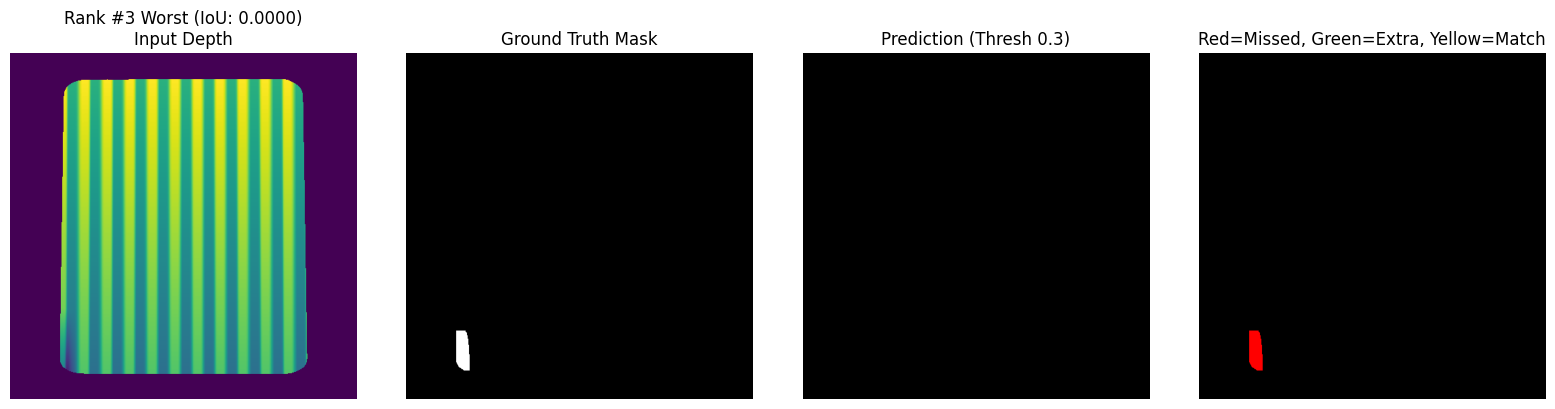

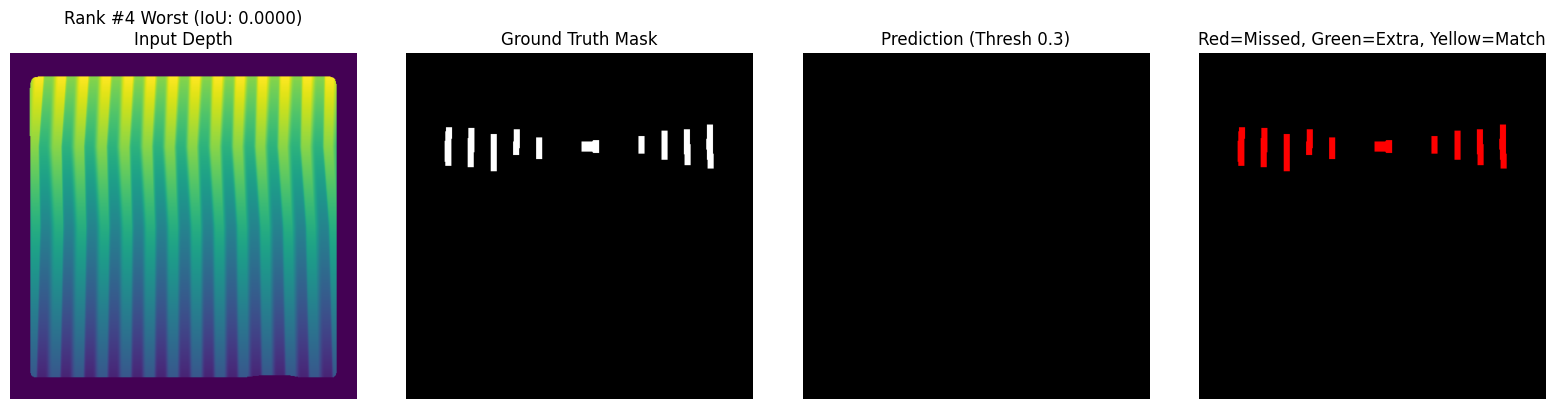

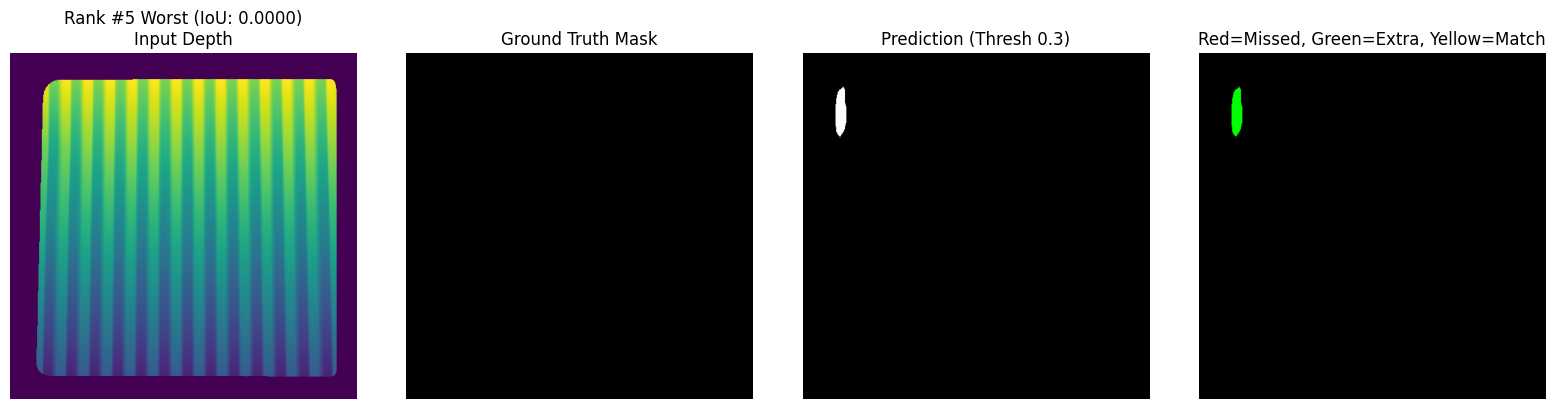

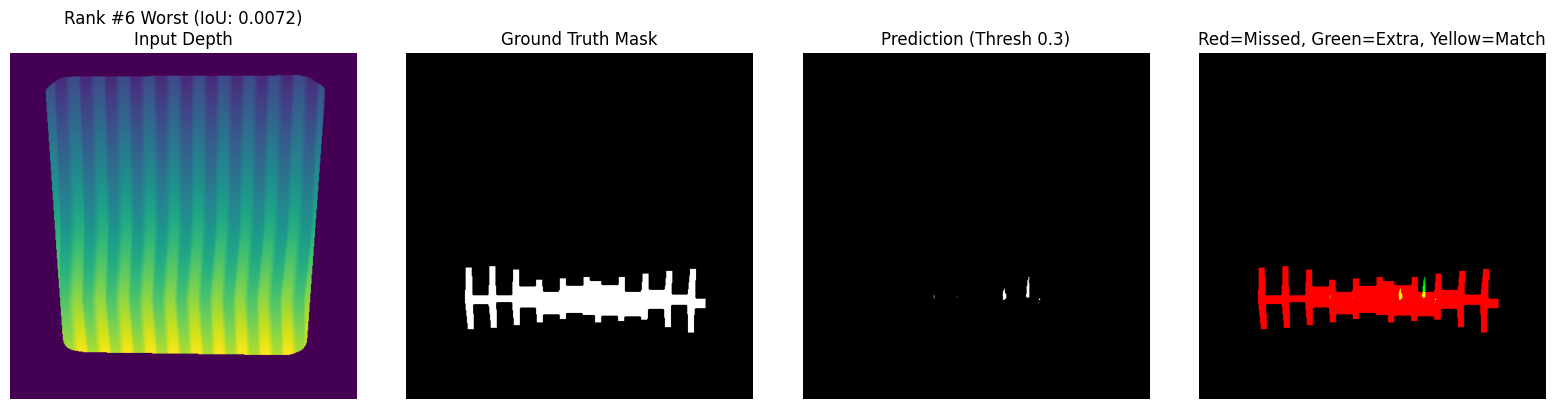

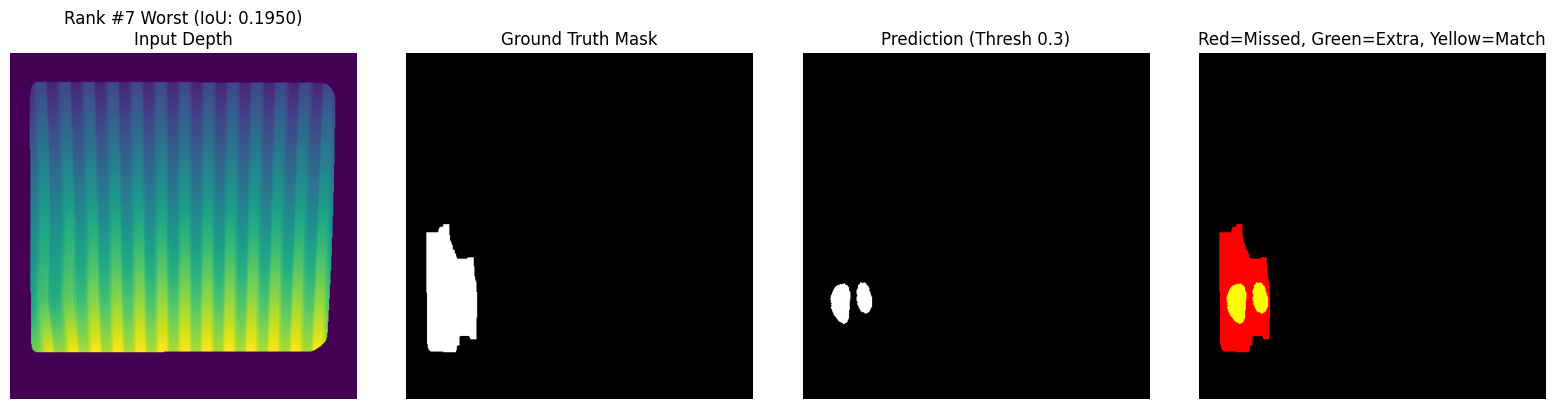

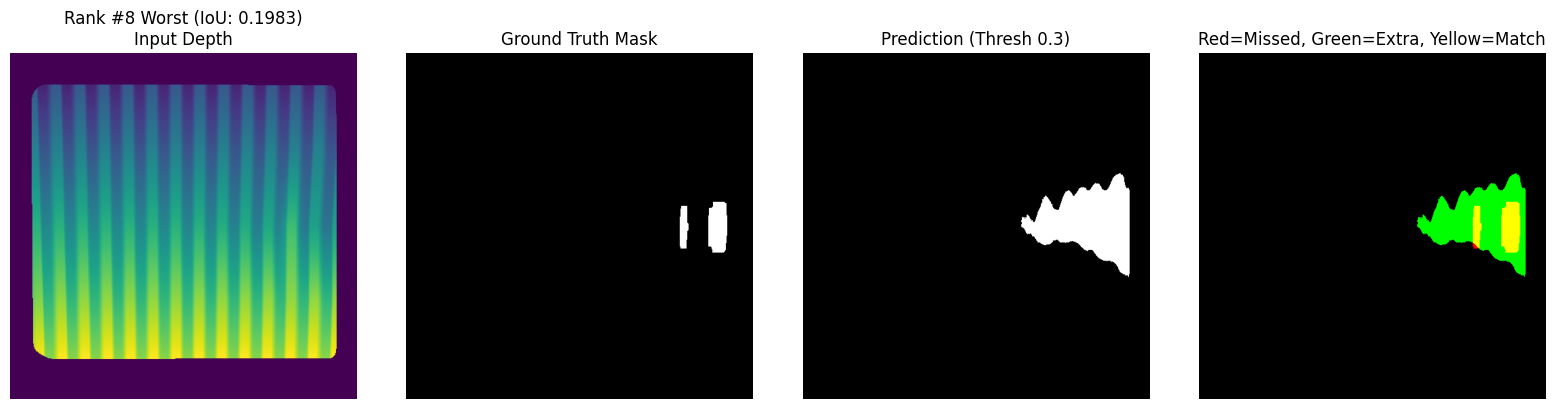

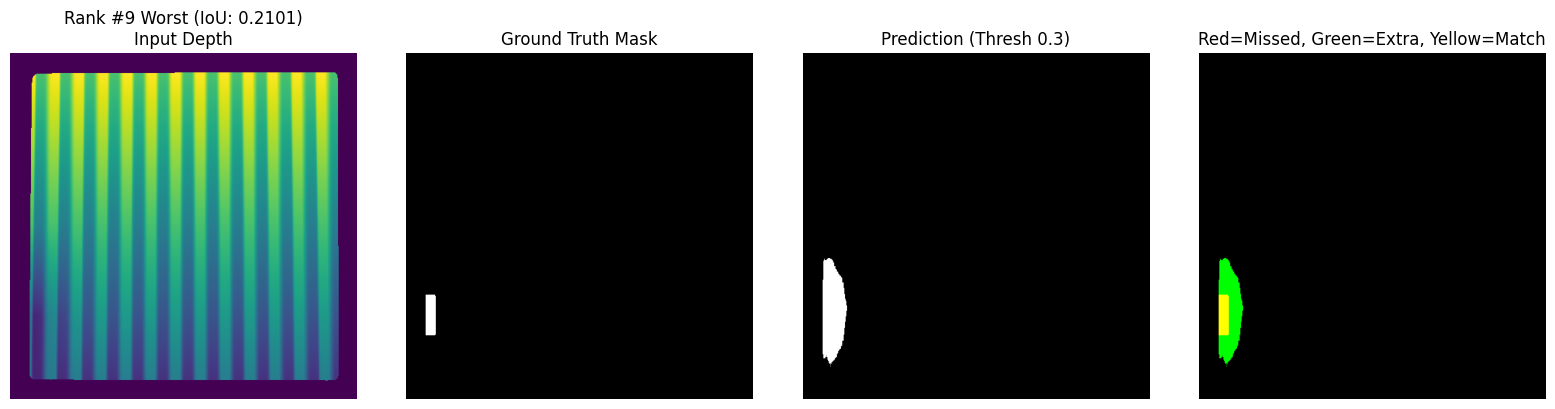

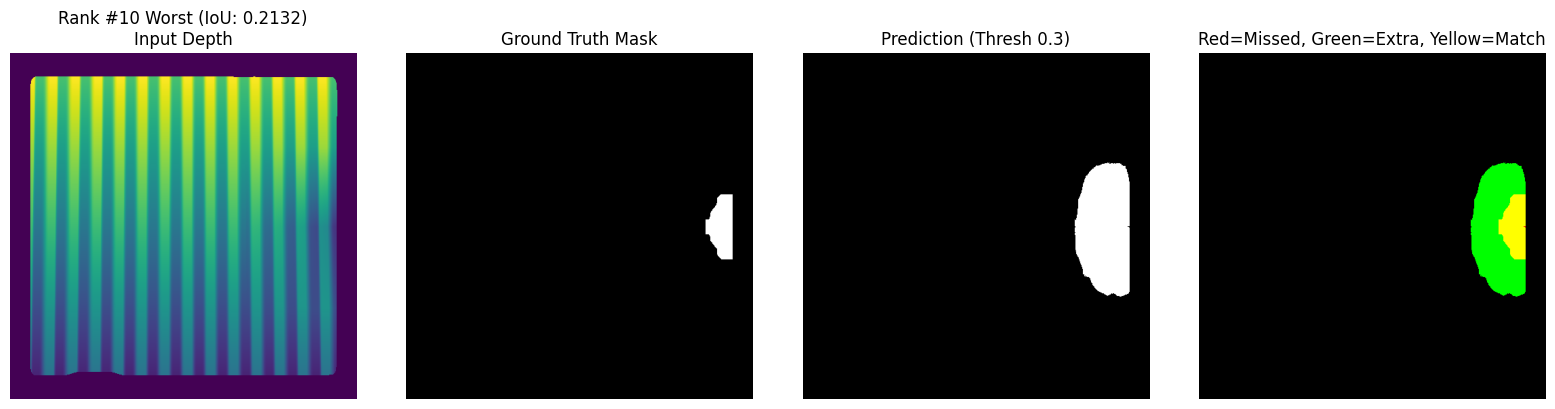

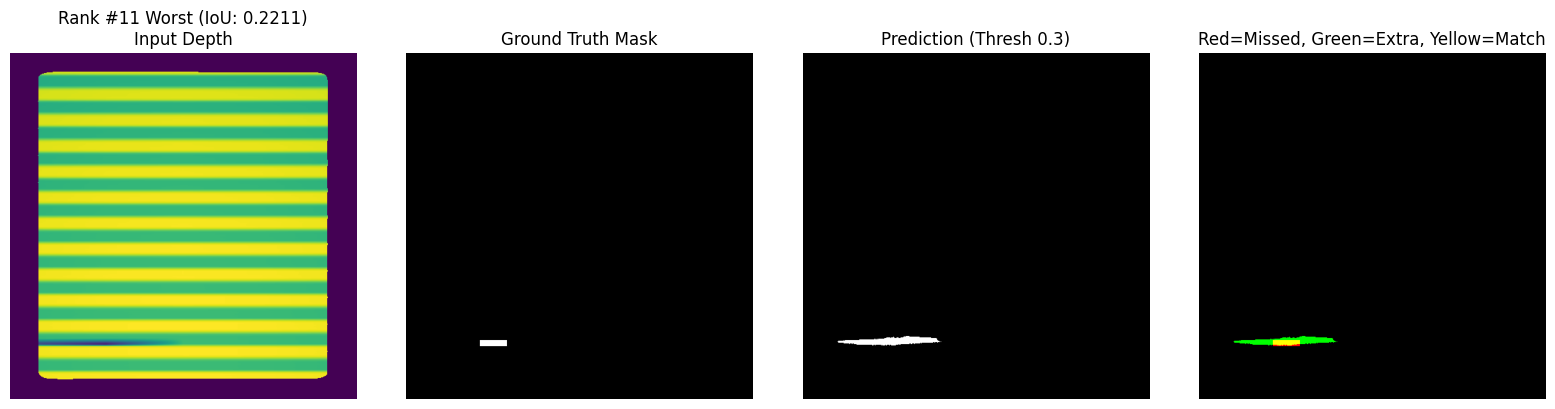

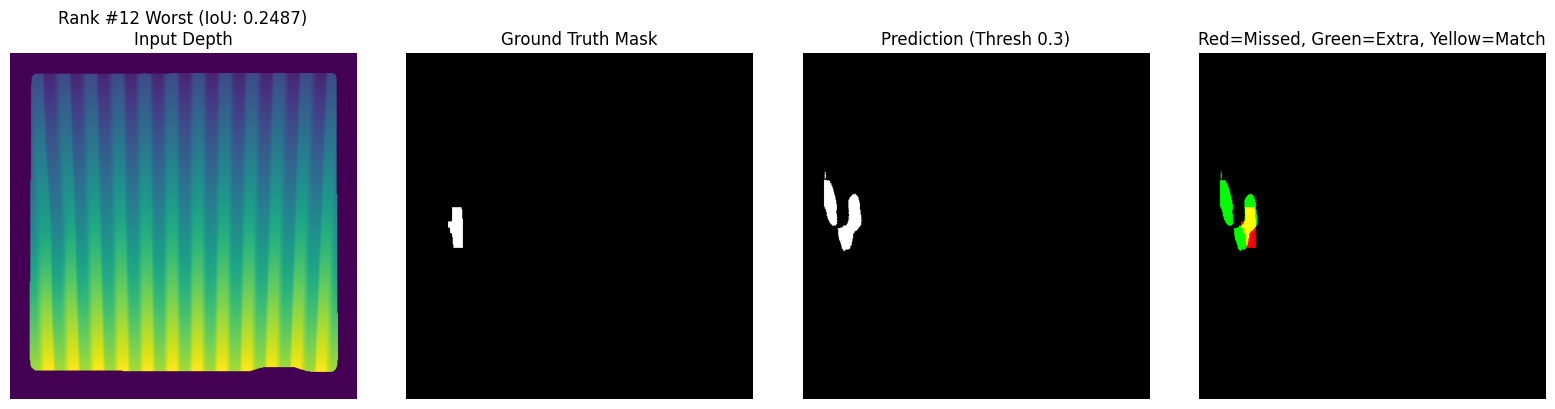

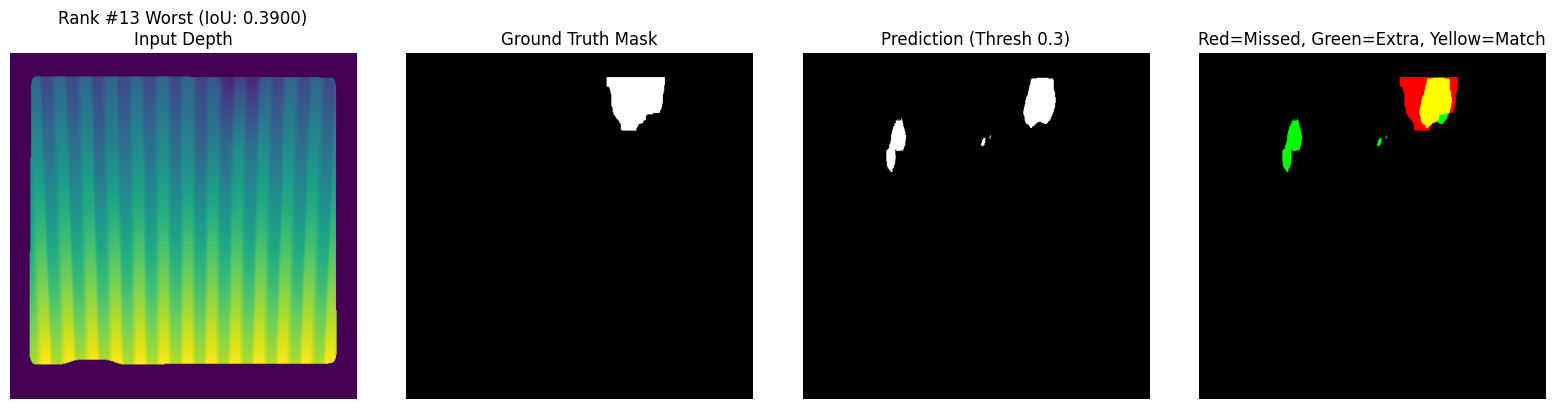

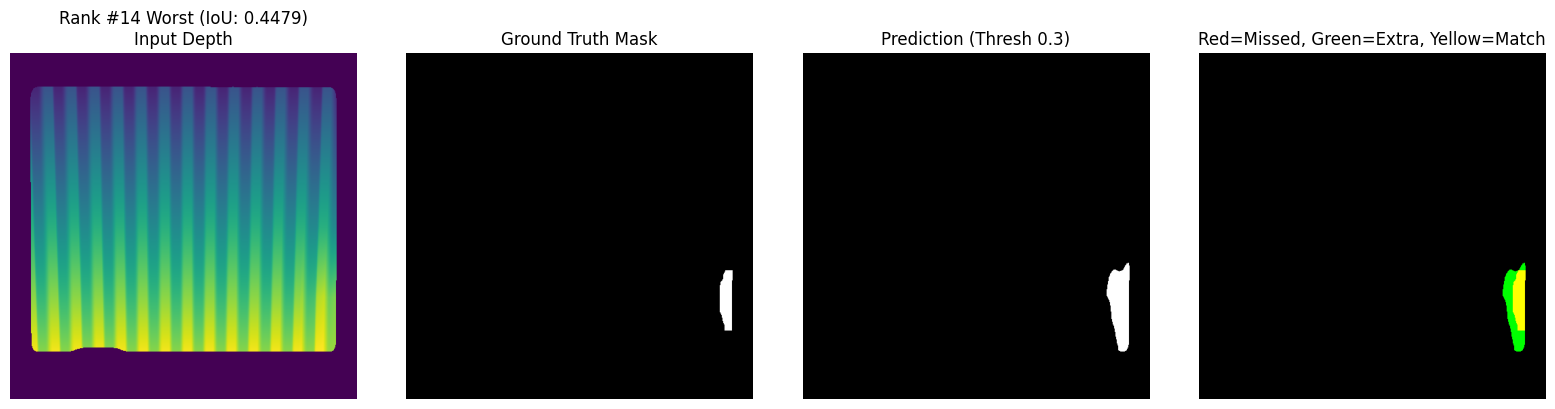

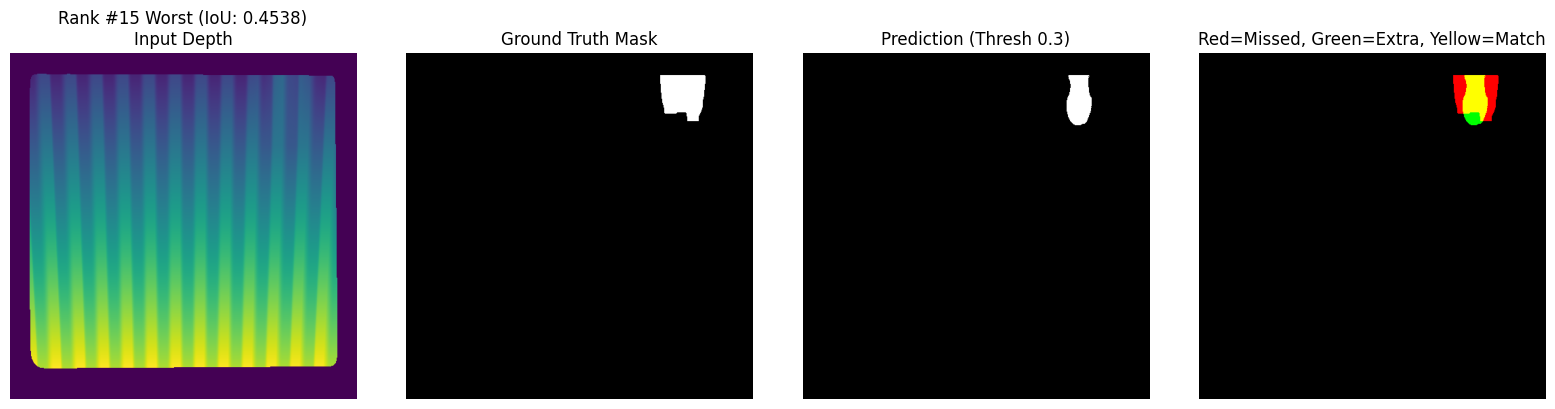

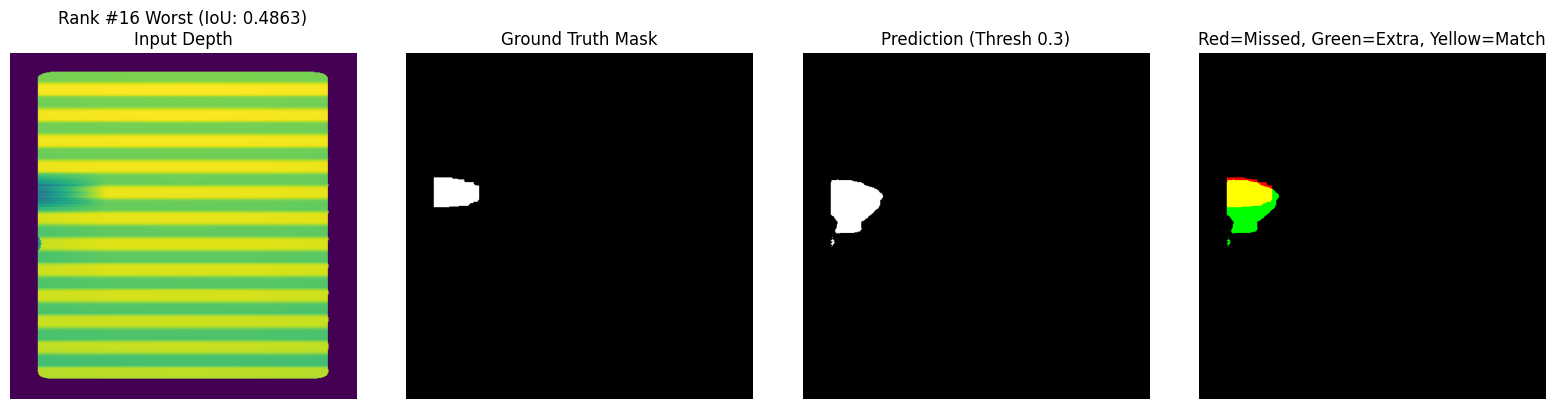

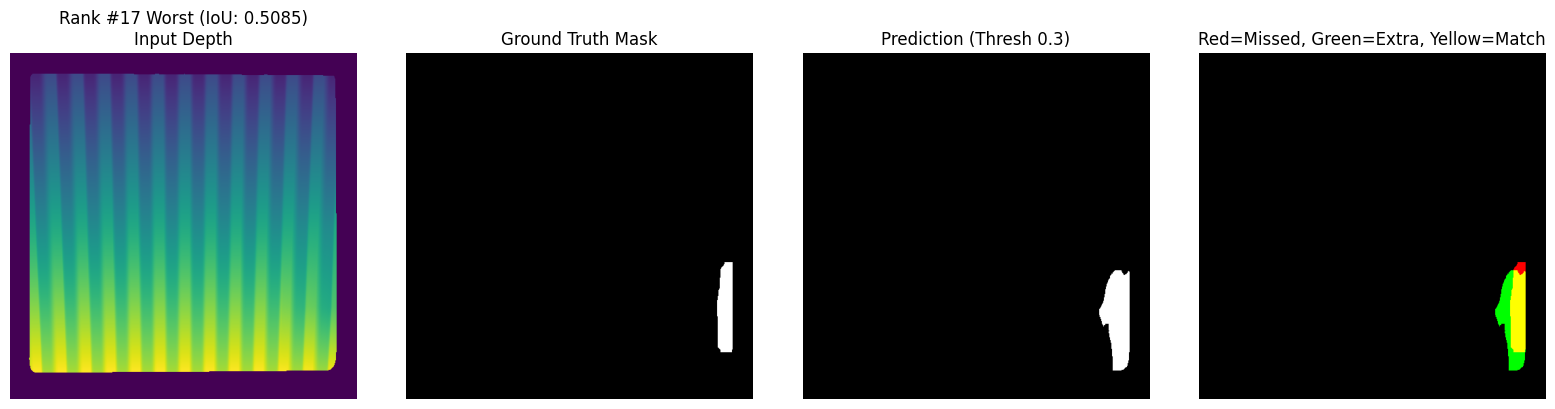

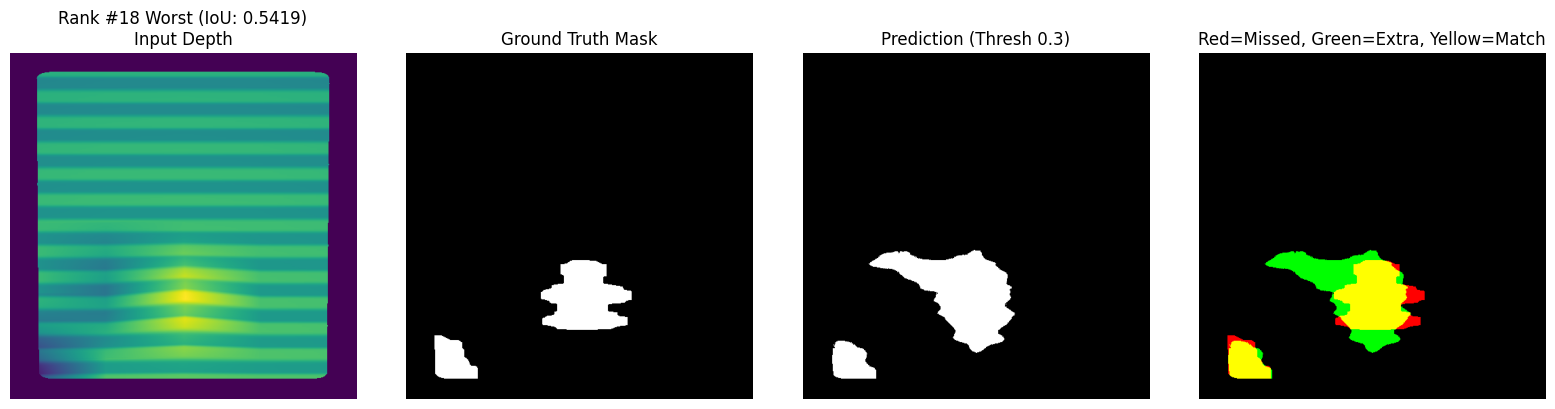

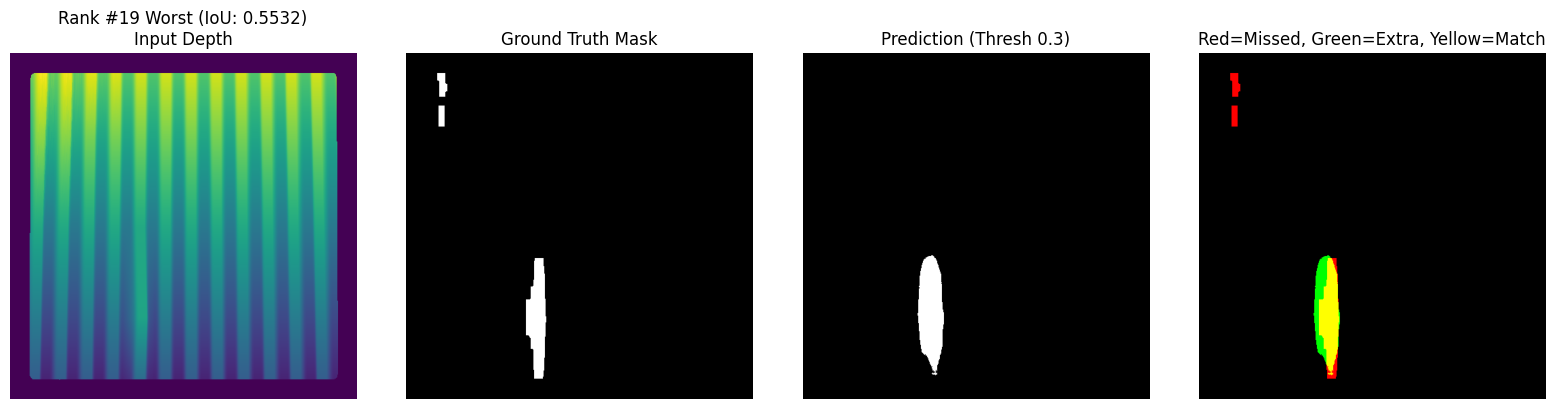

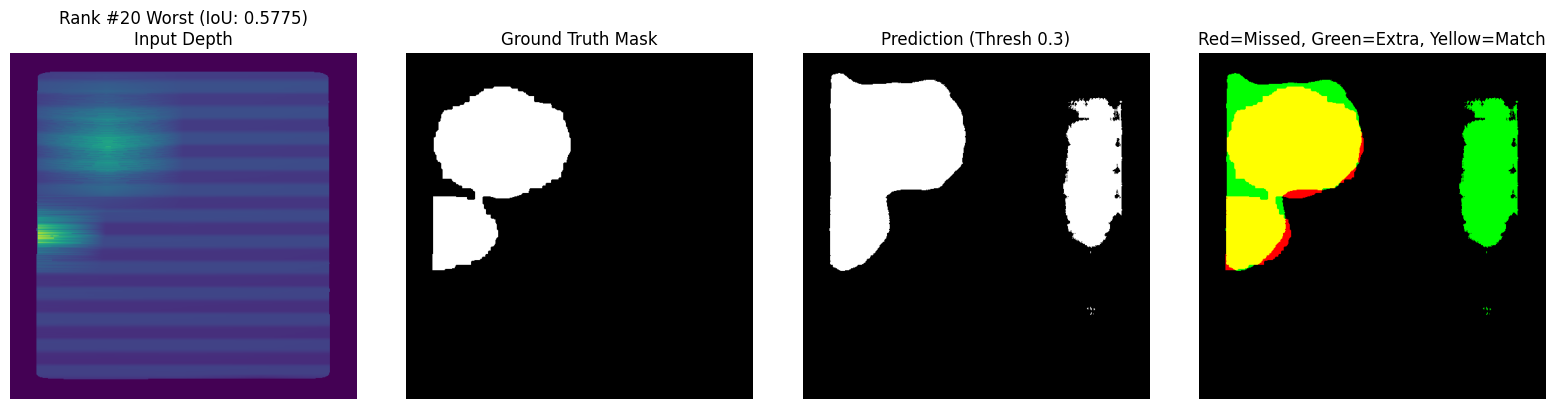

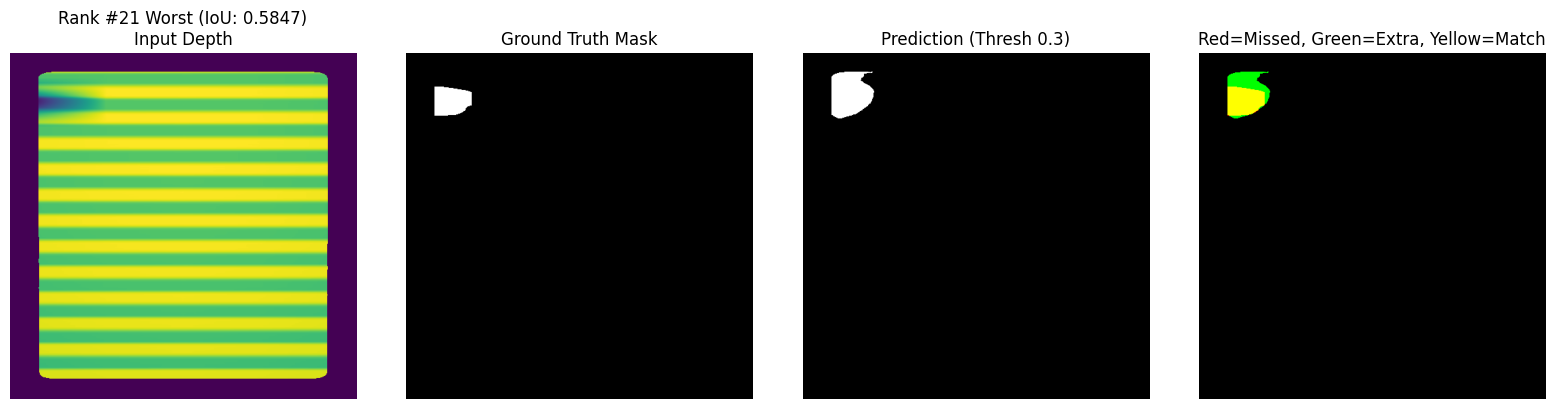

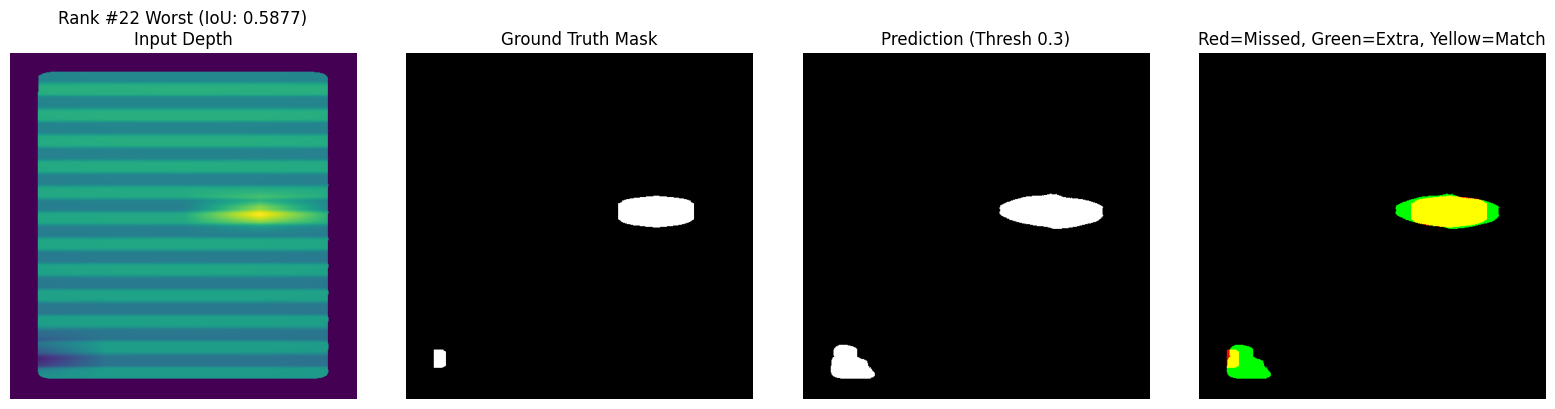

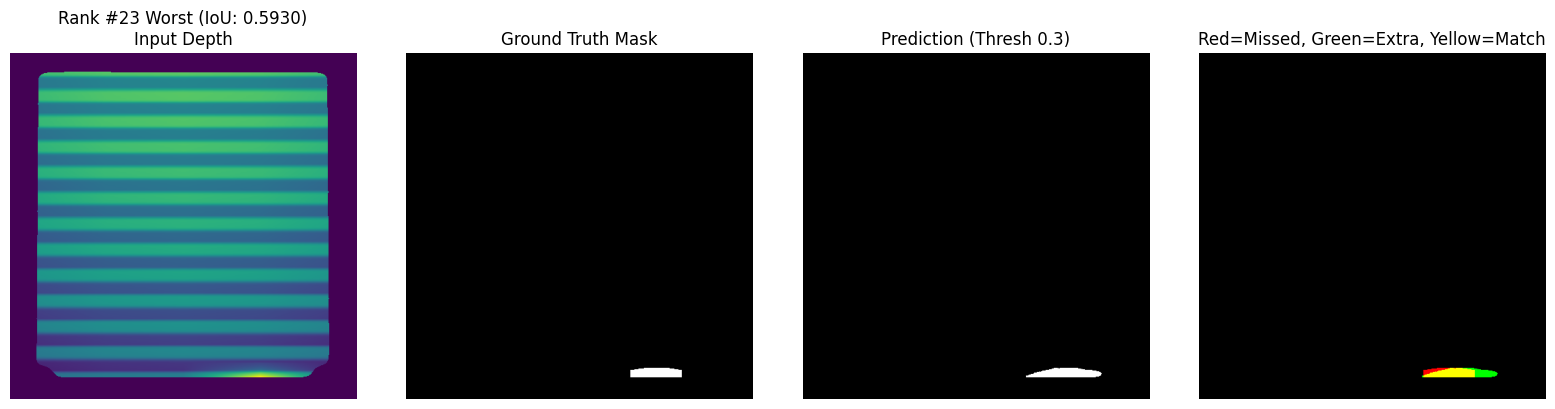

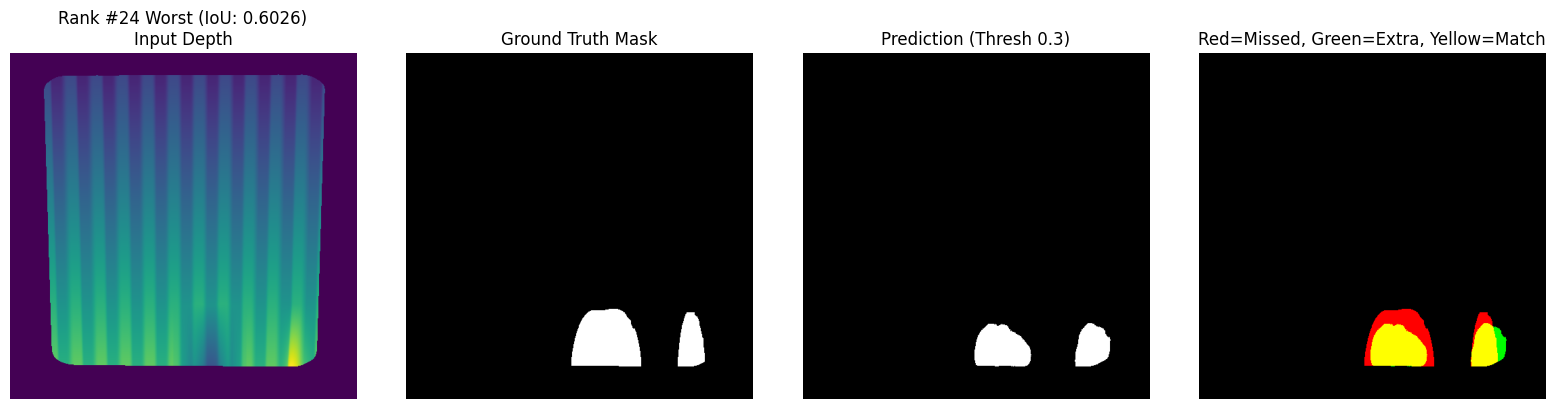

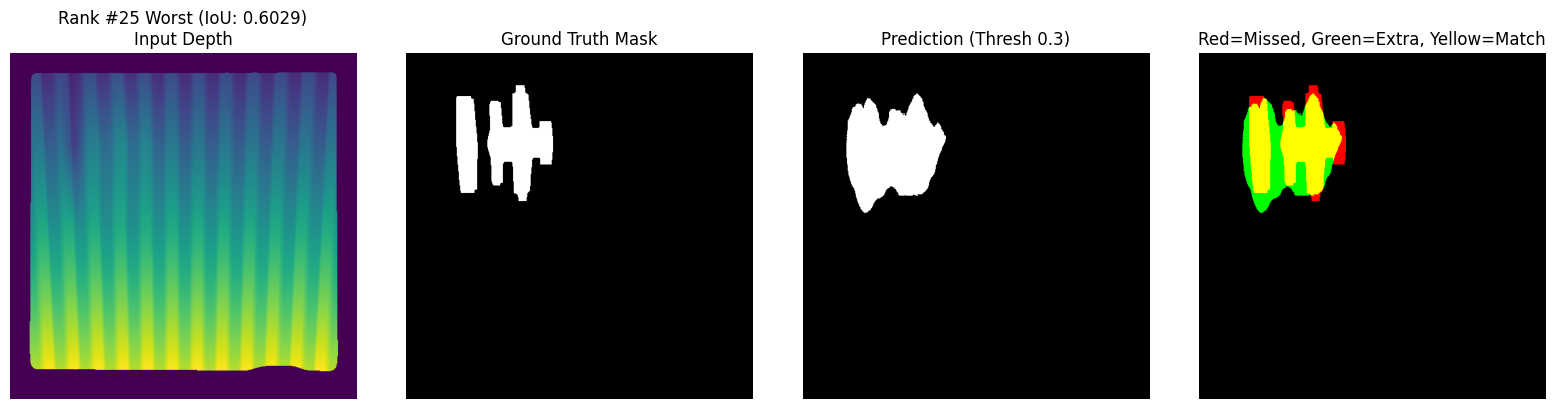

In [21]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# --- CONFIGURATION ---
MODEL_TO_USE = model  # Ensure this is your loaded 'best_attention_unet_finetuned'
DATALOADER = test_loader
THRESHOLD = 0.30  # The threshold we decided on
NUM_WORST_TO_SHOW = 25

def calculate_iou_single(pred_mask, true_mask):
    """Calculates IoU for a single image pair."""
    intersection = np.logical_and(pred_mask, true_mask).sum()
    union = np.logical_or(pred_mask, true_mask).sum()
    if union == 0:
        return 1.0 if intersection == 0 else 0.0 # Handle empty masks
    return intersection / union

# 1. Collect Results
results = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_TO_USE.eval()

print("🔍 Scanning test set for worst performers...")

with torch.no_grad():
    for batch_idx, (images, masks) in enumerate(DATALOADER):
        images = images.to(device)

        # Standard Inference (Fast enough for analysis)
        outputs = MODEL_TO_USE(images)
        probs = torch.sigmoid(outputs)

        # Convert to Numpy for calculations
        images_np = images.cpu().numpy()
        masks_np = masks.cpu().numpy()
        probs_np = probs.cpu().numpy()

        for i in range(images.shape[0]):
            # Get individual sample data
            # Assuming channel 0 is depth
            img = images_np[i, 0, :, :]
            true_mask = masks_np[i, 0, :, :]
            pred_prob = probs_np[i, 0, :, :]

            # Apply Threshold
            pred_mask = (pred_prob > THRESHOLD).astype(np.uint8)

            # Calculate Score
            iou = calculate_iou_single(pred_mask, true_mask)

            # Store everything we need to plot later
            results.append({
                "iou": iou,
                "image": img,
                "true_mask": true_mask,
                "pred_mask": pred_mask,
                "pred_prob": pred_prob
            })

# 2. Sort by IoU (Ascending: Worst first)
results.sort(key=lambda x: x["iou"])

# 3. Visualize
print(f"\n📉 Displaying the Bottom {NUM_WORST_TO_SHOW} Predictions (Lowest IoU):")

for i in range(NUM_WORST_TO_SHOW):
    res = results[i]

    plt.figure(figsize=(16, 4))

    # Input Depth
    plt.subplot(1, 4, 1)
    plt.title(f"Rank #{i+1} Worst (IoU: {res['iou']:.4f})\nInput Depth")
    plt.imshow(res['image'], cmap='viridis')
    plt.axis('off')

    # Ground Truth
    plt.subplot(1, 4, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(res['true_mask'], cmap='gray')
    plt.axis('off')

    # Prediction
    plt.subplot(1, 4, 3)
    plt.title(f"Prediction (Thresh {THRESHOLD})")
    plt.imshow(res['pred_mask'], cmap='gray')
    plt.axis('off')

    # Overlay Comparison
    plt.subplot(1, 4, 4)
    plt.title("Red=Missed, Green=Extra, Yellow=Match")

    # Create RGB overlay
    # Red = Ground Truth (Missed if not covered)
    # Green = Prediction (False Positive if no GT)
    # Yellow = Overlap
    overlay = np.zeros((res['image'].shape[0], res['image'].shape[1], 3))
    overlay[:,:,0] = res['true_mask'] # Red Channel
    overlay[:,:,1] = res['pred_mask'] # Green Channel

    plt.imshow(overlay)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

📏 Measuring Depth (Method: Stripes / Geometric Continuity)...


100%|██████████| 134/134 [00:16<00:00,  8.07it/s]



🎯 FINAL DEPTH ACCURACY (STRIPES METHOD)
Mean Absolute Error:   1.32 mm
Accuracy (<10mm err):  98.5%


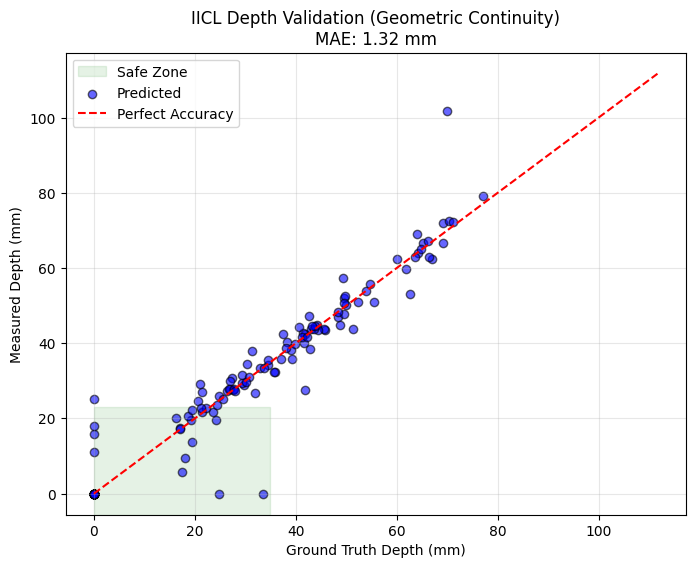


📸 Visualizing Top 5 Worst Errors (Sorted by Deviation)...


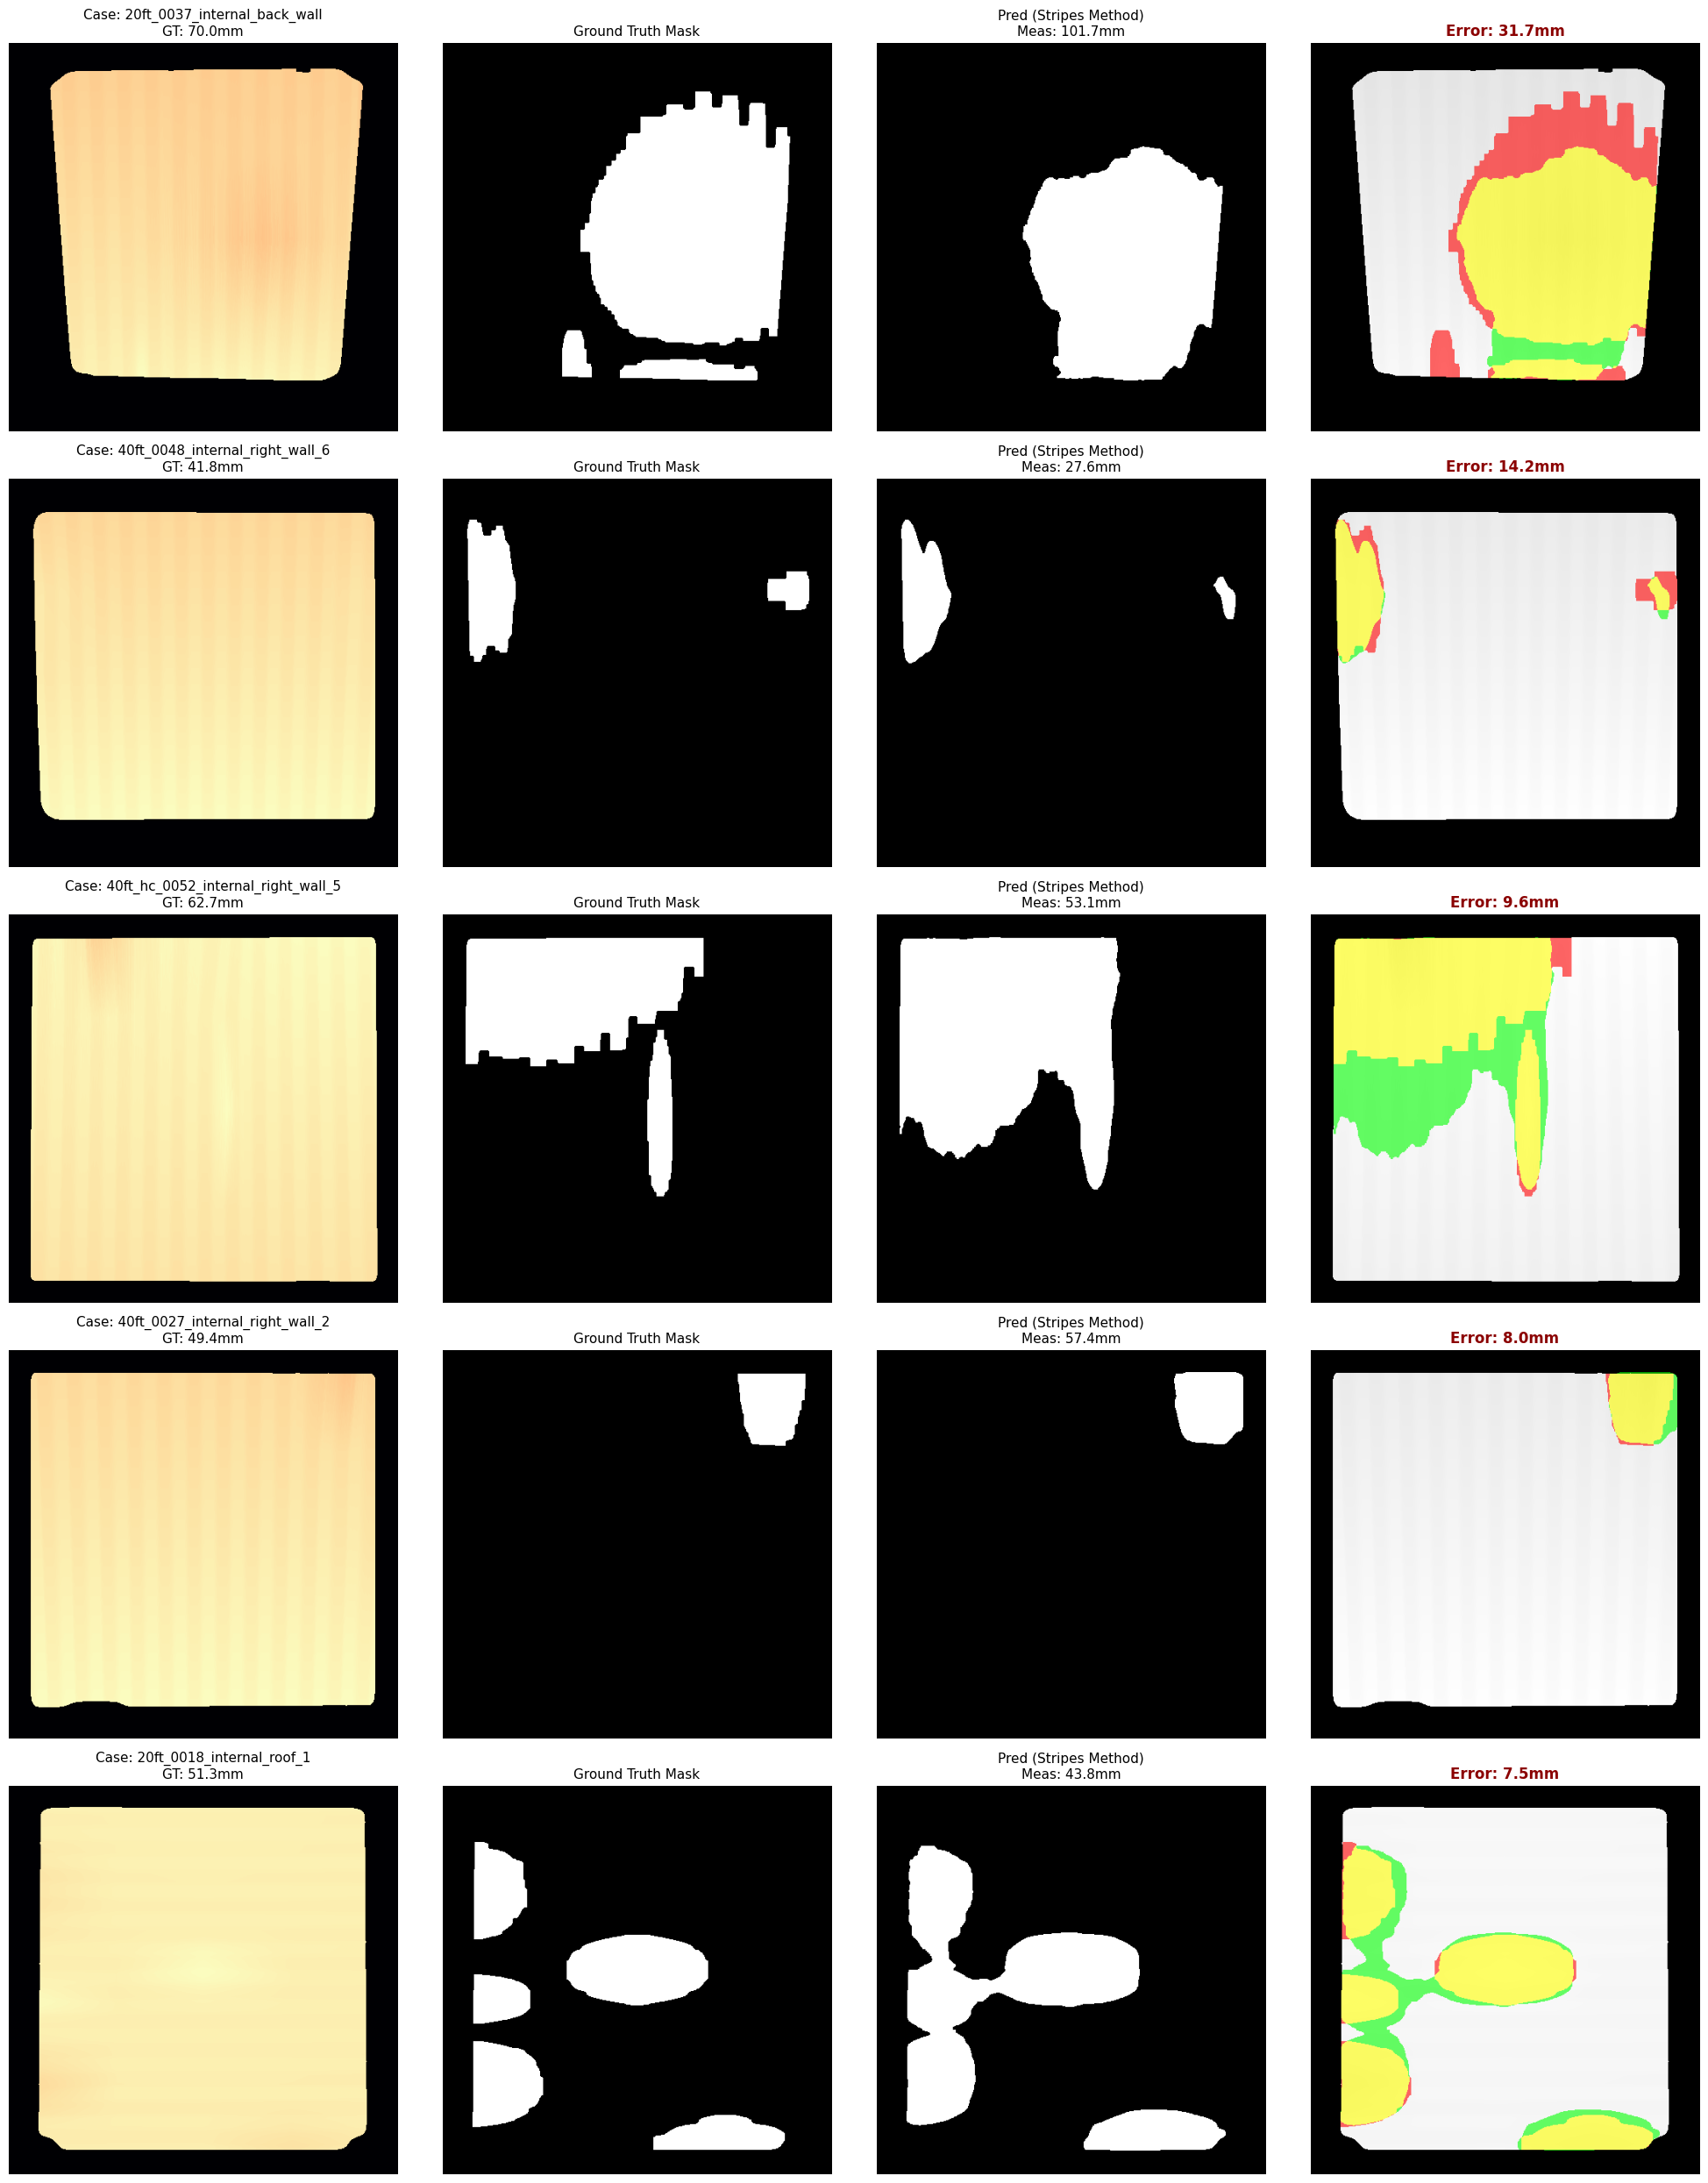

In [22]:
# ---------------------------
# 13) Depth Accuracy Analysis & Visualization (IICL Directional "Stripes" Method)
# ---------------------------
import glob
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from sklearn.linear_model import RANSACRegressor

# --- A. Helper: Detect Wall Orientation ---
def detect_corrugation_orientation(depth_map):
    """
    Determines if stripes run Vertical (Side Walls) or Horizontal (Roof).
    Uses Sobel gradients to find direction of highest variance.
    """
    # Sobel gradients
    dx = cv2.Sobel(depth_map, cv2.CV_64F, 1, 0, ksize=5)
    dy = cv2.Sobel(depth_map, cv2.CV_64F, 0, 1, ksize=5)
    
    # If Horizontal variance (dx) is higher, waves go Up-Down (Vertical)
    if np.var(dx) > np.var(dy) * 1.2:
        return "VERTICAL"
    # If Vertical variance (dy) is higher, waves go Left-Right (Horizontal)
    elif np.var(dy) > np.var(dx) * 1.2:
        return "HORIZONTAL"
    
    return "UNKNOWN"

# --- B. Helper: Directional RANSAC (The "Stripes" Logic) ---
def calculate_max_dent_depth_stripes(depth_map_m, mask_binary):
    """
    Measures depth by extending "healthy stripes" across the dent.
    Input: Depth map in METERS.
    Robust to: Warping, Bowing, Tilting, and Multi-Corrugations.
    """
    if np.sum(mask_binary) == 0: return 0.0
    
    # 1. Orientation
    orientation = detect_corrugation_orientation(depth_map_m)
    
    # 2. Process Each Dent Individually
    num_labels, labels = cv2.connectedComponents((mask_binary > 0).astype(np.uint8))
    max_severity_total = 0.0
    H, W = depth_map_m.shape
    
    # Grid for RANSAC
    yy, xx = np.meshgrid(np.arange(H), np.arange(W), indexing='ij')

    for i in range(1, num_labels):
        dent_mask = (labels == i)
        ys, xs = np.where(dent_mask)
        y_min, y_max = np.min(ys), np.max(ys)
        x_min, x_max = np.min(xs), np.max(xs)
        
        # --- 3. EXTRACT THE STRIPE (Scanning) ---
        # Look "Up/Down" or "Left/Right" to find the original rail.
        scan_margin = 150 # Look far to find healthy metal
        
        if orientation == "VERTICAL": # Side Walls
            y_scan_min = max(0, y_min - scan_margin)
            y_scan_max = min(H, y_max + scan_margin)
            # CRITICAL: Keep width strict (don't look left/right at other rails)
            x_scan_min, x_scan_max = x_min, x_max 
            
        elif orientation == "HORIZONTAL": # Roofs
            y_scan_min, y_scan_max = y_min, y_max
            # CRITICAL: Keep height strict
            x_scan_min = max(0, x_min - scan_margin)
            x_scan_max = min(W, x_max + scan_margin)
            
        else: # Unknown (Box Search fallback)
            y_scan_min = max(0, y_min - 50)
            y_scan_max = min(H, y_max + 50)
            x_scan_min = max(0, x_min - 50)
            x_scan_max = min(W, x_max + 50)

        strip_depth = depth_map_m[y_scan_min:y_scan_max, x_scan_min:x_scan_max]
        strip_mask = mask_binary[y_scan_min:y_scan_max, x_scan_min:x_scan_max]
        
        # Identify Healthy Neighbors in this stripe
        neighbor_mask = (strip_depth > 0) & (strip_mask == 0)
        if np.sum(neighbor_mask) < 50: continue

        # --- 4. SURFACE LOGIC (The Bowing Fix) ---
        neighbor_depths = strip_depth[neighbor_mask]
        
        # Coordinate Grids for this strip
        h_c, w_c = strip_depth.shape
        yy_c, xx_c = np.meshgrid(np.arange(h_c), np.arange(w_c), indexing='ij')
        X_candidates = np.stack([xx_c[neighbor_mask], yy_c[neighbor_mask]], axis=1)
        y_candidates = neighbor_depths

        # Check Variance: Does this stripe contain both Hills and Valleys?
        # Corrugation depth is ~36mm (0.036m). If range > 15mm (0.015m), mixed surfaces.
        depth_range = np.percentile(neighbor_depths, 95) - np.percentile(neighbor_depths, 5)
        
        if depth_range > 0.015: 
            # Case: Multi-Wave Stripe.
            # ACTION: Filter for "Peaks" (Closer points) to bridge the gap.
            # This works even if wall is bowed, because it's relative to local strip.
            threshold = np.percentile(neighbor_depths, 50) 
            is_peak = neighbor_depths <= threshold
            
            X_train = X_candidates[is_peak]
            y_train = y_candidates[is_peak]
        else:
            # Case: Single Rail (Pure Hill or Pure Valley).
            # ACTION: Use everything.
            X_train = X_candidates
            y_train = y_candidates

        # --- 5. CREATE GHOST STRIPES (RANSAC Fit) ---
        try:
            reg = RANSACRegressor(random_state=42, residual_threshold=0.005)
            reg.fit(X_train, y_train)
            
            # --- 6. MEASURE PERPENDICULAR DROP ---
            dent_pixels_mask = (strip_mask > 0)
            X_dent = np.stack([xx_c[dent_pixels_mask], yy_c[dent_pixels_mask]], axis=1)
            actual_depths = strip_depth[dent_pixels_mask]
            
            # Predict "Should Be" Depth
            ideal_depths = reg.predict(X_dent)
            
            # Calculate Difference
            diffs = np.abs(actual_depths - ideal_depths)
            
            # Robust Max (95th Percentile)
            sev = np.percentile(diffs, 95)
            if sev > max_severity_total: max_severity_total = sev
        except:
            continue

    return max_severity_total

# --- C. Configuration ---
PRED_DIR = os.path.join(OUT_DIR, "batch_preds") 
SAFETY_THRESHOLD = 35.0 # mm

# --- D. Analysis Loop ---
pred_files = sorted(glob.glob(os.path.join(PRED_DIR, "*_pred.npy")))

detailed_results = [] # Store data for visualization

if len(pred_files) == 0:
    print(f"⚠️ No predictions found in {PRED_DIR}.")
else:
    print(f"📏 Measuring Depth (Method: Stripes / Geometric Continuity)...")

    for pred_path in tqdm(pred_files):
        # 1. Load Data
        pred_mask = np.load(pred_path)
        base_name = os.path.basename(pred_path).replace("_pred.npy", "")
        
        original_depth_path = os.path.join(DATA_DIR, base_name + "_dented_depth.npy")
        json_path = os.path.join(DATA_DIR, base_name + "_dent_segments.json")
        gt_mask_path = os.path.join(DATA_DIR, base_name + "_dent_mask.npy") # For visual only

        if not os.path.exists(json_path): json_path = os.path.join(DATA_DIR, base_name + ".json")
        if not os.path.exists(original_depth_path): continue

        # 2. Get GT Depth
        gt_max_mm = 0.0
        if os.path.exists(json_path):
            with open(json_path, 'r') as f:
                gt_data = json.load(f)
            segments = gt_data.get('segments', [])
            if segments:
                gt_max_mm = max([seg.get('max_depth_diff_mm', 0.0) for seg in segments])

        # 3. Measure Prediction (NEW METHOD)
        depth_raw = np.load(original_depth_path).astype(np.float32)
        
        # Ensure conversion to METERS for calculation
        if np.max(depth_raw) > 10.0: 
            depth_meters = depth_raw / 1000.0 # Convert mm -> m
        else:
            depth_meters = depth_raw # Already meters
            
        # Call the new "Stripes" function (Input: Meters, Output: Meters)
        measured_m = calculate_max_dent_depth_stripes(depth_meters, pred_mask)
        measured_mm = measured_m * 1000.0 # Convert back to mm for reporting

        # 4. Calculate Error
        if gt_max_mm < SAFETY_THRESHOLD and measured_mm < SAFETY_THRESHOLD:
            error = 0.0 
        else:
            error = abs(gt_max_mm - measured_mm)
            
        # 5. Store Result
        gt_mask = np.load(gt_mask_path) if os.path.exists(gt_mask_path) else np.zeros_like(pred_mask)
        
        # Keep raw depth (mm) for plotting
        depth_for_plot = depth_meters * 1000.0
        
        detailed_results.append({
            "name": base_name,
            "error": error,
            "gt_val": gt_max_mm,
            "pred_val": measured_mm,
            "depth_map": depth_for_plot, 
            "pred_mask": pred_mask,
            "gt_mask": gt_mask
        })

    # --- E. Report & Plotting ---
    if len(detailed_results) > 0:
        errors = np.array([r['error'] for r in detailed_results])
        mae = np.mean(errors)
        acc_10mm = np.mean(errors <= 10.0) * 100

        print("\n" + "="*50)
        print("🎯 FINAL DEPTH ACCURACY (STRIPES METHOD)")
        print("="*50)
        print(f"Mean Absolute Error:   {mae:.2f} mm")
        print(f"Accuracy (<10mm err):  {acc_10mm:.1f}%")
        print("="*50)

        # 1. Scatter Plot
        plt.figure(figsize=(8, 6))
        plt.axvspan(0, SAFETY_THRESHOLD, ymin=0, ymax=SAFETY_THRESHOLD/150, color='green', alpha=0.1, label='Safe Zone')
        
        true_depths = [r['gt_val'] for r in detailed_results]
        pred_depths = [r['pred_val'] for r in detailed_results]
        
        plt.scatter(true_depths, pred_depths, alpha=0.6, label="Predicted", color='blue', edgecolors='k')
        m = max(max(true_depths), max(pred_depths)) + 10
        plt.plot([0, m], [0, m], 'r--', label="Perfect Accuracy")
        plt.xlabel("Ground Truth Depth (mm)")
        plt.ylabel("Measured Depth (mm)")
        plt.title(f"IICL Depth Validation (Geometric Continuity)\nMAE: {mae:.2f} mm")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # --- F. Visualizing Worst Errors ---
        print("\n📸 Visualizing Top 5 Worst Errors (Sorted by Deviation)...")
        
        detailed_results.sort(key=lambda x: x['error'], reverse=True)
        top_N = min(5, len(detailed_results))
        subset = detailed_results[:top_N]
        
        fig, axes = plt.subplots(top_N, 4, figsize=(20, 5 * top_N))
        if top_N == 1: axes = np.expand_dims(axes, axis=0)

        for i, res in enumerate(subset):
            # 1. Depth
            axes[i, 0].imshow(res['depth_map'], cmap='magma')
            axes[i, 0].set_title(f"Case: {res['name']}\nGT: {res['gt_val']:.1f}mm", fontsize=11)
            axes[i, 0].axis('off')

            # 2. GT Mask
            axes[i, 1].imshow(res['gt_mask'], cmap='gray')
            axes[i, 1].set_title("Ground Truth Mask", fontsize=11)
            axes[i, 1].axis('off')

            # 3. Pred Mask
            axes[i, 2].imshow(res['pred_mask'], cmap='gray')
            axes[i, 2].set_title(f"Pred (Stripes Method)\nMeas: {res['pred_val']:.1f}mm", fontsize=11)
            axes[i, 2].axis('off')

            # 4. Overlay
            d = res['depth_map']
            d_norm = (d - d.min()) / (d.max() - d.min() + 1e-5)
            d_rgb = np.stack([d_norm]*3, axis=-1)
            
            overlay = np.zeros_like(d_rgb)
            overlay[:,:,0] = (res['gt_mask'] > 0)   # Red
            overlay[:,:,1] = (res['pred_mask'] > 0) # Green
            
            mask_any = (res['gt_mask'] > 0) | (res['pred_mask'] > 0)
            final = d_rgb.copy()
            final[mask_any] = final[mask_any]*0.4 + overlay[mask_any]*0.6
            
            axes[i, 3].imshow(final)
            axes[i, 3].set_title(f"Error: {res['error']:.1f}mm", color='darkred', fontweight='bold')
            axes[i, 3].axis('off')

        plt.tight_layout()
        plt.show()